# Case Study 2: Predict Success of New Product Launch

Goal: Is a product going to be successful ?

Method: Predict Market Share of the firm 1 year after launch.

* [Data Exploration](#data-exploration)
* [Pre Processing](#preprocessing)
* [Training](#training)
* [Evaluation](#evaluation)
* [Scoring](#scoring)



## Data Exploration <a class="anchor" id="data-exploration"></a>

In [2]:
# Necessary package to fully run this notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import numpy as np
%matplotlib inline

from sklearn import feature_selection, preprocessing
from scipy import stats
import category_encoders as ce

In [3]:
# load data
df_case = pd.read_excel('./use_case_data.xlsx')
df_case.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716 entries, 0 to 1715
Data columns (total 40 columns):
REGION                    1716 non-null object
MARKET                    1716 non-null object
BRM                       1716 non-null object
BLDIMAGE                  1716 non-null object
BRANDDIFFERENTIATOR       1716 non-null object
BRANDFAMILY               1716 non-null object
BRANDONMARKET             1716 non-null object
BRANDSUBFAMILY            1716 non-null object
BRANDSUBFAMILYGROUP       1716 non-null object
BRANDSUBFAMILYGROUPING    1716 non-null object
BRANDSUBFAMILYLINE        1716 non-null object
CHARINDICATOR             1716 non-null object
BRMID                     1716 non-null int64
INDICATOR                 1716 non-null object
RTYPE                     473 non-null object
INTERNATIONALINDICATOR    1716 non-null object
ISREPLACEMENT             1716 non-null object
ISSTRATEGIC               1716 non-null object
ITEMSHAPE                 804 non-null object
ITE

In [68]:
for col in df_case.columns:
    print('-'*10+col+'-'*10)
    print(df_case[col].value_counts()) 

----------REGION----------
REGION3    643
REGION2    569
REGION1    264
REGION4    240
Name: REGION, dtype: int64
----------MARKET----------
MARKET112    52
MARKET25     46
MARKET42     45
MARKET51     44
MARKET95     41
MARKET108    40
MARKET87     38
MARKET92     36
MARKET15     34
MARKET58     34
MARKET7      32
MARKET70     32
MARKET53     31
MARKET31     31
MARKET96     30
MARKET38     29
MARKET91     29
MARKET60     28
MARKET6      28
MARKET111    26
MARKET5      25
MARKET23     25
MARKET98     25
MARKET14     23
MARKET89     23
MARKET41     23
MARKET93     23
MARKET104    22
MARKET22     22
MARKET56     22
             ..
MARKET73      5
MARKET4       5
MARKET83      4
MARKET9       4
MARKET78      4
MARKET57      4
MARKET2       3
MARKET47      3
MARKET115     3
MARKET107     3
MARKET109     3
MARKET50      2
MARKET3       2
MARKET46      2
MARKET68      2
MARKET43      2
MARKET44      1
MARKET35      1
MARKET116     1
MARKET66      1
MARKET34      1
MARKET110     1
MARKET79   

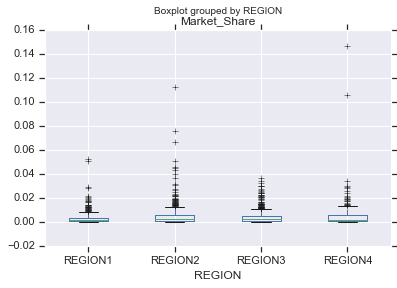

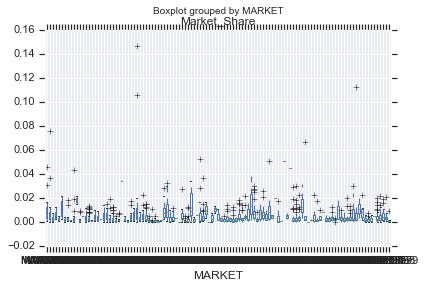

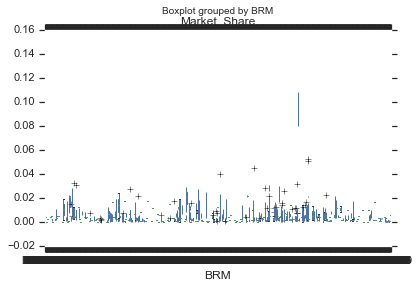

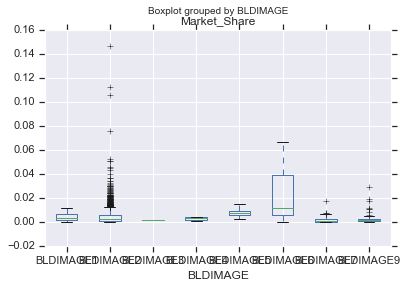

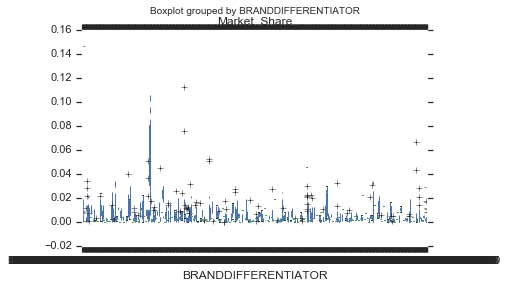

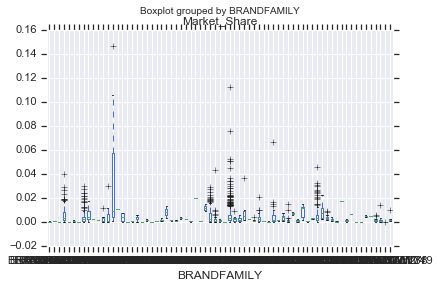

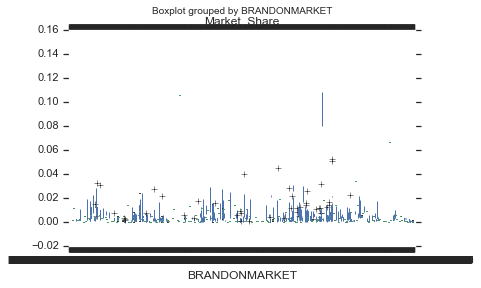

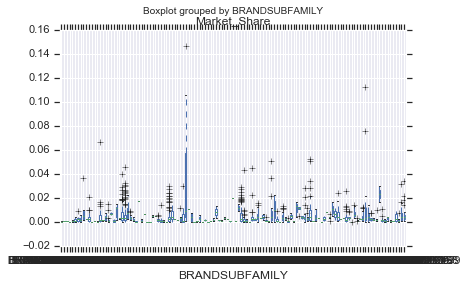

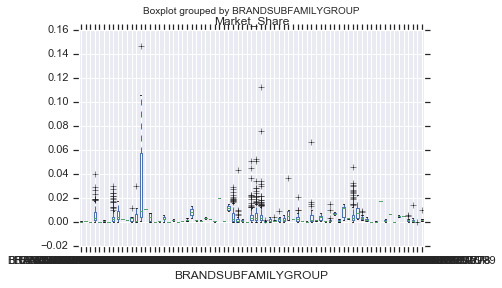

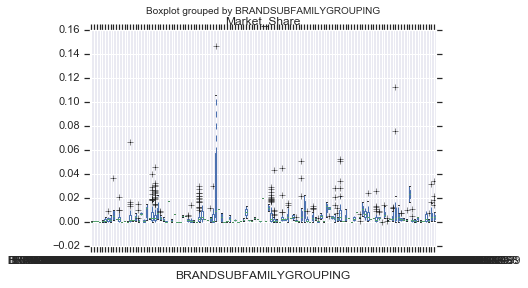

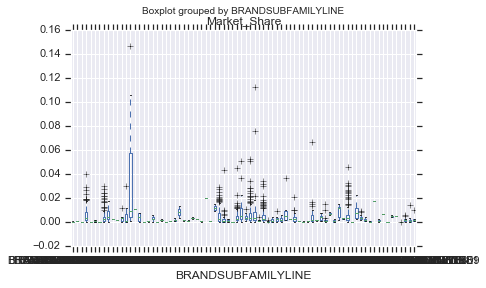

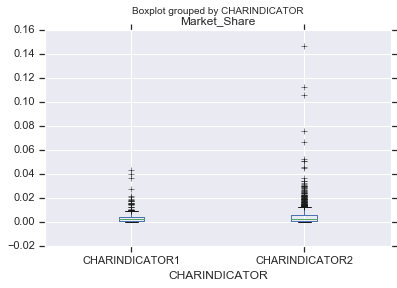

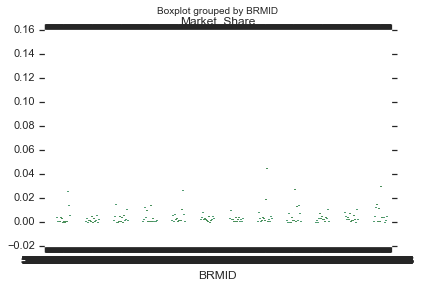

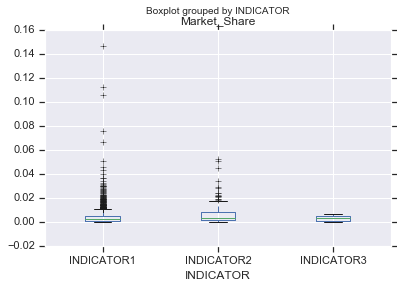

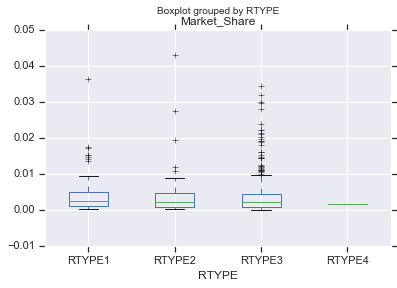

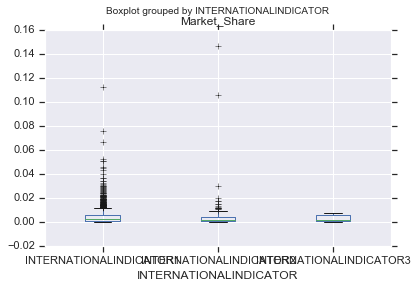

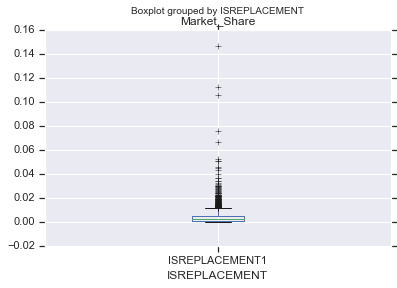

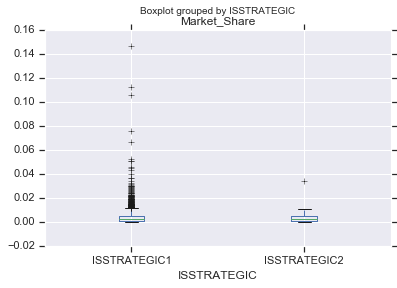

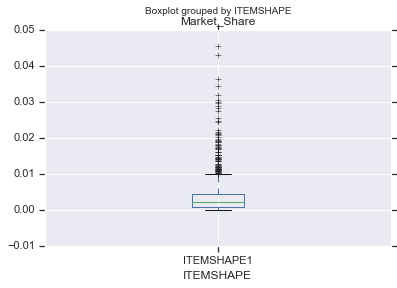

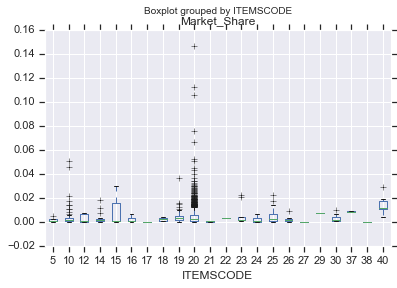

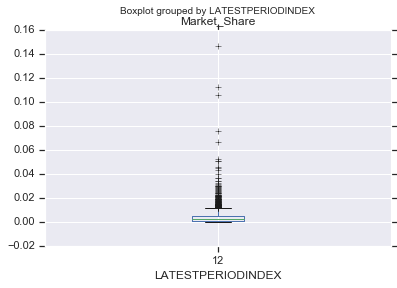

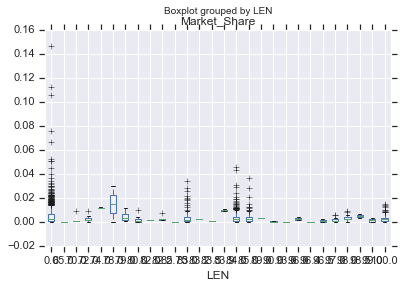

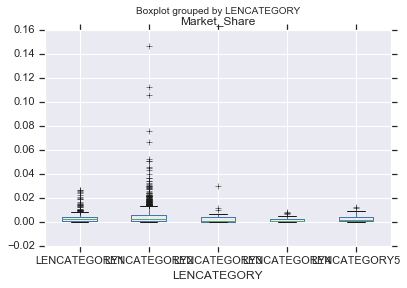

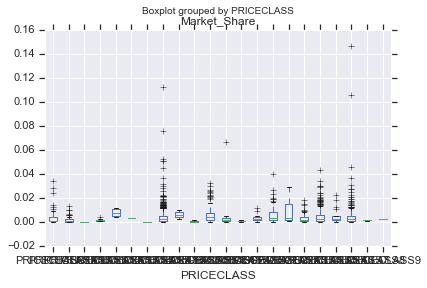

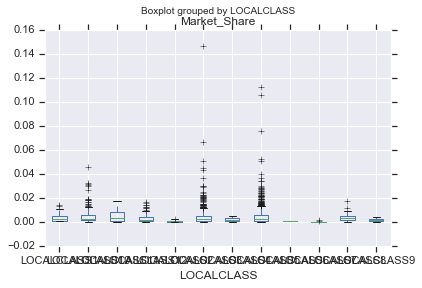

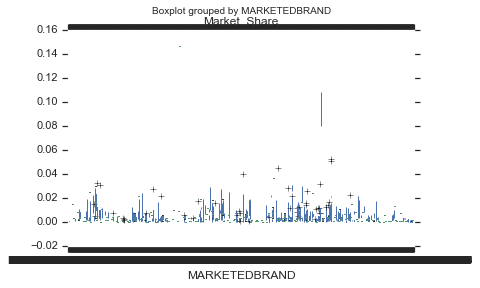

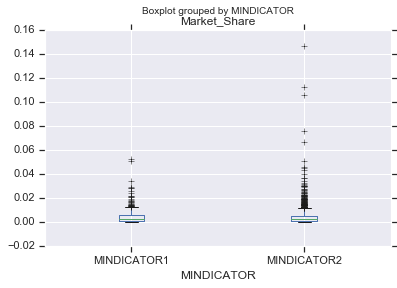

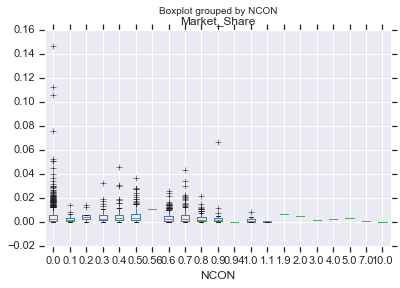

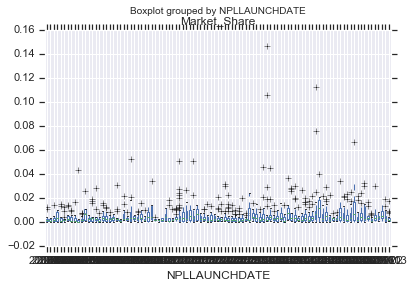

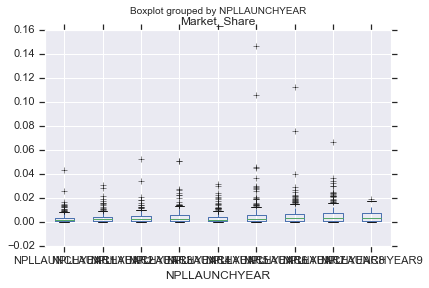

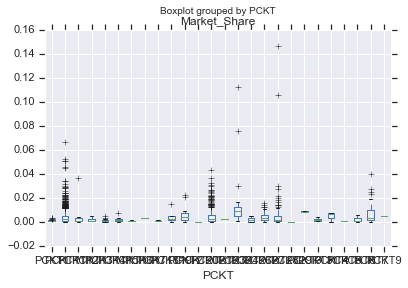

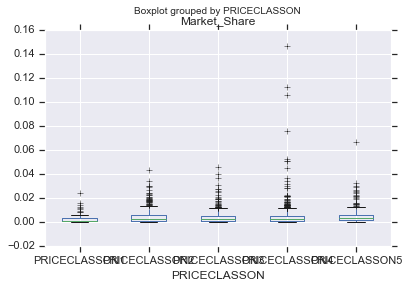

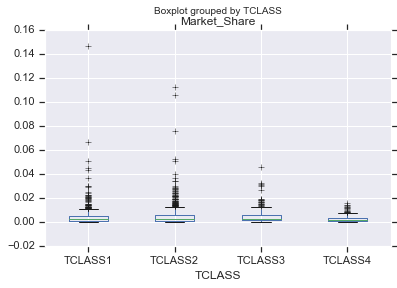

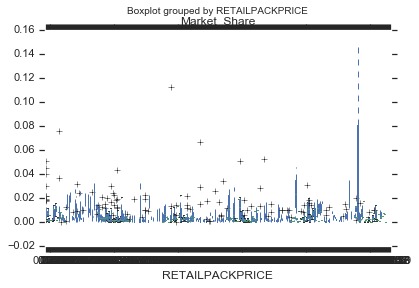

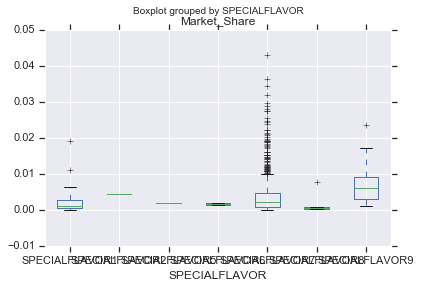

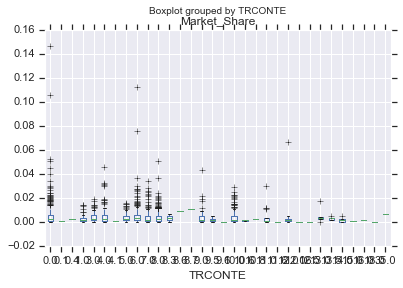

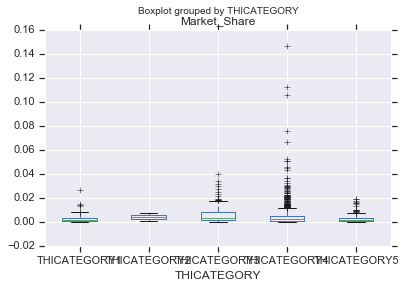

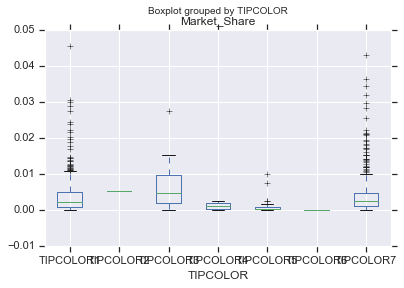

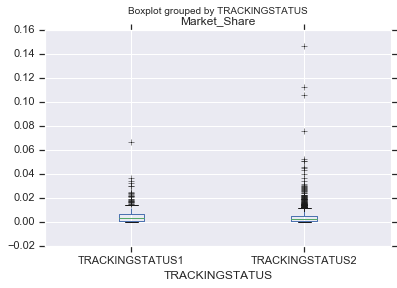

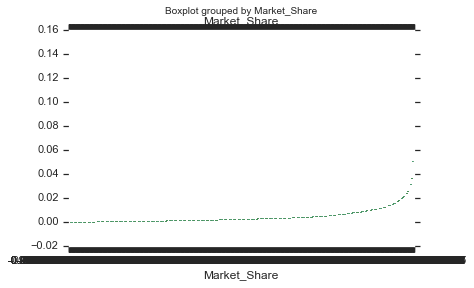

In [4]:
for col in df_case.columns:
    plt.figure(figsize=(15,10))
    df_case.boxplot('Market_Share', by=col)
    plt.show()

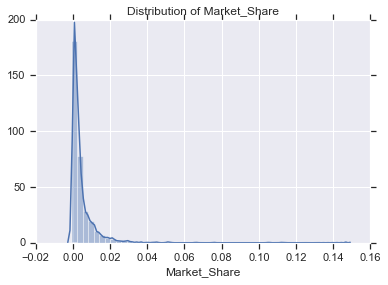

In [3]:
# Plot dependent variable distribution
sns.distplot(df_case['Market_Share'])
plt.title('Distribution of Market_Share')
plt.savefig('image/Market_Share_dist.jpg')
plt.show()

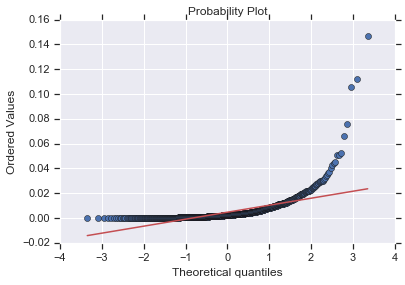

In [5]:
import scipy.stats as stats
import pylab

stats.probplot(df_case['Market_Share'], dist='norm', plot=pylab)
pylab.savefig('image/qqplot.jpg')
pylab.show()

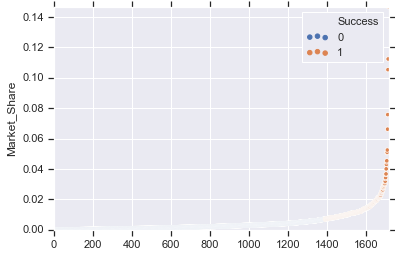

Success rate: 18.939394 %


In [6]:
# create label
threshold = 0.007
df_label = df_case.copy()
df_label['Success'] = np.where(df_case['Market_Share'] > threshold, 1, 0)
df_label = df_label.sort_values(by='Market_Share')

# Plot the success rate and market distribution sorted
g = sns.scatterplot(x=range(len(df_label)), y='Market_Share', data=df_label, hue='Success')
g.set(ylim=(0, max(df_case['Market_Share'])))
g.set(xlim=(0, len(df_label)))
plt.show()

print('Success rate: {:2f} %'.format(df_label['Success'].sum()/len(df_label)*100))

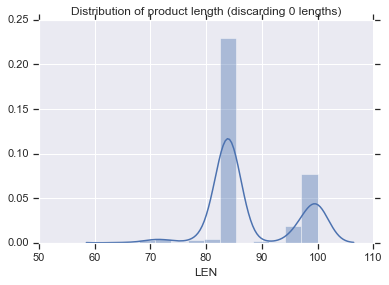

In [5]:
sns.distplot(df_case[df_case['LEN'] != 0]['LEN'])
plt.title('Distribution of product length (discarding 0 lengths)')
plt.savefig('image/LEN_dist.png')
plt.show()

Given the context of the use case, we are most likely dealing with PMI brand/flavor/product launches. The LEN feature describes the length of cigarettes ["The length varies from what is known as King Size (84 mm) to 100s (100 mm)."](https://en.wikipedia.org/wiki/Cigarette#Construction).  
Features understanding:
- REGION: one of the four continents (could be inferred from distributions)
- MARKET: countries/market where product is launched
- BRANDFAMILY(LINE/GROUP/..): L&M, Marlboro, Philip Morris etc..., Group/Line could be Gold, Blue, Light etc...
- BLDIMAGE: Image (blend?) related on the package
- INDICATOR: Indication on packages (i.e. warnings and/or cigarete content)
- NPLLAUNCHDATE: New Product Launch date: year concatenated with month (+category)
- RETAILPACKPRICE: Packet price in local currency (category referring to range standardized or currency)
- SECIALFLAVOR: raspberry, violet etc... (i.e. additives)
- ITEMSHAPE: shape of packet
- TIPCOLOR: Color of the cigarette butt or packet

Possible features may involve filter, paper, tobacco blend, additives category and other marketing insights.

## Pre Processing <a class="anchor" id="preprocessing"></a>

Key aspect of this business use case is the categorical data. In order to be processed we need to encode these categories.
This encoding will depend on whether the category is nominal or ordinal (if we can arrange in a sorting order). 

In [7]:
def rmvText(word):
    '''Return numerics only in a word'''
    if word is not np.nan:
        matches = re.findall('\d+', word)
        if len(matches) == 1:
            return np.int_(matches[0])
        else:
            print('Multiple or 0 num values found')
            return matches
    else:
        return word

In [8]:
# Remove text in dataframe for categories
df_nums = df_case.select_dtypes(include=['object']).applymap(rmvText)
categories = df_nums.columns
df_no_text = df_case.copy()
df_no_text.update(df_nums)
for col in categories:
    df_no_text[col] = df_no_text[col].astype('category')
df_no_text.head()

REGION MARKET BRM BLDIMAGE BRANDDIFFERENTIATOR BRANDFAMILY BRANDONMARKET  \
0      1      7  36        9                  98          12            36   
1      1      7  37        9                  98          12            37   
2      1      7  38        9                  98          12            38   
3      1      7  58        9                 267          12            58   
4      1      7  73        9                 467          12            73   

  BRANDSUBFAMILY BRANDSUBFAMILYGROUP BRANDSUBFAMILYGROUPING      ...       \
0             12                  12                     12      ...        
1             12                  12                     12      ...        
2             12                  12                     12      ...        
3             12                  12                     12      ...        
4             12                  12                     12      ...        

  PCKT PRICECLASSON  TCLASS RETAILPACKPRICE SPECIALFLAVOR TRCONTE THICATEGORY  \
0   11            2       2           15.00           7.0    10.0           4   
1   11            2       2           19.55           7.0    10.0           4   
2   11            2       2           27.00           7.0    10.0           4   
3   11            2       2           29.25           7.0     8.0           4   
4   11            2       2           15.00           7.0    11.0           4   

  TIPCOLOR TRACKINGSTATUS  Market_Share  
0      1.0              2      0.001440  
1      1.0              2      0.002881  
2      1.0              2      0.028870  
3      1.0              2      0.018922  
4      1.0              2      0.000928  

[5 rows x 40 columns]

In [9]:
# Convert categories to floating numbers for NaN values and preocessing steps
for col in df_no_text.columns:
    df_no_text[col] = df_no_text[col].astype('float')

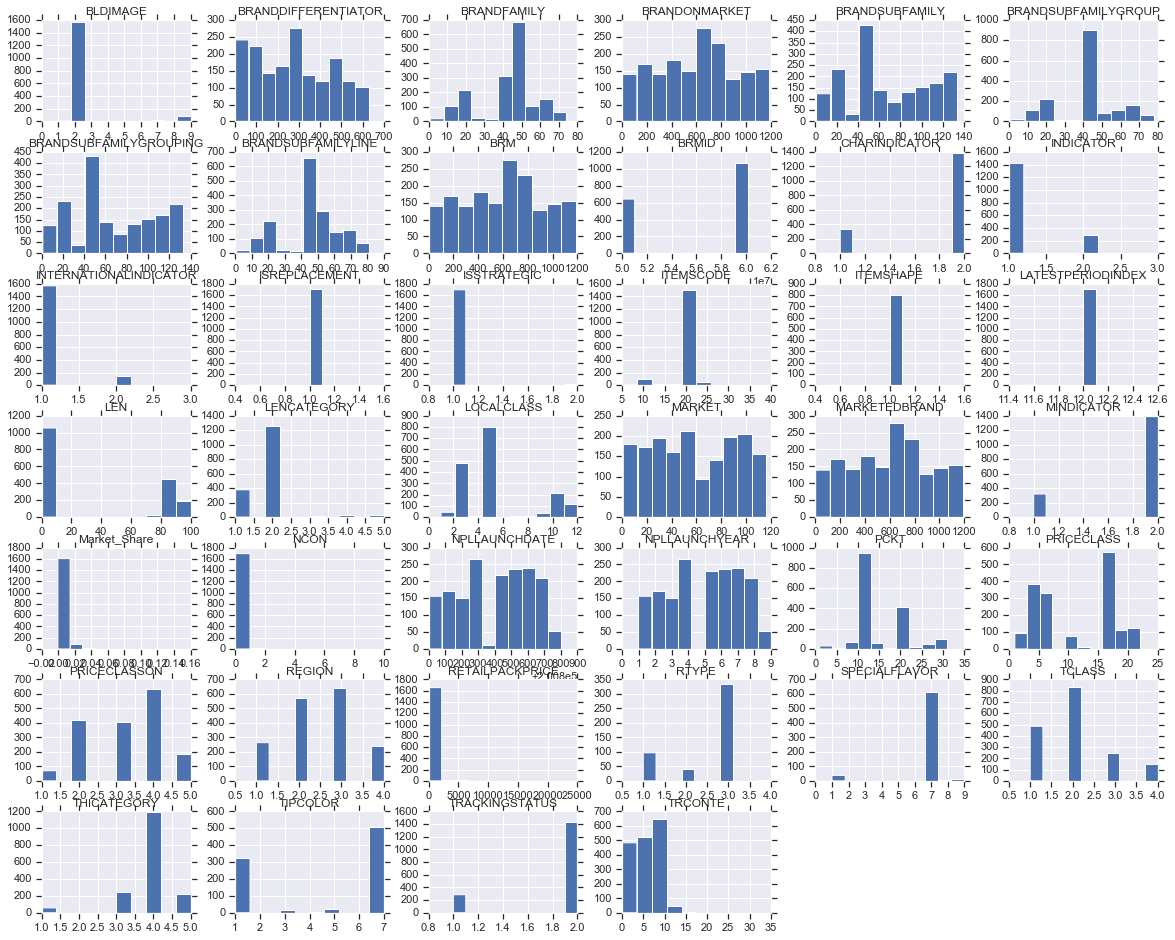

In [10]:
# Plot all distributions to identify obvious patterns
df_no_text.hist(figsize=(20, 16))
plt.show()

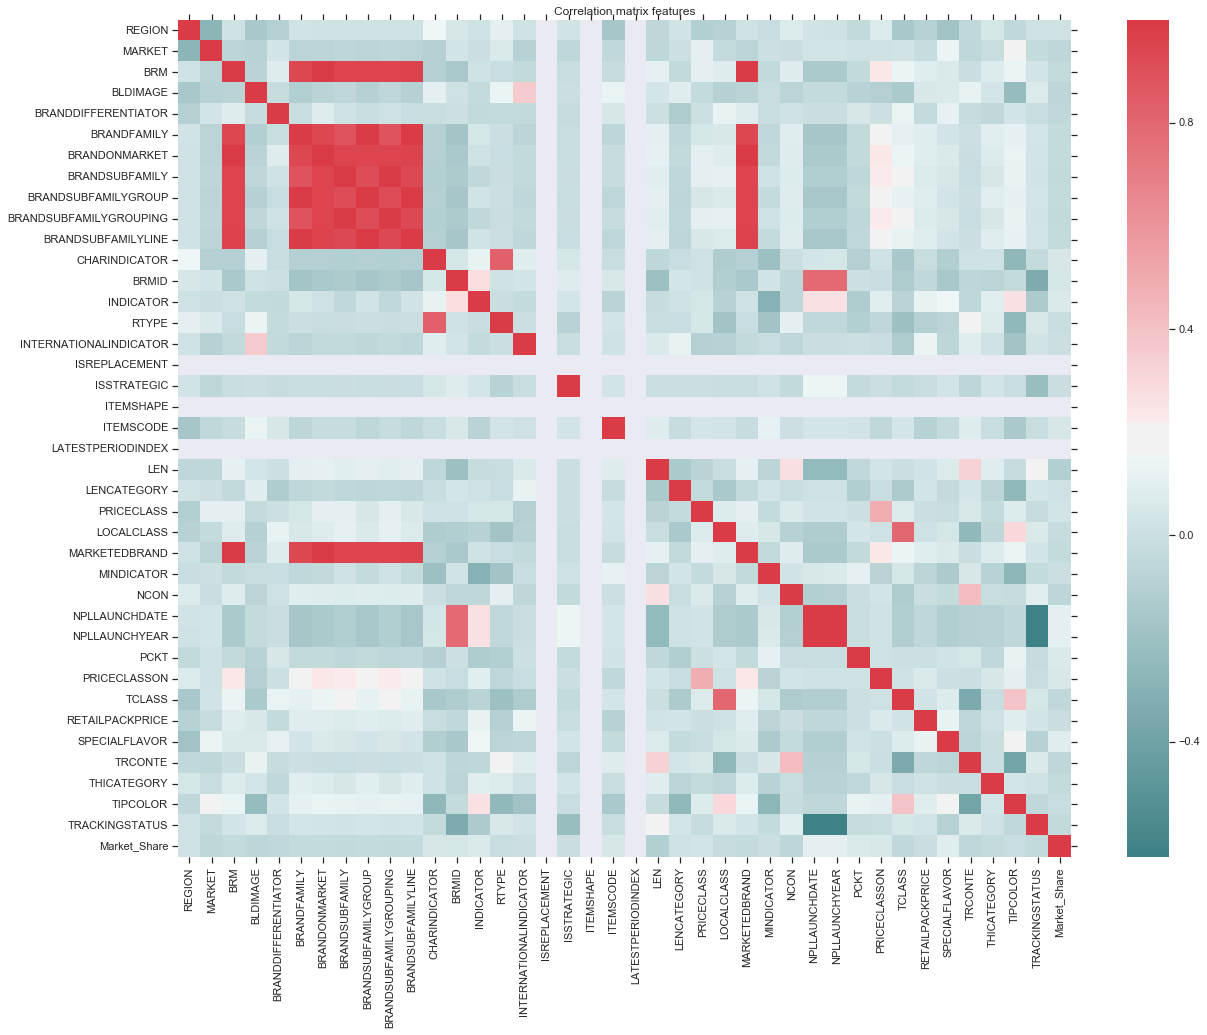

x                       y      corr
0                      BRM           BRANDONMARKET  0.999999
1                      BRM          BRANDSUBFAMILY  0.953794
2                      BRM     BRANDSUBFAMILYGROUP  0.953629
3                      BRM  BRANDSUBFAMILYGROUPING  0.953794
4                      BRM      BRANDSUBFAMILYLINE  0.961794
5                      BRM           MARKETEDBRAND  0.999999
6              BRANDFAMILY     BRANDSUBFAMILYGROUP  0.997816
7              BRANDFAMILY      BRANDSUBFAMILYLINE  0.993806
8            BRANDONMARKET          BRANDSUBFAMILY  0.953794
9            BRANDONMARKET     BRANDSUBFAMILYGROUP  0.953629
10           BRANDONMARKET  BRANDSUBFAMILYGROUPING  0.953794
11           BRANDONMARKET      BRANDSUBFAMILYLINE  0.961794
12           BRANDONMARKET           MARKETEDBRAND  1.000000
13          BRANDSUBFAMILY  BRANDSUBFAMILYGROUPING  1.000000
14          BRANDSUBFAMILY           MARKETEDBRAND  0.953796
15     BRANDSUBFAMILYGROUP      BRANDSUBFAMILYLINE  0.998661
16     BRANDSUBFAMILYGROUP           MARKETEDBRAND  0.953630
17  BRANDSUBFAMILYGROUPING           MARKETEDBRAND  0.953796
18      BRANDSUBFAMILYLINE           MARKETEDBRAND  0.961796
19           NPLLAUNCHDATE           NPLLAUNCHYEAR  0.999891

In [10]:
# Compute mutual correlations
corr = df_no_text.corr()

def dispCorr(corr):
    # Plot correlation matrix
    plt.subplots(figsize=(20,15))
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values, cmap=sns.diverging_palette(200, 10,as_cmap=True))
    plt.title('Correlation matrix features')
    plt.show()
    
    # Display highly correlated features
    features = set()
    df_hcorr = pd.DataFrame(columns=['x', 'y', 'corr'])
    for col in corr:
        features.add(col)
        for row in corr:
            correlation = corr.loc[row, col]
            if (row not in features and (abs(correlation) > 0.95)):
                df_hcorr = df_hcorr.append(pd.Series({'x': col,'y': row,'corr': correlation}), ignore_index=True)
    return df_hcorr

dispCorr(corr)

In [11]:
def listDiff(row):
    print('---', row['x'], row['y'], row['corr'],'---')
    idx = df_no_text[row['x']] != df_no_text[row['y']]
    print(idx.sum(), 'rows strictly different')

In [80]:
# List number of rows that differs for highly correlated features
df_hcorr.apply(listDiff, axis=1)

--- BRM BRANDONMARKET 0.999999233623944 ---
17 rows strictly different
--- BRM BRANDSUBFAMILY 0.9537942412863172 ---
1715 rows strictly different
--- BRM BRANDSUBFAMILYGROUP 0.9536287463503402 ---
1715 rows strictly different
--- BRM BRANDSUBFAMILYGROUPING 0.9537942412863172 ---
1715 rows strictly different
--- BRM BRANDSUBFAMILYLINE 0.9617937945219709 ---
1715 rows strictly different
--- BRM MARKETEDBRAND 0.99999915473874 ---
24 rows strictly different
--- BRANDFAMILY BRANDSUBFAMILYGROUP 0.9978162491522108 ---
860 rows strictly different
--- BRANDFAMILY BRANDSUBFAMILYLINE 0.9938062449259775 ---
890 rows strictly different
--- BRANDONMARKET BRANDSUBFAMILY 0.953794241286317 ---
1715 rows strictly different
--- BRANDONMARKET BRANDSUBFAMILYGROUP 0.9536287463503402 ---
1715 rows strictly different
--- BRANDONMARKET BRANDSUBFAMILYGROUPING 0.953794241286317 ---
1715 rows strictly different
--- BRANDONMARKET BRANDSUBFAMILYLINE 0.9617937945219709 ---
1715 rows strictly different
--- BRANDONMAR

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
dtype: object

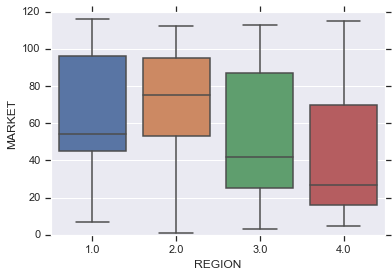

In [11]:
# Attempt to notice a numerical relationship in market numbers
sns.boxplot('REGION', 'MARKET', data=df_no_text)
plt.show()

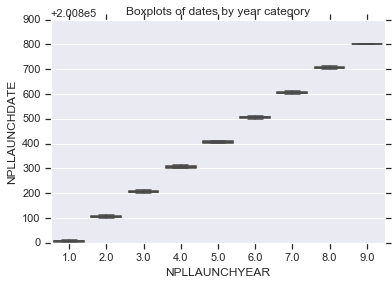

In [12]:
# plot NPL dates
sns.boxplot(x='NPLLAUNCHYEAR', y='NPLLAUNCHDATE', data=df_no_text)
plt.title('Boxplots of dates by year category')
plt.show()

Each year are encoded in an already existing category NPLLAUNCHYEAR hence let us infer a second category from the date: the month. In stock market forecasting there should not be cyclic dependency such as for weather for instance however it is important to make sure that the difference between 12 and 1 is the same than 1 and 2. Solution: $sin(2pi*X/12)$

In [13]:
# Apply cyclic value with sin(pi*X/6)
df_cyclic = df_no_text.copy()
df_cyclic['NPLLAUNCHDATE'] = np.sin(np.pi * (df_no_text['NPLLAUNCHDATE'] % 100) / 6)
df_cyclic = df_cyclic.rename(columns={'NPLLAUNCHDATE': 'NPLMONTH'})

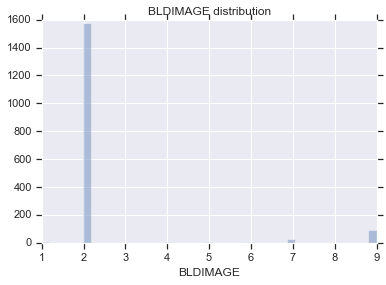

In [14]:
# Plot BLDIMAGE distribution
sns.distplot(df_cyclic['BLDIMAGE'], kde=False)
plt.title('BLDIMAGE distribution')
plt.savefig('image/BLDIMAGE.png')
plt.show()

In the case of sparsed categories, we create class grouping 95% percentile of the data observed and we create a category for others:

In [15]:
# Compute percentile
print(df_cyclic['BLDIMAGE'].value_counts())
print((1573+93)/len(df_cyclic))

2.0    1573
9.0      93
7.0      28
5.0       7
1.0       6
4.0       5
6.0       3
3.0       1
Name: BLDIMAGE, dtype: int64
0.9708624708624709


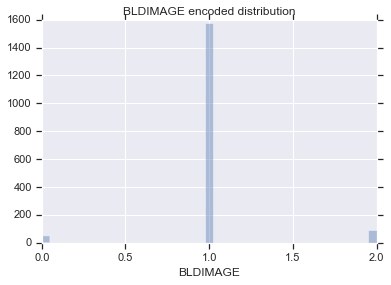

In [16]:
# Replace with a new encoded category
df_image = df_cyclic.copy()
df_image['BLDIMAGE'] = df_cyclic['BLDIMAGE'].replace({2:1, 9:2, 7:0, 5:0, 1:0, 4:0, 6:0, 3:0})
sns.distplot(df_image['BLDIMAGE'], kde=False)
plt.title('BLDIMAGE encoded distribution')
plt.savefig('image/BLDIMAGE_enc.png')
plt.show()

In [17]:
# Similar approach for ITEMSCODE
# Compute percentile
print(df_image['ITEMSCODE'].value_counts())
print((1391+101+91+35+16)/len(df_cyclic))

20.0    1391
19.0     101
10.0      91
25.0      35
14.0      16
23.0      14
30.0      10
24.0       9
16.0       8
18.0       6
40.0       6
26.0       6
12.0       5
21.0       4
5.0        4
15.0       3
37.0       2
38.0       1
22.0       1
17.0       1
29.0       1
27.0       1
Name: ITEMSCODE, dtype: int64
0.9522144522144522


In [18]:
# Replace with a new encoded category
df_code = df_image.copy()
df_code['PCKT'] = df_code['PCKT'].replace([2, 13, 31, 19, 12, 15, 6, 26, 16, 20, 4, 17, 18, 3, 29, 9, 23, 5], 0)

Binary category are encoded to 0 or 1, e.g. CHARINDICATOR, ISSTRATEGIC, MINDICATOR, TRACKINGSTATUS.

In [19]:
# dict encoder
d = {1:0, 2:1}
cols = ['CHARINDICATOR', 'ISSTRATEGIC', 'MINDICATOR', 'TRACKINGSTATUS']

df_bins = df_code.copy()
df_bins[cols] = df_bins[cols].replace(d)

We usually remove the id column however here if we plot the distribution we can clearly see two clusters. This might bring information and hence we will encode those two clusters.

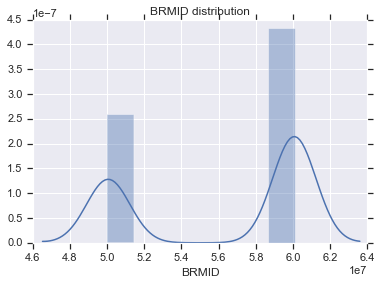

In [20]:
# Plot BRMID dist
sns.distplot(df_bins['BRMID'])
plt.title('BRMID distribution')
plt.savefig('image/BRMID_dist.png')
plt.show()

In [21]:
df_ids = df_bins.copy()
# Modulo trick to encode
df_ids['BRMID'] = (df_ids['BRMID'] / 10000000).astype(int) % 5

For the three Price-related features, we try to infer some property from visualization. Unfortunately there is no obvious relationship between them. RETAILPACKPRICE corresponds most likely to packet prices in the home country currency and hence cannot be standardize without the currency.

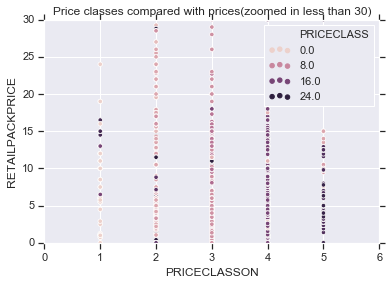

In [22]:
# scatter plot for price features
sns.scatterplot(x='PRICECLASSON', y='RETAILPACKPRICE', hue='PRICECLASS', data=df_ids)
plt.ylim((0, 30))
plt.title('Price classes compared with prices(zoomed in less than 30)')
plt.savefig('image/price.jpg')
plt.show()

# Remove local price since it cannot be standardized for the time being
df_noprice = df_ids.drop('RETAILPACKPRICE', axis=1)
df_no_text = df_noprice.copy()

### Missing Values
NaN values are located in categories. Given the amount of missing values, we assume that it has been omitted because it is not applcable to the product (e.g. a new product might not have any specific flavor). In the case of missing LEN, we associate it to the LENCATEGORY since it all corresponds to a range except few outliers (error?).

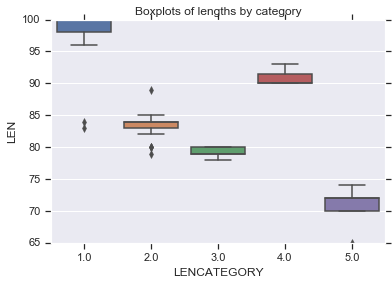

In [23]:
# plot lencategory
sns.boxplot(x='LENCATEGORY', y='LEN', data=df_no_text[df_no_text['LEN'] != 0])
plt.title('Boxplots of lengths by category')
plt.savefig('image/len_cat_boxplot.png')
plt.show()

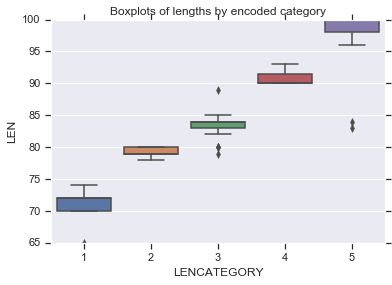

In [24]:
# Order categories
lencats_enc = {1: 5, 2:3, 3:2, 4:4, 5:1}
df_enc = df_no_text.copy()
df_enc['LENCATEGORY'] = df_enc['LENCATEGORY'].map(lencats_enc)

sns.boxplot(x='LENCATEGORY', y='LEN', data=df_enc[df_enc['LEN'] != 0])
plt.title('Boxplots of lengths by encoded category')
plt.savefig('image/len_cat_sorted.png')
plt.show()

For other numerical features, values being at 0 could be missing or set voluntarily to 0 to show that this is not applicable in the situation. Hence, we will keep 0.   
  
We have the similar situation for categorical data, however if we take SPECIALFLAVOR or TIPCOLOR NA might indicate there is no particular flavor or color respectively and then it makes sense to create a category to that end.

In [25]:
# Display classes
for col in df_no_text:
    print(col, len(df_no_text[col].unique()))
    print(df_no_text[col].unique())

REGION 4
[1. 2. 3. 4.]
MARKET 115
[  7.  41.  44.  45.  51.  54.  62.  65.  77.  82.  86.  96. 104. 106.
 116.   1.   2.   4.   6.  10.  13.  29.  34.  35.  36.  46.  48.  50.
  52.  53.  55.  56.  57.  59.  63.  67.  68.  69.  71.  72.  73.  74.
  75.  79.  81.  89.  90.  92.  93.  94.  95.  99. 103. 107. 108. 109.
 110. 111. 112.   3.   8.   9.  11.  15.  17.  18.  21.  23.  24.  25.
  26.  31.  32.  33.  37.  38.  42.  43.  47.  49.  58.  60.  61.  64.
  66.  76.  80.  87.  88.  91.  97.  98. 100. 101. 102. 113.   5.  12.
  14.  16.  19.  20.  22.  27.  28.  30.  39.  40.  70.  78.  83.  84.
  85. 114. 115.]
BRM 1099
[ 36.  37.  38. ... 929. 272. 273.]
BLDIMAGE 3
[2. 0. 1.]
BRANDDIFFERENTIATOR 584
[ 98. 267. 467. 121. 148. 259.   1. 425. 493. 230. 331. 272. 307. 310.
 301. 305. 302. 515.  41.  43.  64.  84.  92.  90. 194. 308. 309. 397.
 400. 454. 459. 620. 392. 605. 606. 433. 602. 385. 237. 615. 430. 421.
  86.  88. 152. 210. 297. 303. 304. 315. 314. 316. 386. 396. 452. 453.
 500. 

In [26]:
# Fill categories with a class arbitrarily set to 0
df_filled = df_no_text.fillna(0)
for cat in categories:
    df_filled[cat] = df_filled[cat].astype(int).astype('category')

### Feature Selection

First we remove all zero-variance features, i.e. features having the same value in all samples.

In [27]:
# Only keep feature with variance in sample
df_var = df_filled.columns[df_filled.var() != 0]
df_var = df_filled[df_var]
df_var.shape

(1716, 37)

In [28]:
# Split data and labels (continuous)
X = df_var.as_matrix(columns=df_var.columns[:df_var.shape[1]-1])
y = df_var['Market_Share']

C:\Users\Louis\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


We attempt to recognize an univariante linear relationship by plotting the linear relationship for each features.  
In addition we compute the F-test and mutual information (MI) which both attempt to capture any kind of dependency between the market share.

In [29]:
# Kruskal wallis since the dependent variable is skewed
statistics = []
for i in range(len(X[0, :])):
    statistics.append(stats.kruskal(X[:,i], y))
    
# List features not rejecting null hypothesis
for i, statistic in enumerate(statistics):
    if statistic.pvalue > 0.05:
        print(df_var.columns[i], statistic.statistic, statistic.pvalue)

NPLMONTH 0.7177563612084189 0.3968808508994368
TIPCOLOR 3.417963887299596 0.06449050847246605


In [30]:
# TRansform y to apply anova
qt = preprocessing.QuantileTransformer(output_distribution='normal')
y = qt.fit_transform((np.array(y)+1).reshape(-1,1)).reshape(len(X),)

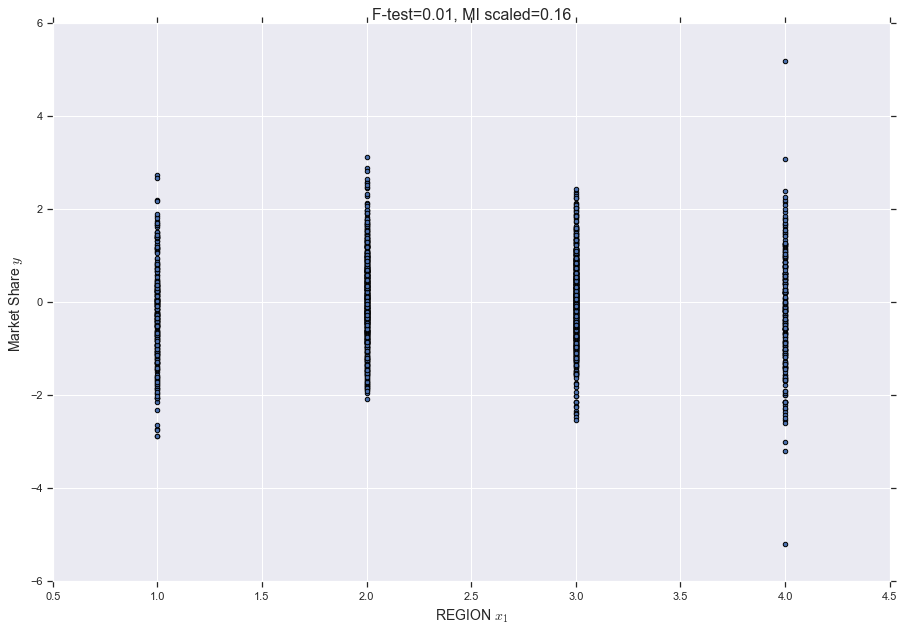

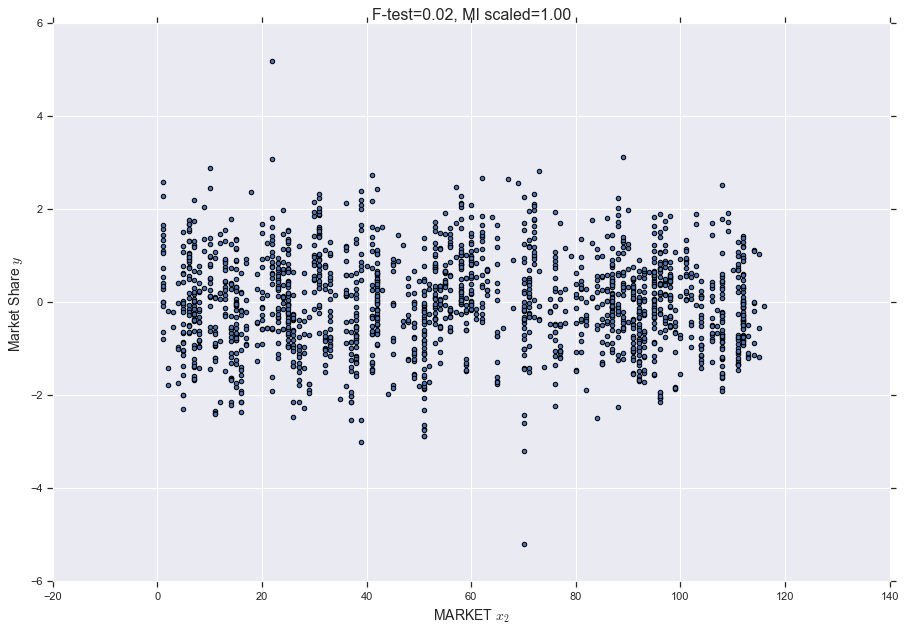

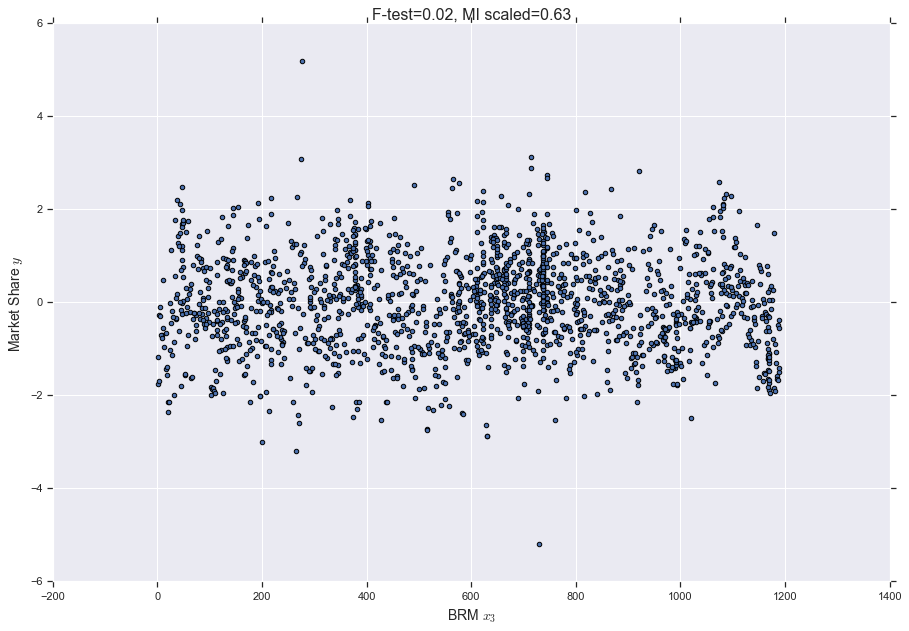

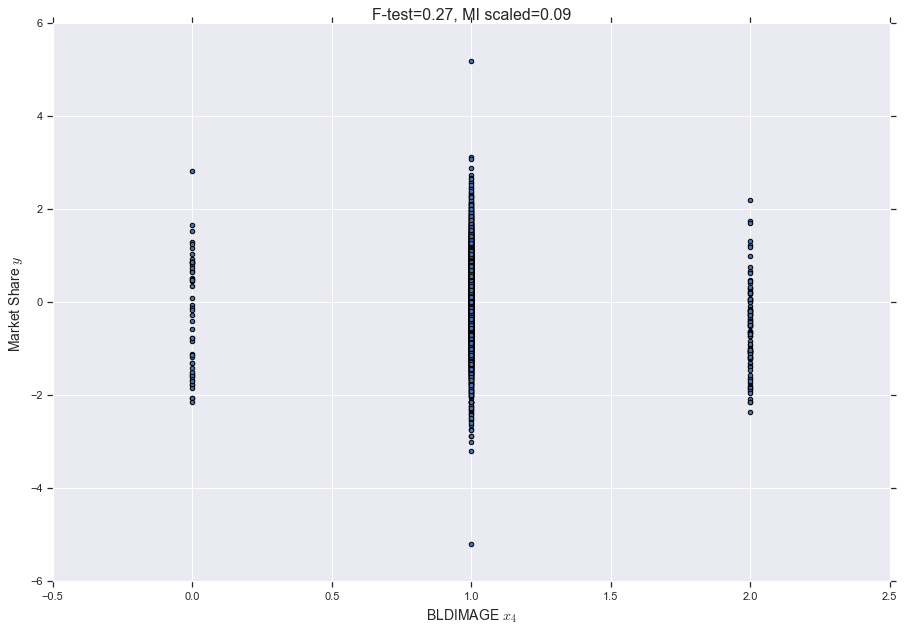

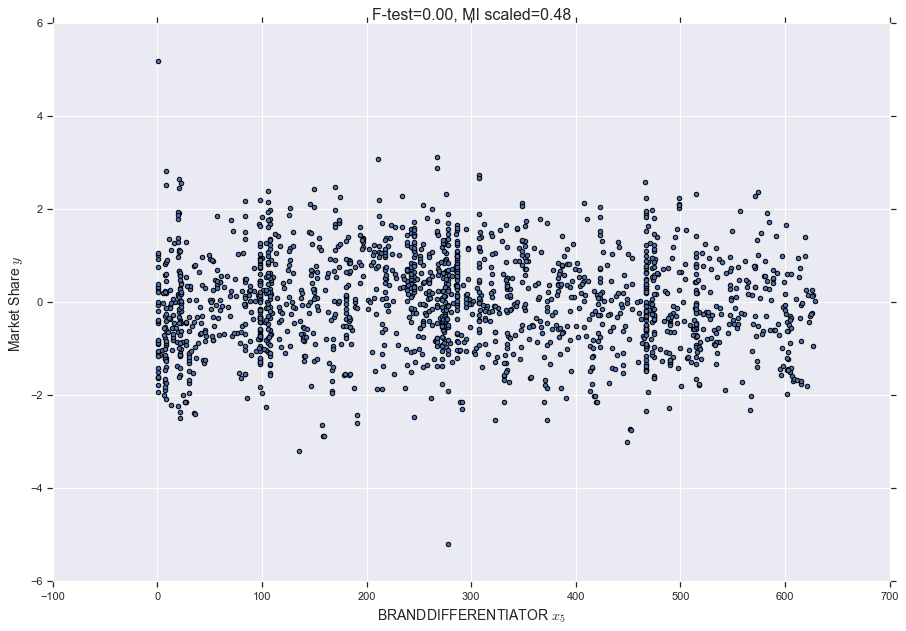

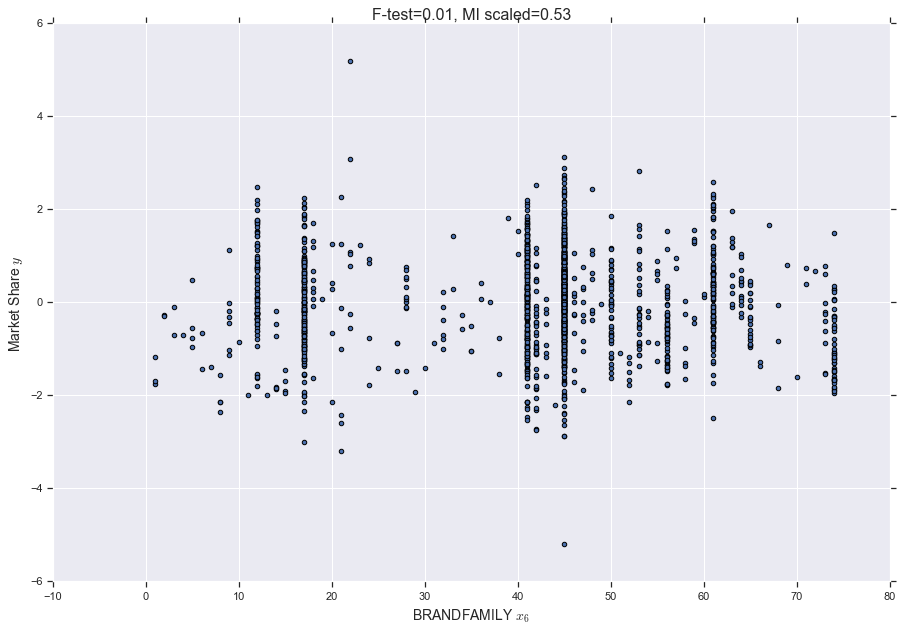

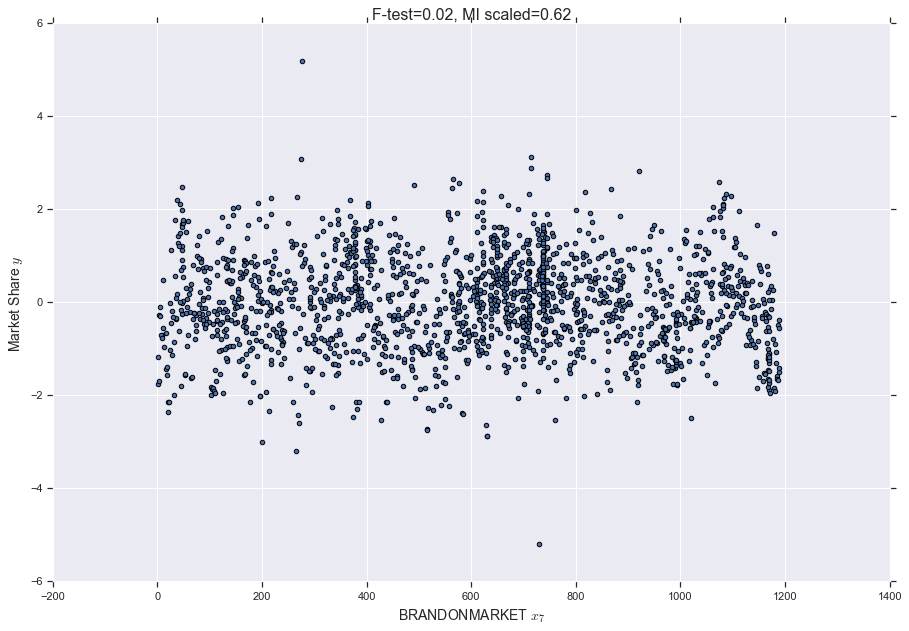

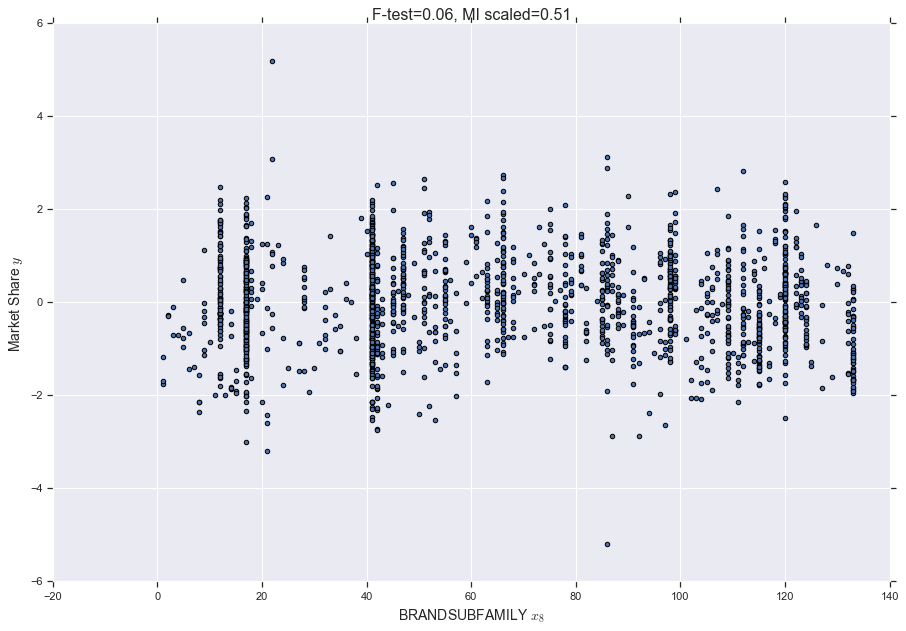

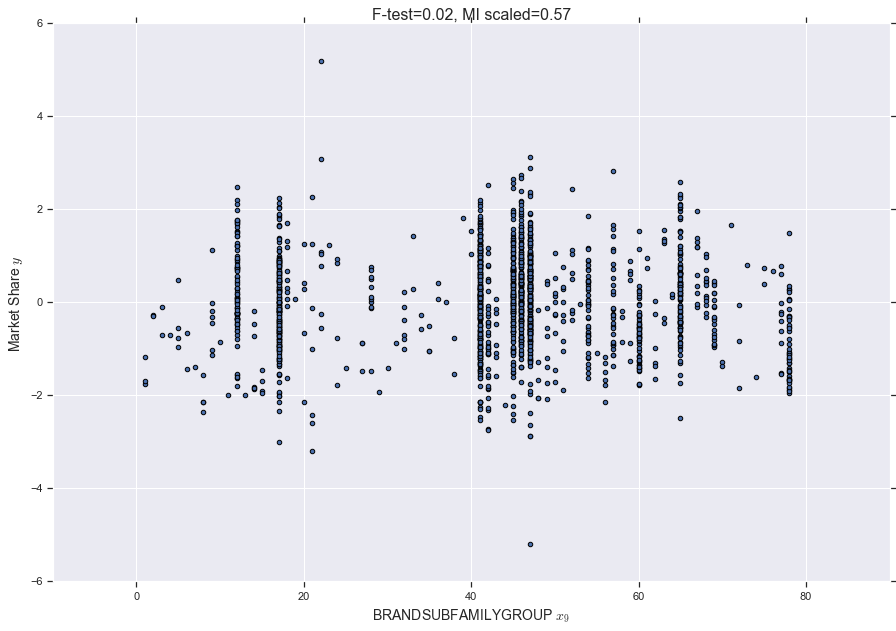

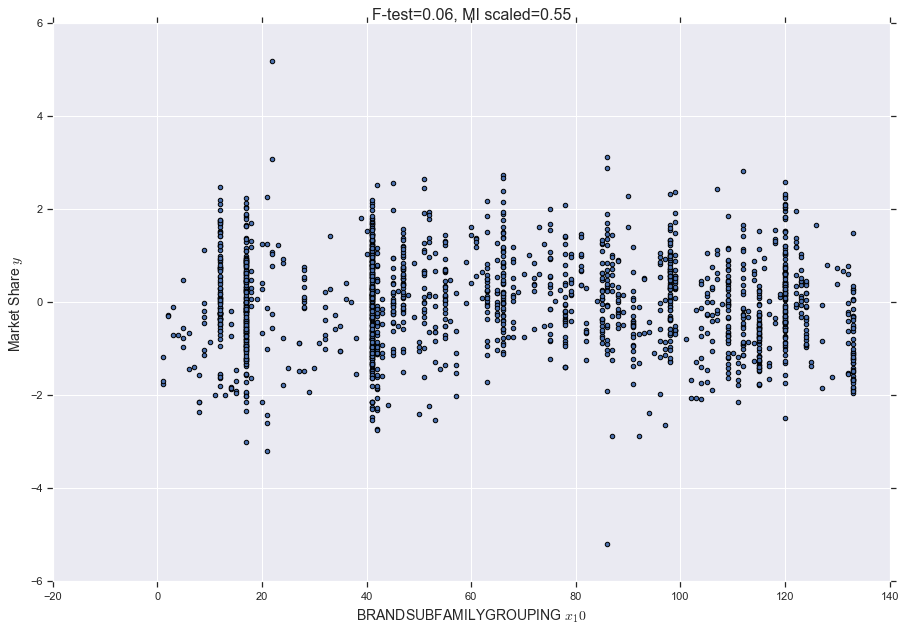

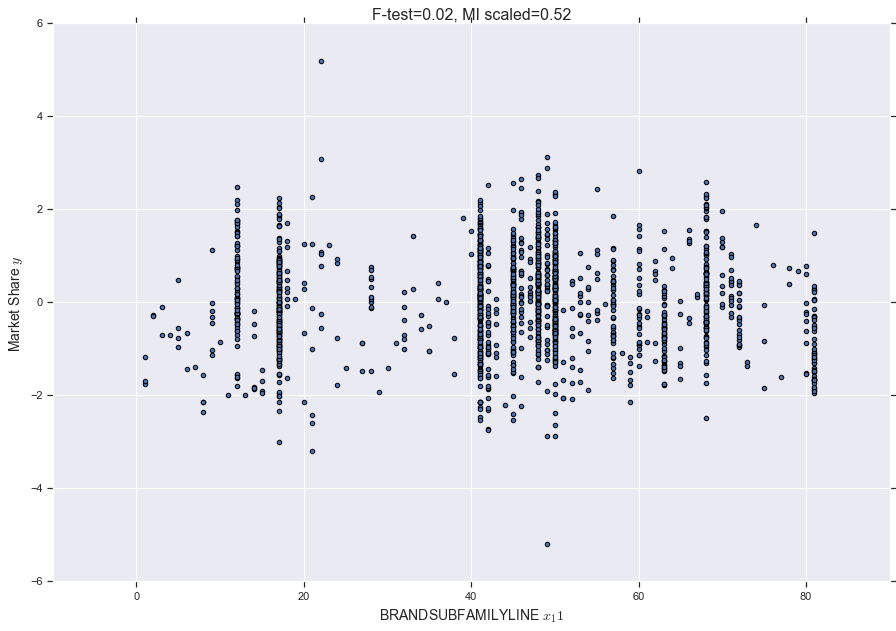

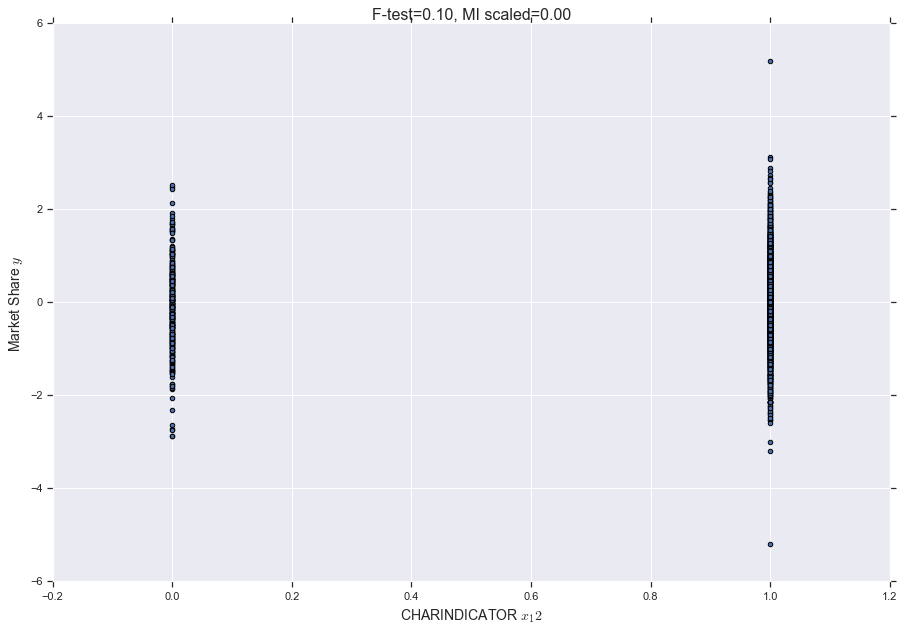

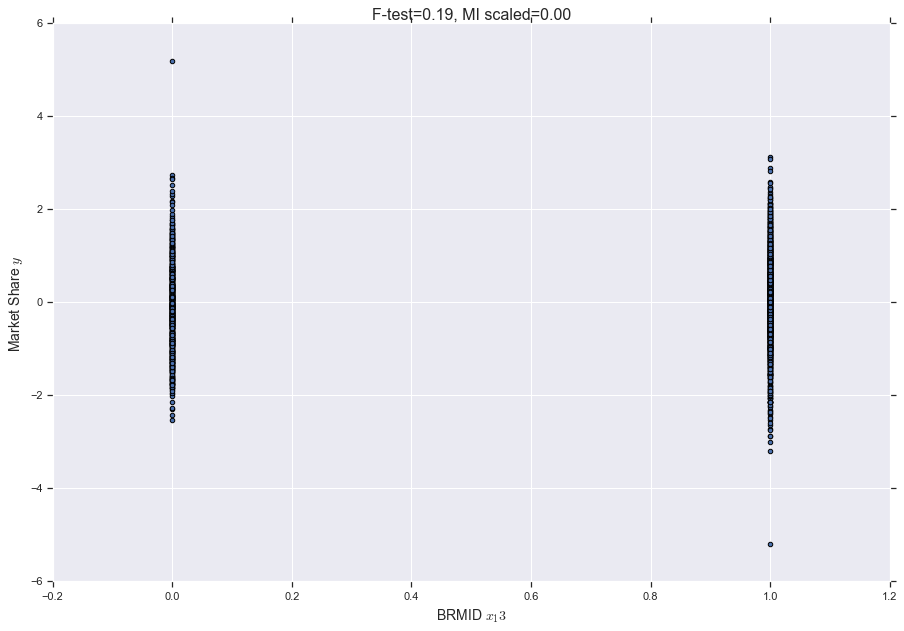

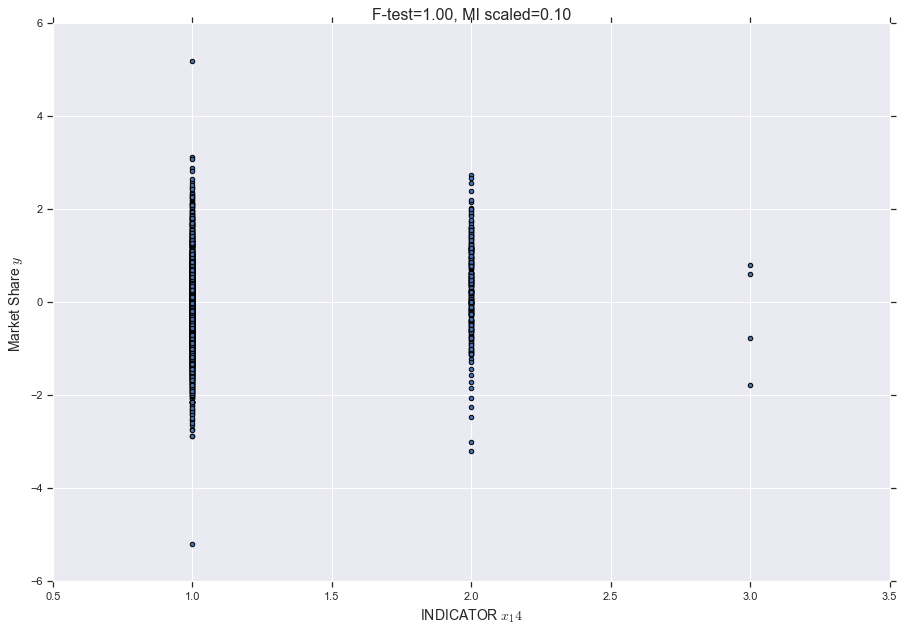

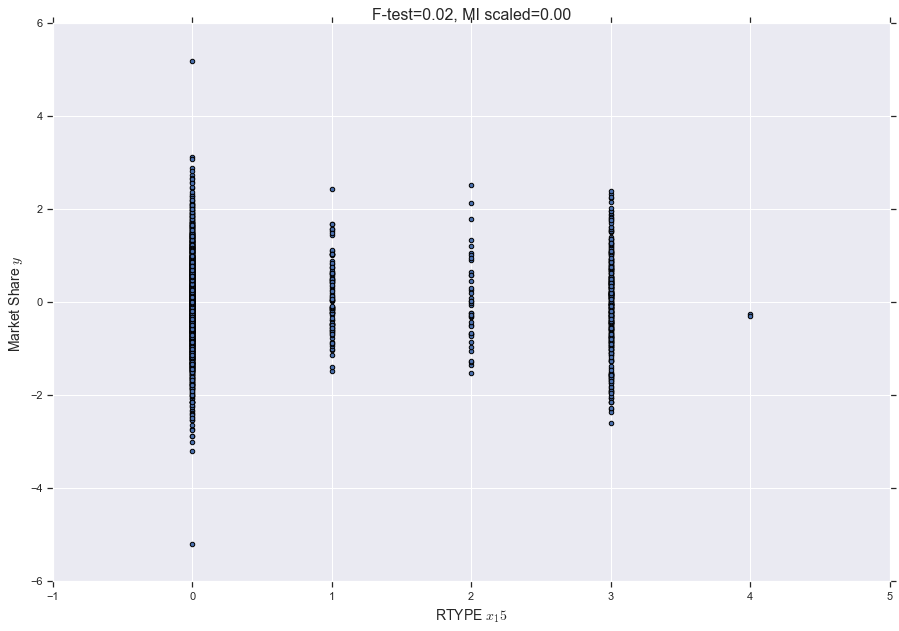

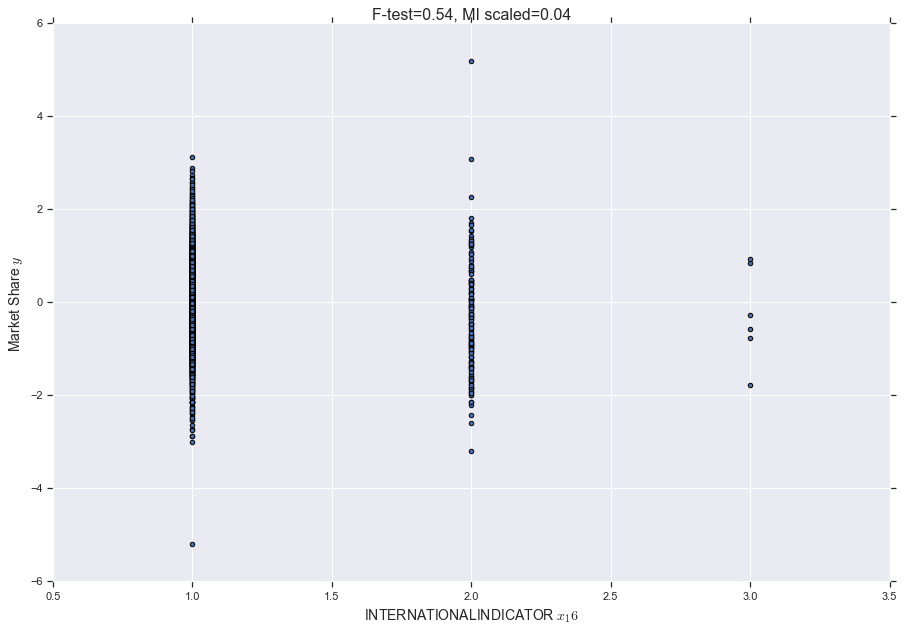

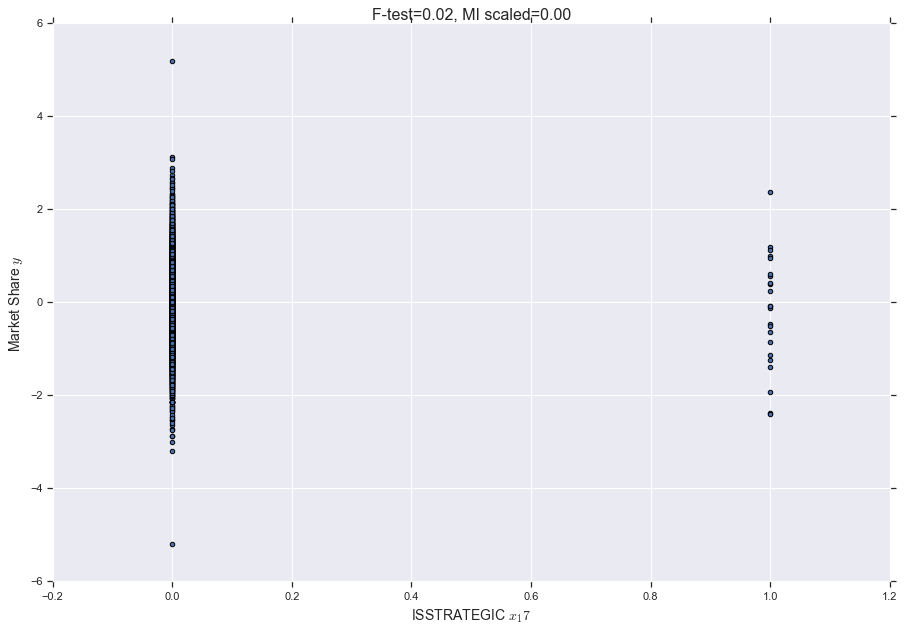

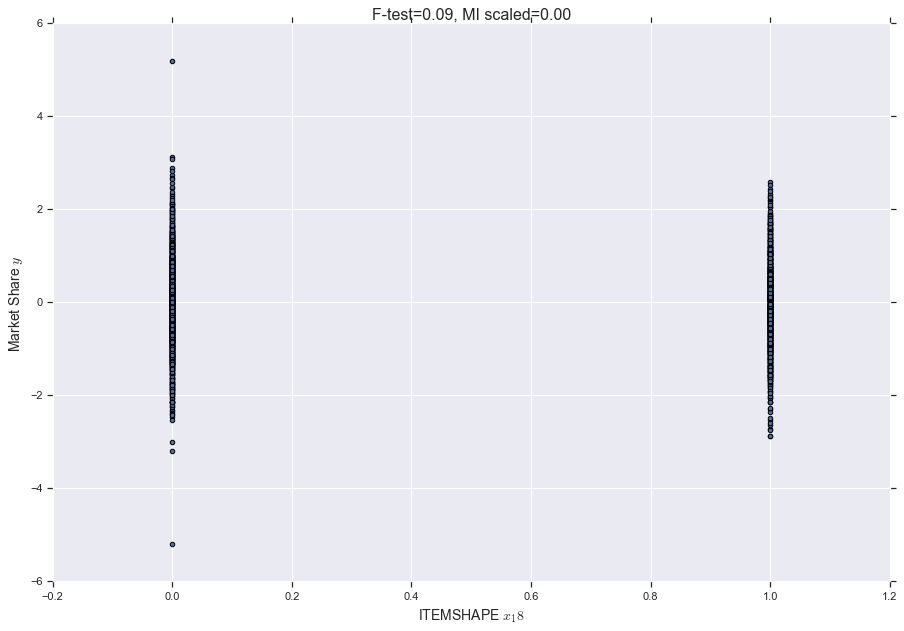

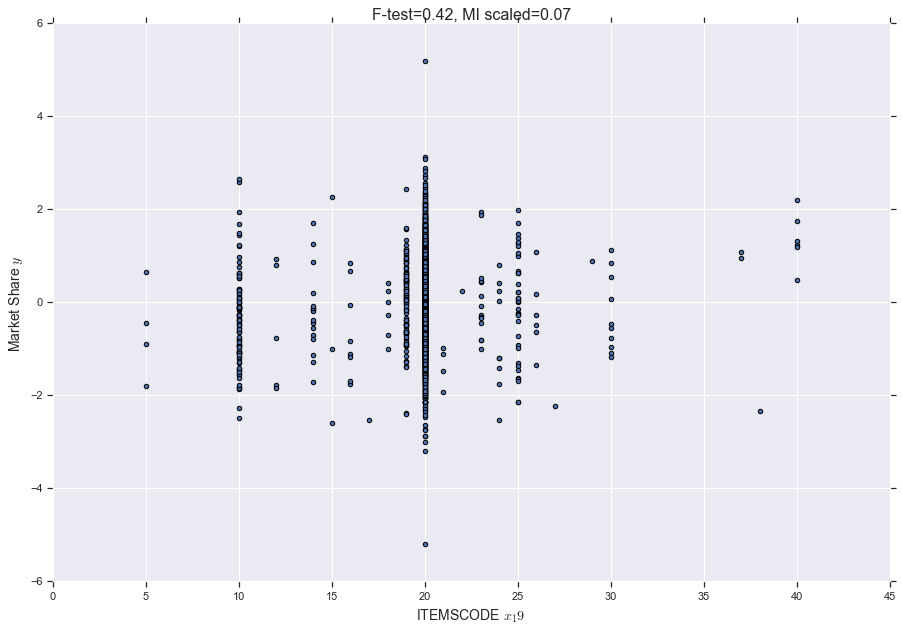

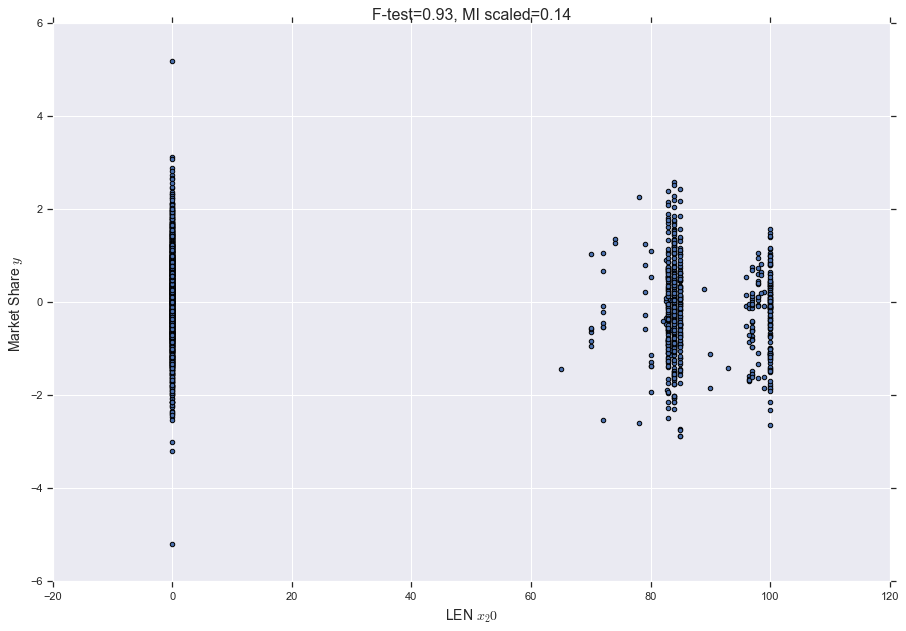

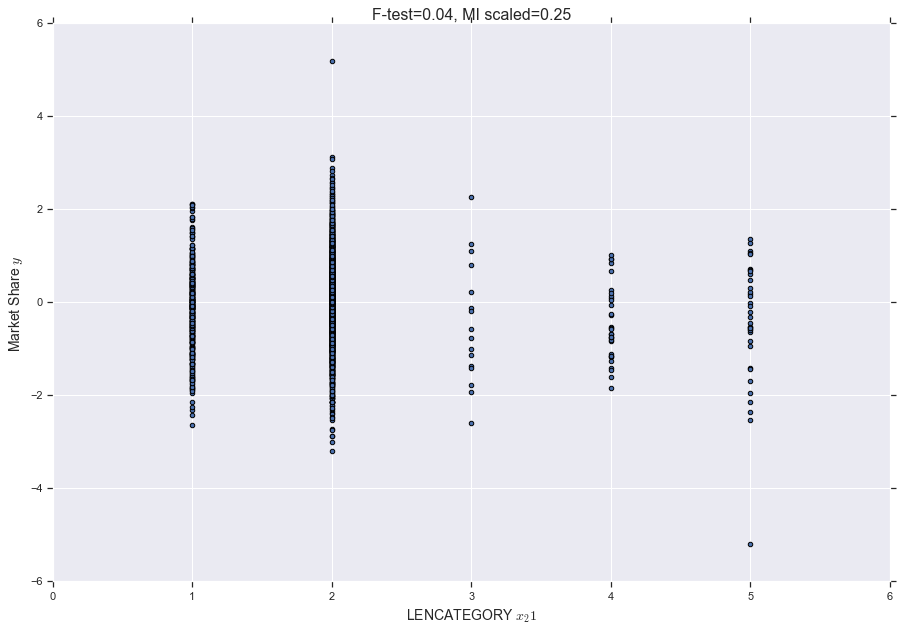

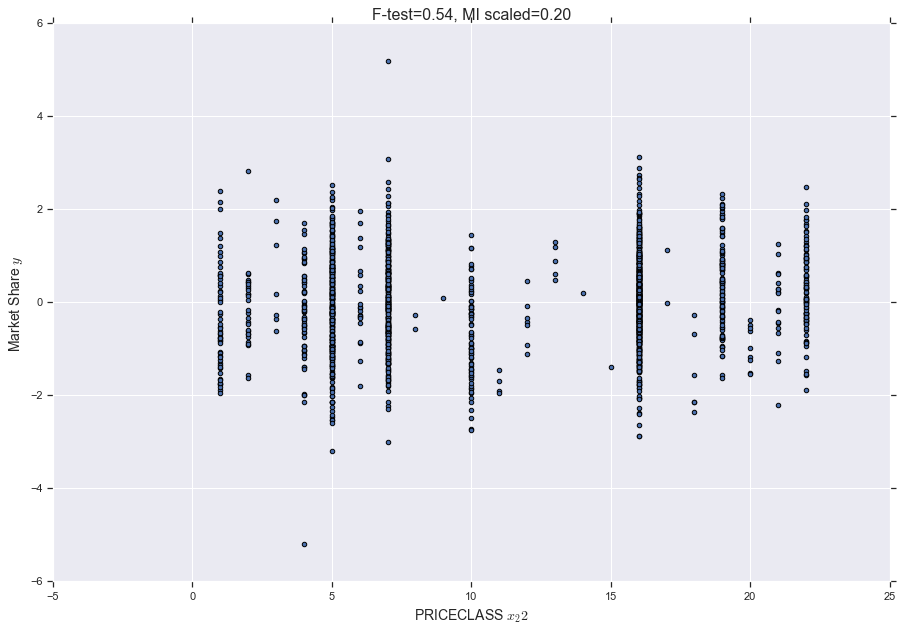

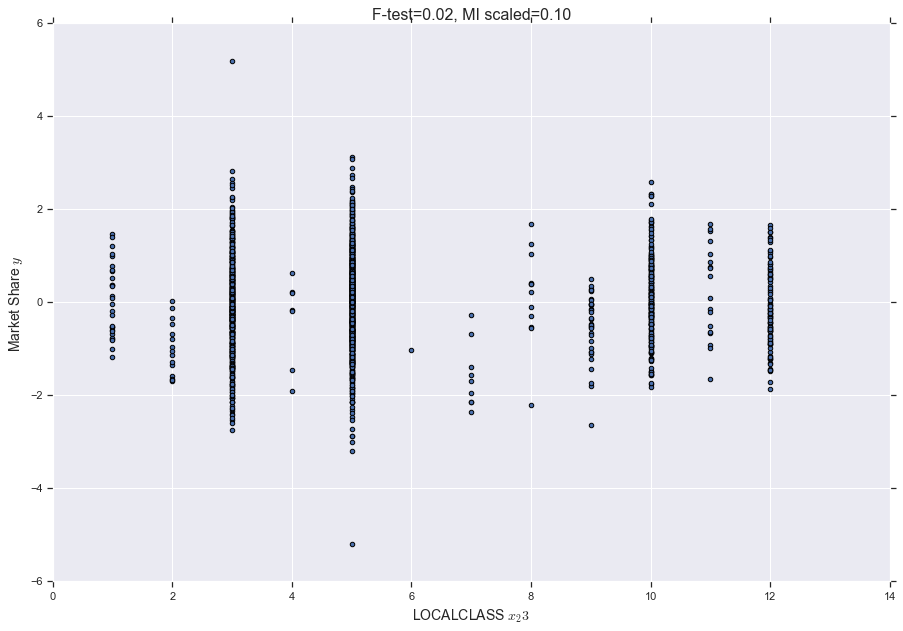

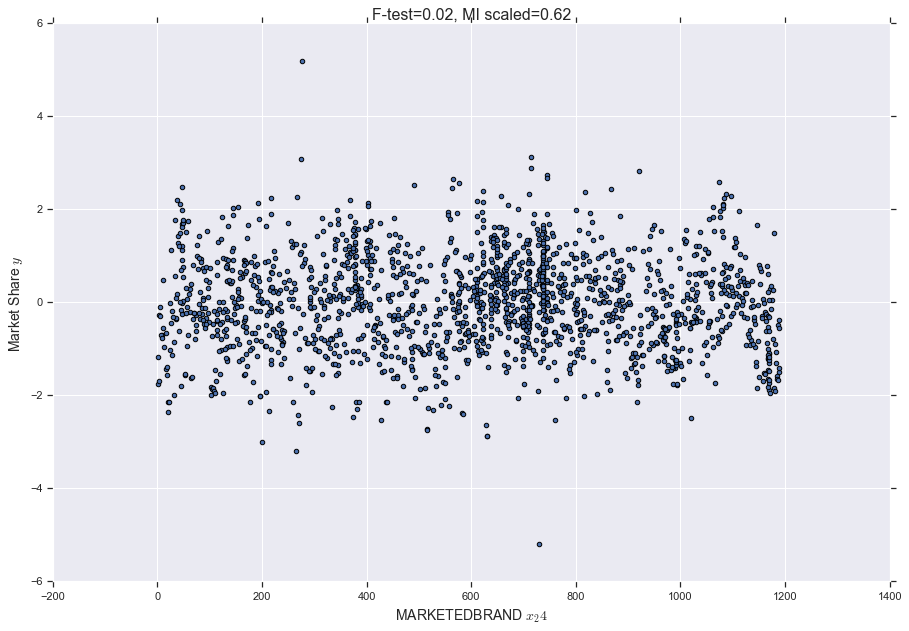

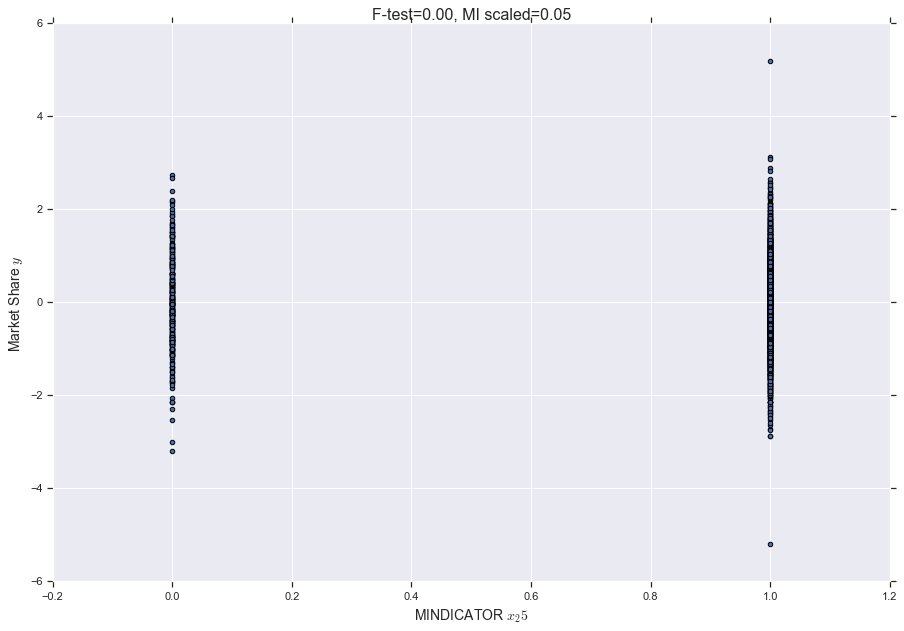

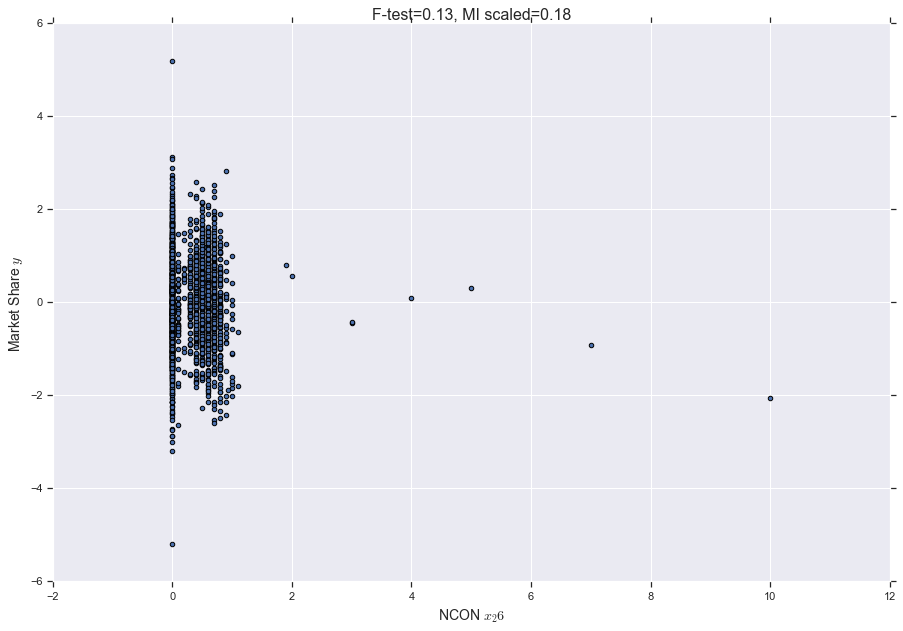

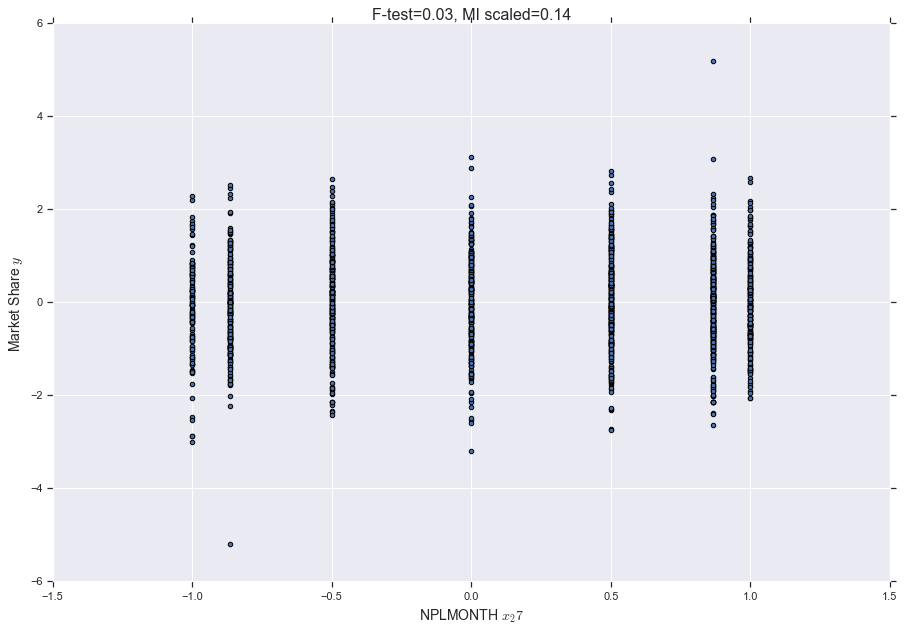

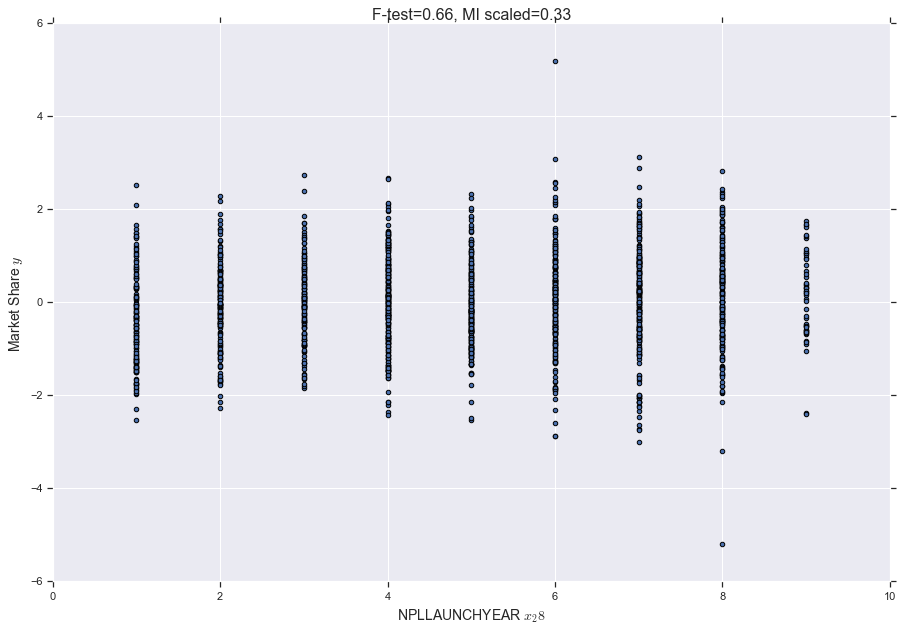

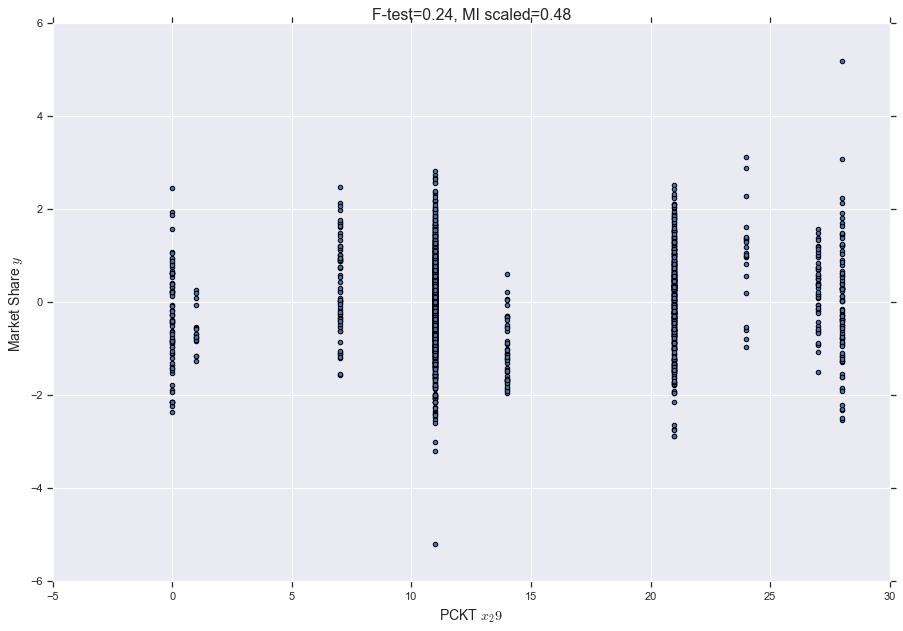

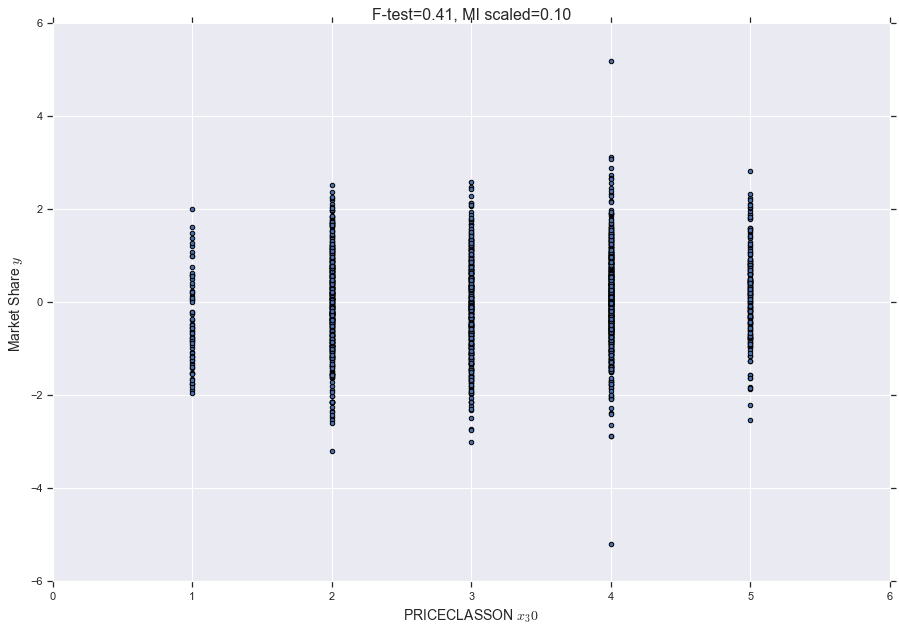

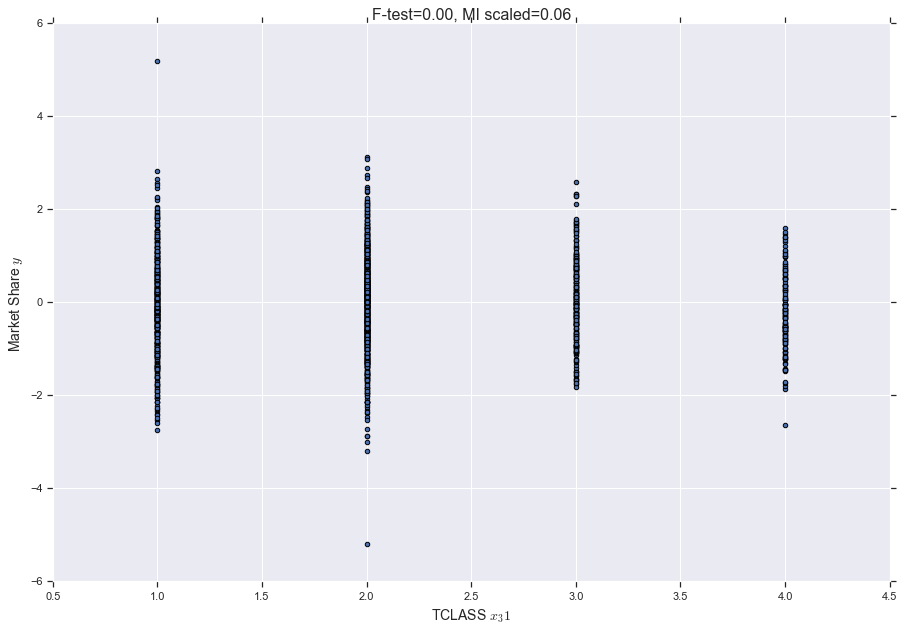

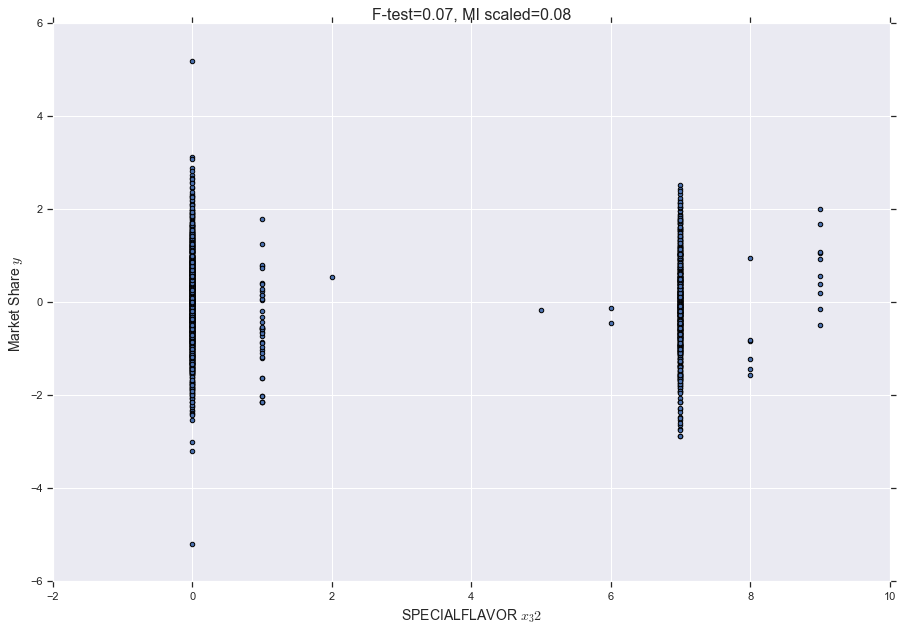

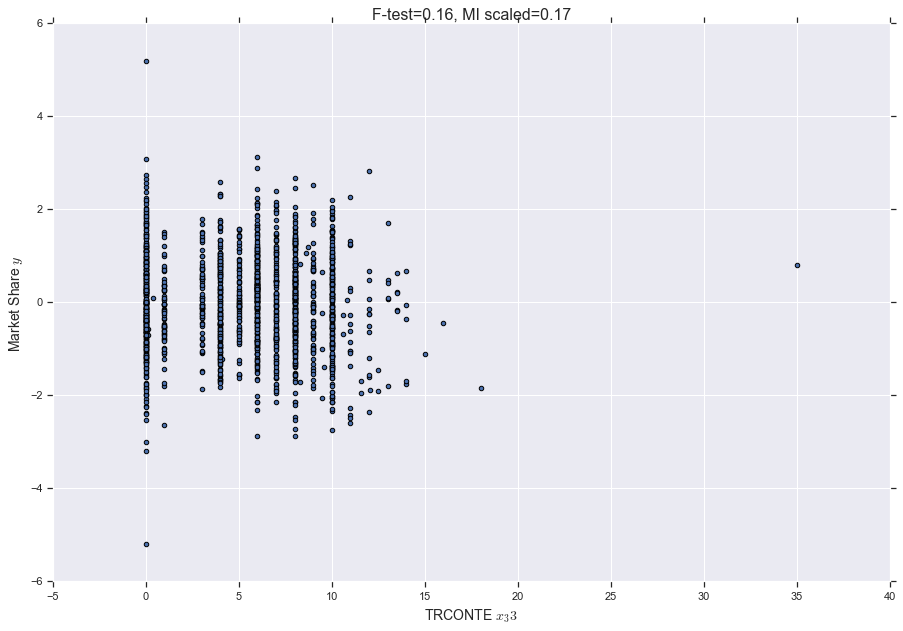

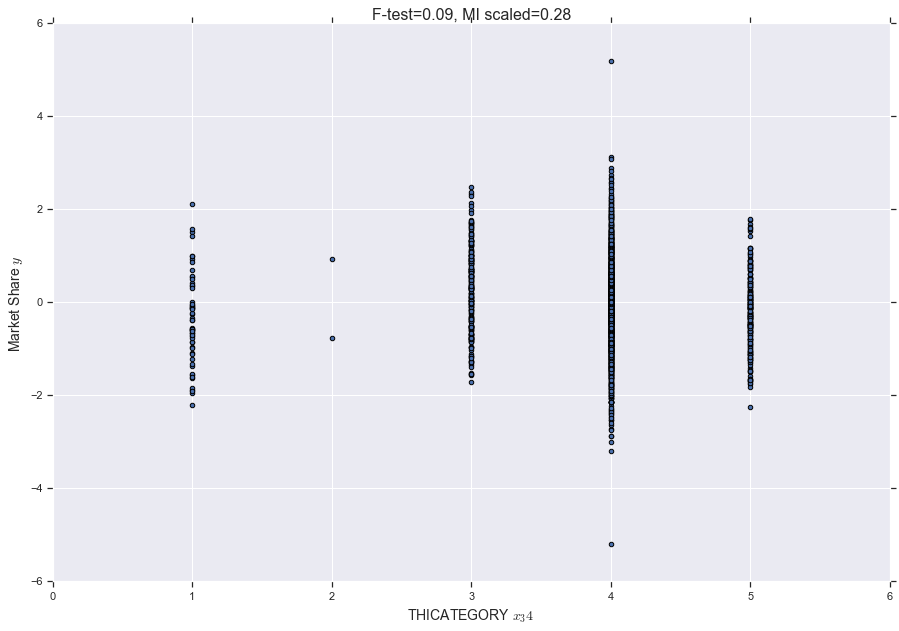

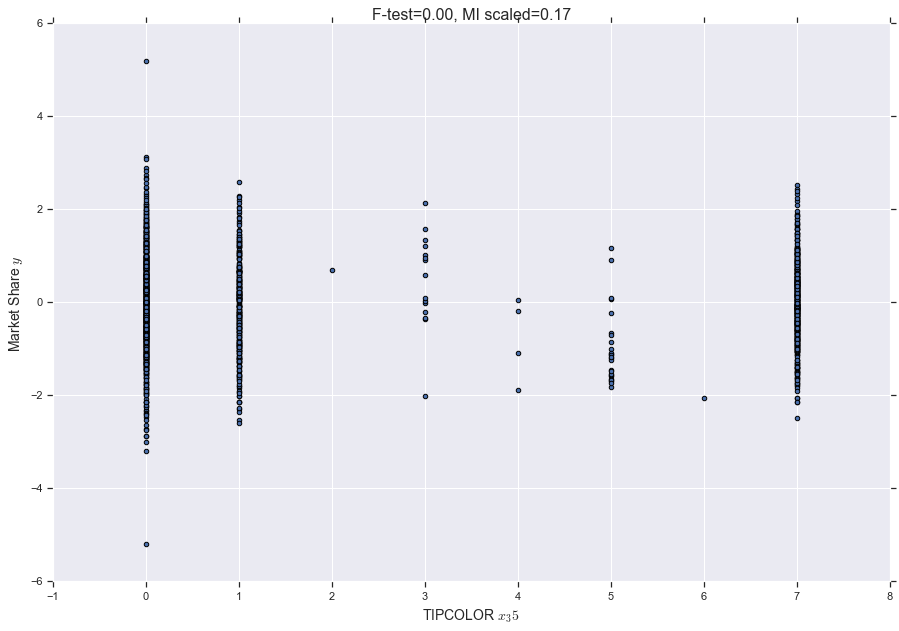

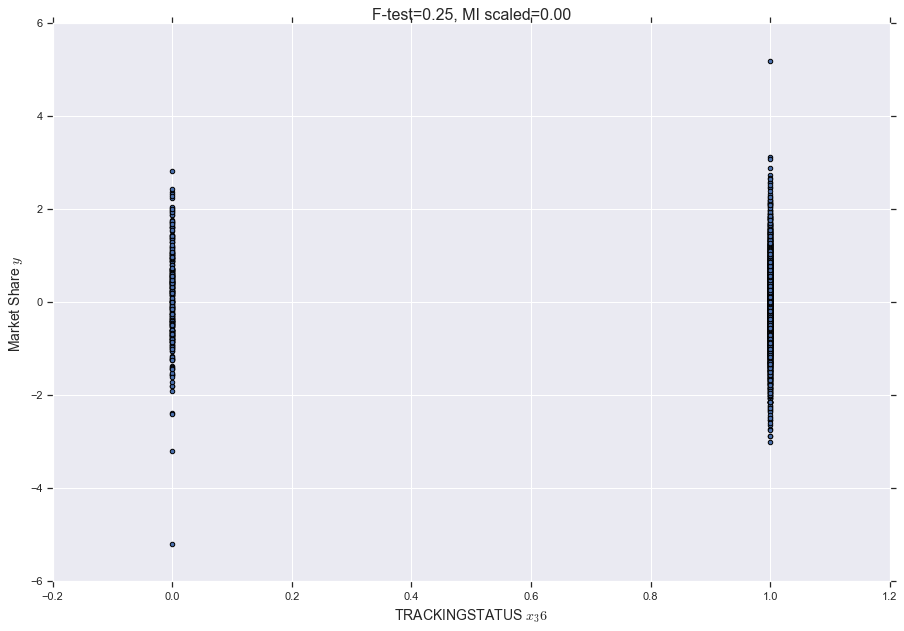

In [31]:
# Scatter plts for each fatures with f test and MI
from sklearn.feature_selection import f_regression, mutual_info_regression

np.random.seed(0)
num = len(df_var.columns) - 1

f_test, p = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

for i in range(num):
    plt.figure(figsize=(15, 10))
    plt.scatter(X[:, i], y, edgecolor='black', s=20)
    plt.xlabel(df_var.columns[i]+" $x_{}$".format(i + 1), fontsize=14)
    plt.ylabel("Market Share $y$", fontsize=14)
    plt.title("F-test={:.2f}, MI scaled={:.2f}".format(f_test[i], mi[i]),
              fontsize=16)
    plt.show()

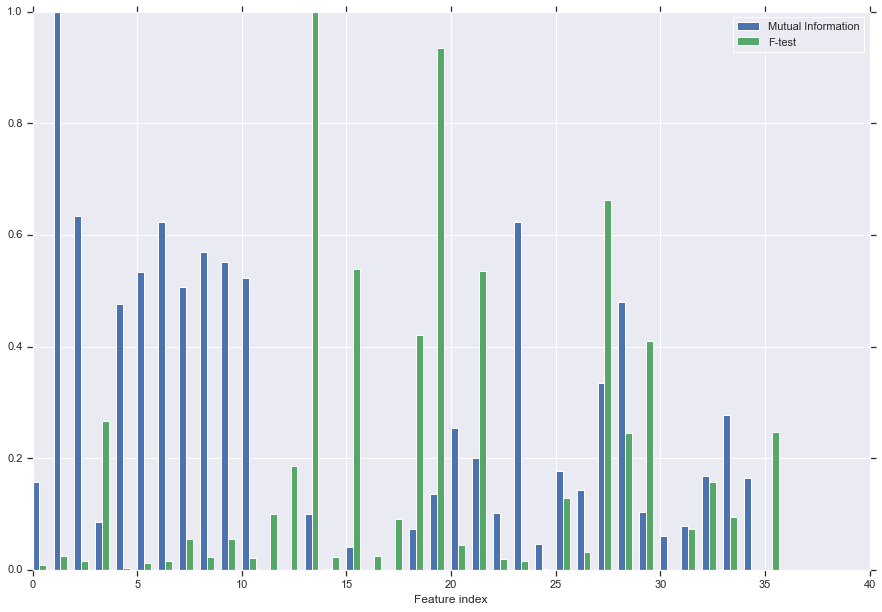

In [32]:
# Plot MI and f test on same graph
plt.figure(figsize=(15, 10))
ax1 = plt.bar(range(num), mi, color='b', width=0.33)
ax2 = plt.bar(np.array(range(num))+0.33, f_test, color='g', width=0.33)
plt.legend((ax1, ax2), ('Mutual Information', 'F-test'))
plt.xlabel('Feature index')
#plt.savefig('image/MI_ftest.jpg')
plt.show()

In [33]:
# We look fr features not rejecting null hypothesis
relevant = dict()
irrelevant = dict()
for i in range(len(f_test)):
    if f_test[i] < 0.05 and mi[i] < 0.05:
        irrelevant[df_var.columns[i]] = f_test[i]
    if p[i] < 0.05 :
        relevant[df_var.columns[i]] = f_test[i]
    if mi[i] > 0.8:
        relevant[df_var.columns[i]] = mi[i]
print('Irrelevant features: ', irrelevant)
print('\nHigh indicators: ', relevant)

Irrelevant features:  {'RTYPE': 0.023059731500219414, 'MINDICATOR': 0.0006734109358619891, 'ISSTRATEGIC': 0.024944655296652605}

High indicators:  {'PRICECLASS': 0.5352900926380019, 'PRICECLASSON': 0.4107178518039123, 'BRMID': 0.18526826893851903, 'LEN': 0.9349889768261974, 'INDICATOR': 1.0, 'PCKT': 0.2448918899105106, 'NPLLAUNCHYEAR': 0.6633814929166285, 'BLDIMAGE': 0.2671380990357336, 'TRACKINGSTATUS': 0.24778792659610147, 'NCON': 0.12838677151548766, 'MARKET': 1.0, 'TRCONTE': 0.15821324639855255, 'INTERNATIONALINDICATOR': 0.5387256789592106, 'ITEMSCODE': 0.42095579635949953}


Results suggest that the ISStrategic feature does not provide any information (f test and mi are null) and there is no transformation to apply.  

Now if we look at the correlation matrix and the data exploration we notice that BRM == MARKETEDBRAND == BRANDONMARKET BRANDSUBFAMILY == BRANDSUBFAMILYGROUPING with only less than 25  and 0 values that differs. We will only keep BRM to simplify the matrix.

In [34]:
# Remove irrelevant (or close to be) variables
df_rm = df_var.drop(['ISSTRATEGIC', 'MARKETEDBRAND', 'BRANDONMARKET', 'BRANDSUBFAMILYGROUPING', 'LEN'], axis=1)

With more investigation (see next plot) there is still room for improvement in preprocessing but given the time limit and the provided information, we will limit ourselves to this.

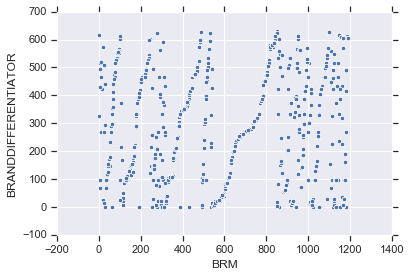

In [35]:
sns.scatterplot(x='BRM', y='BRANDDIFFERENTIATOR', data=df_rm)

### Standardization

In [36]:
# For scoring to allow lookup
#df_m = pd.concat([df_rm, df_sc], ignore_index=True)
#idx_train = len(df_rm)

In [37]:
# Use hashing function for high cardinality categorical features
df_hashed = df_rm.copy()
to_h = ['BRM', 'MARKET', 'BRANDDIFFERENTIATOR']

def h_cols(df_hashed, to_h, N):
    '''Hashing encode columns in dataframe'''
    h = ce.HashingEncoder()
    for col in to_h:
        df_hashed = h.hashing_trick(df_hashed, N=N, cols=[col])

        # Drop first to infer non colinearity
        df_hashed = df_hashed.drop('col_0', axis=1)

        # Rename columns
        for i in range(1, N):
            df_hashed = df_hashed.rename(columns={'col_'+str(i): col+str(i)})
    return df_hashed
df_hashed = h_cols(df_hashed, to_h, 8)

In [38]:
from sklearn import preprocessing

# Min max scaling for uniformly dist variables
df_scaled = df_hashed.copy()
scaler = preprocessing.MinMaxScaler()
df_scaled[['ITEMSCODE']] = scaler.fit_transform(df_scaled[['ITEMSCODE']])
df_scaled[['NPLMONTH']] = scaler.fit_transform(df_scaled[['NPLMONTH']])

# Normalizer for normally distributed variables
scaler = preprocessing.RobustScaler()
df_scaled[['NCON', 'TRCONTE']] = scaler.fit_transform(df_scaled[['NCON', 'TRCONTE']])

In [39]:
# Encode sub brand families with 1 (differ from main brand) or 0 (same as brand)
def subDif(row):
    brand = row['BRANDFAMILY']
    if brand == row['BRANDSUBFAMILY']:
        row['BRANDSUBFAMILY'] = 0
    else:
        row['BRANDSUBFAMILY'] = 1
    if brand == row['BRANDSUBFAMILYGROUP']:
        row['BRANDSUBFAMILYGROUP'] = 0
    else:
        row['BRANDSUBFAMILYGROUP'] = 1
    if brand == row['BRANDSUBFAMILYLINE']:
        row['BRANDSUBFAMILYLINE'] = 0
    else:
        row['BRANDSUBFAMILYLINE'] = 1
    return row

# Apply transformation
df_scaled = df_scaled.apply(subDif, axis=1)

# Hash encode Brand Family
df_scaled = h_cols(df_scaled, ['BRANDFAMILY'], 8)

In [40]:
# Variables to apply one hot encoding
col_one_hot = ['REGION', 'BLDIMAGE', 'INDICATOR', 'RTYPE', 'PRICECLASS','PRICECLASSON', 'INTERNATIONALINDICATOR',
               'NPLLAUNCHYEAR', 'LENCATEGORY', 'LOCALCLASS', 'PCKT', 'TCLASS', 'SPECIALFLAVOR', 'THICATEGORY', 'TIPCOLOR']

for col in col_one_hot:    
    # Apply one hot encoded
    df_col_enc = pd.get_dummies(df_scaled[col], prefix=col, prefix_sep='', drop_first=True)
    
    # drop original variable
    df_scaled = df_scaled.drop(col, axis=1)
    df_scaled = pd.concat([df_scaled, df_col_enc], axis=1)

In [41]:
# For scoring
#df_score_processed = df_scaled[idx_train:]
#df_score_processed = df_score_processed.reindex()

In [42]:
# Split variables and labels
X = df_scaled.drop('Market_Share', axis=1).as_matrix()
y = df_scaled['Market_Share']

C:\Users\Louis\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [43]:
# Kruskal wallis since the dependent variable is skewed
statistics = []
kruskal = []
for i in range(len(X[0, :])):
    statistics.append(stats.kruskal(X[:,i], y))
    kruskal.append(stats.kruskal(X[:,i], y).statistic)
    
# List features not rejecting null hypothesis
for i, statistic in enumerate(statistics):
    if statistic.pvalue > 0.05:
        print(df_scaled.columns[i], statistic.statistic, statistic.pvalue)

BRANDSUBFAMILYGROUP 0.9493954497378322 0.3298732281213016
PCKT28 0.7350717312220044 0.391244166458229


In [44]:
# Assess top components wiht PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
X_reduced = pca.fit_transform(X)

<Container object of 130 artists>

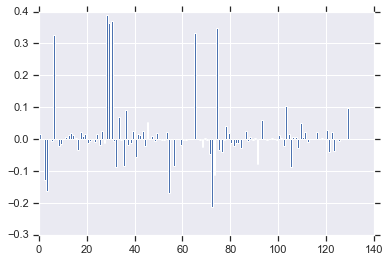

In [45]:
plt.bar(range(len(pca.components_[0])), pca.components_[0])

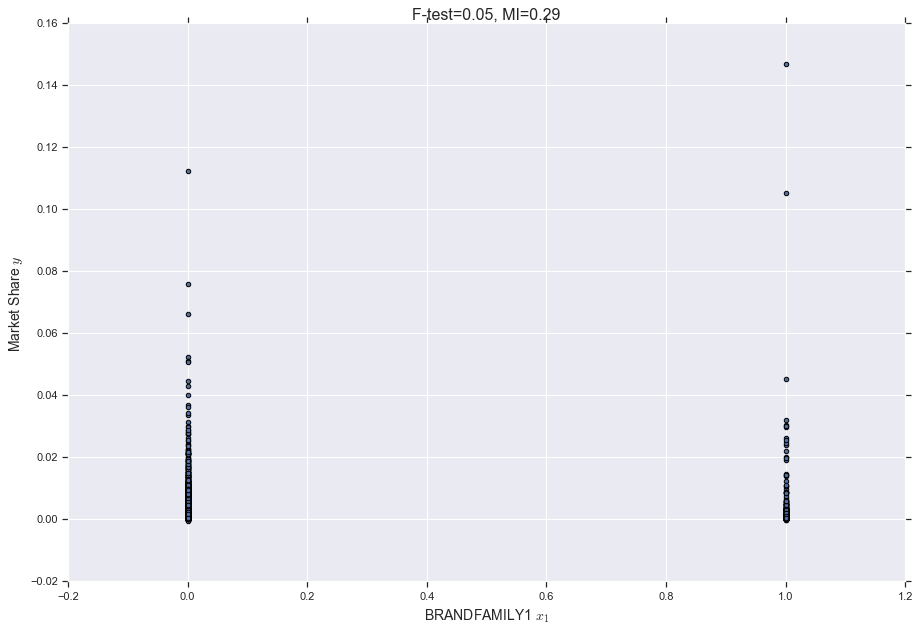

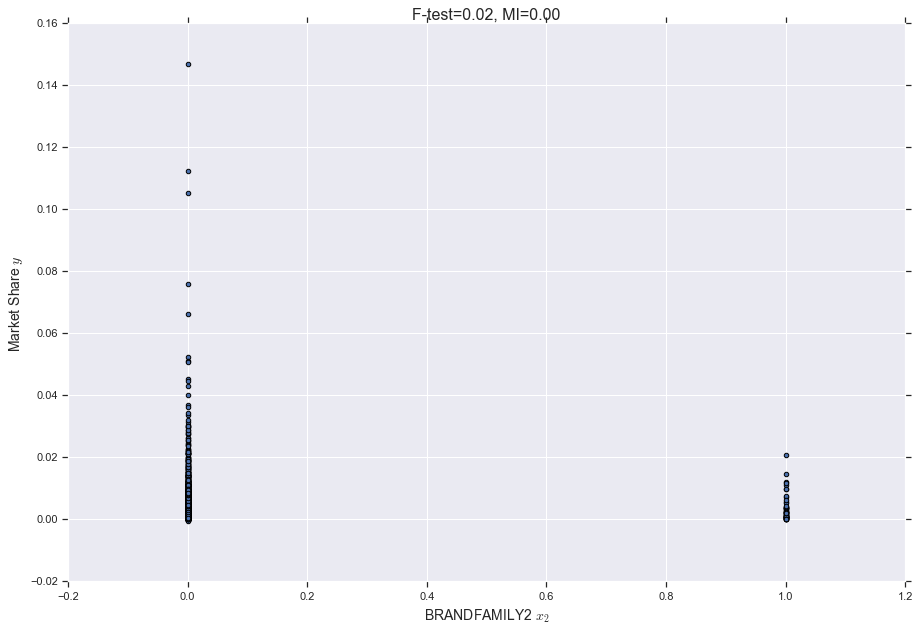

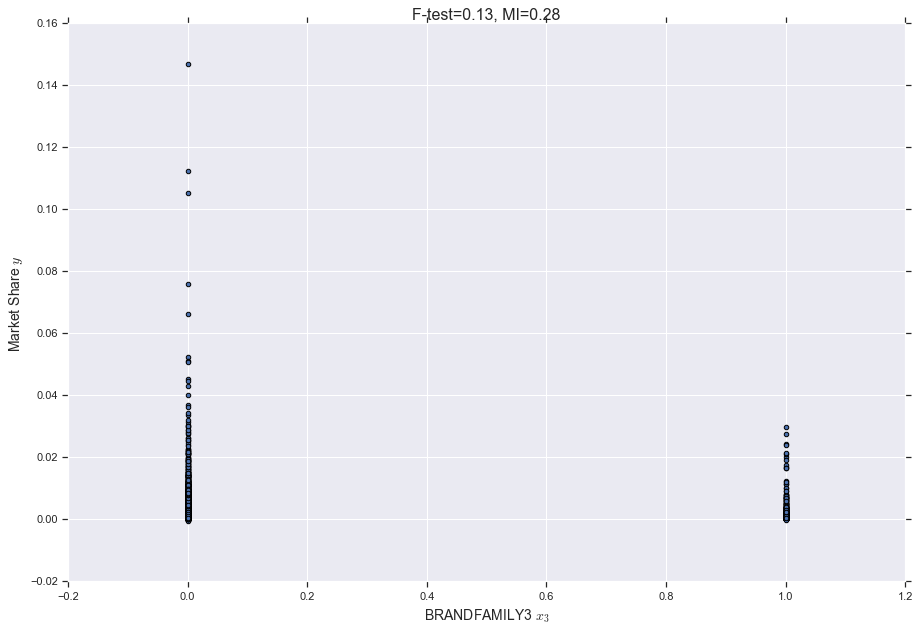

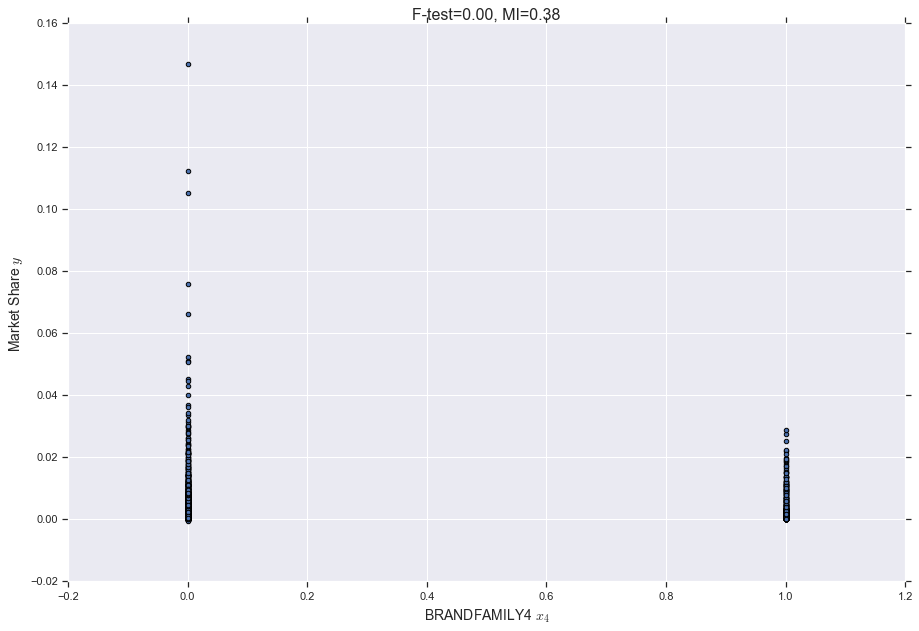

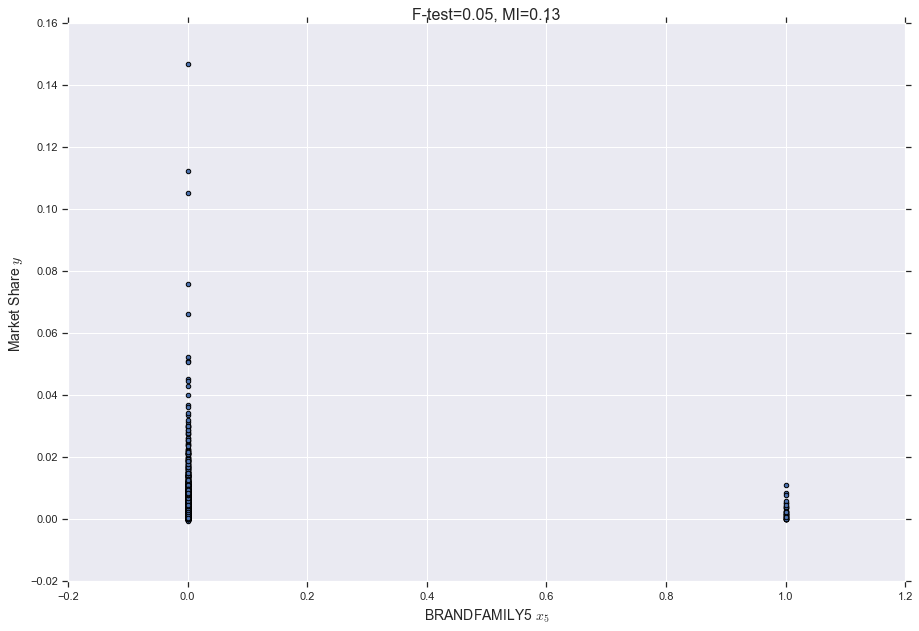

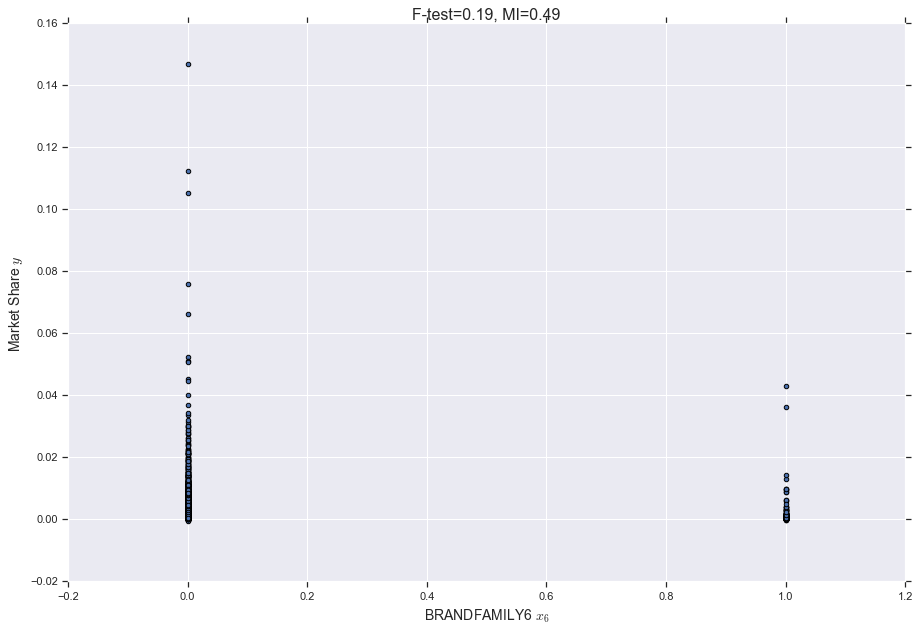

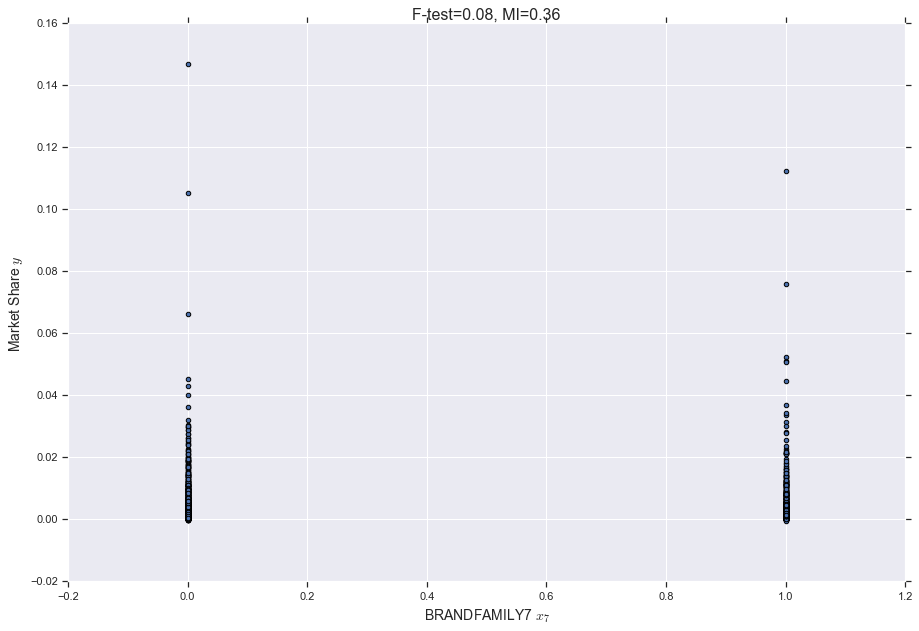

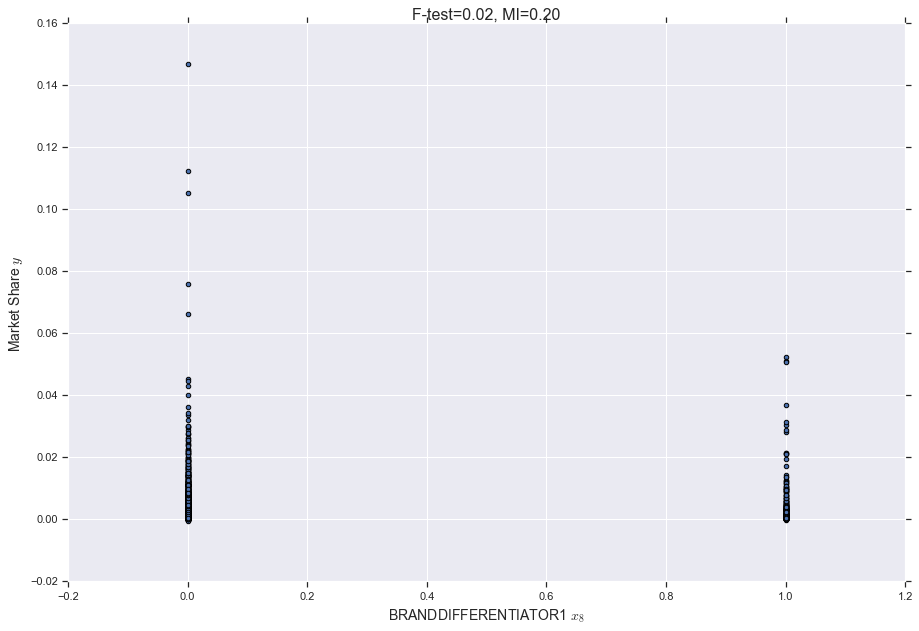

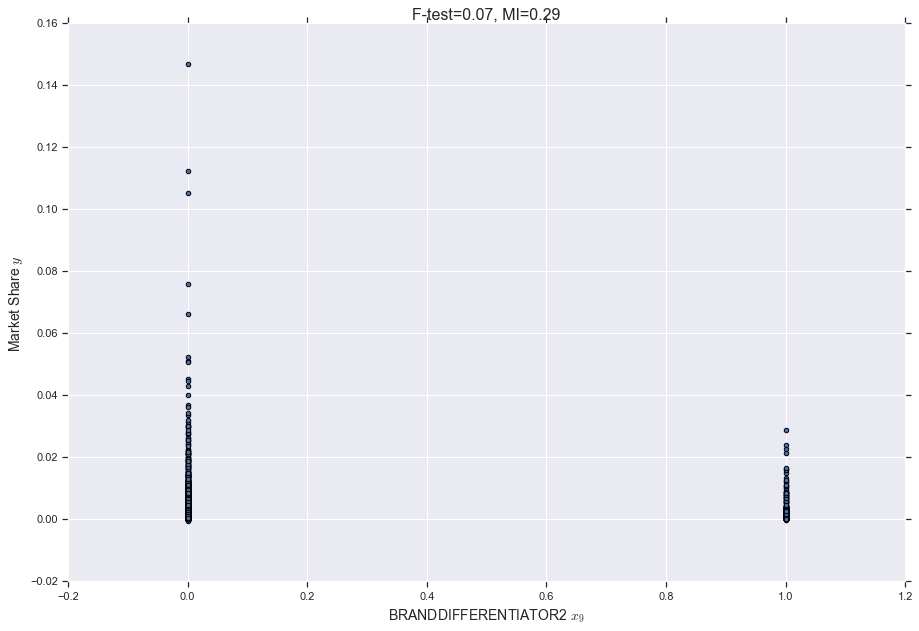

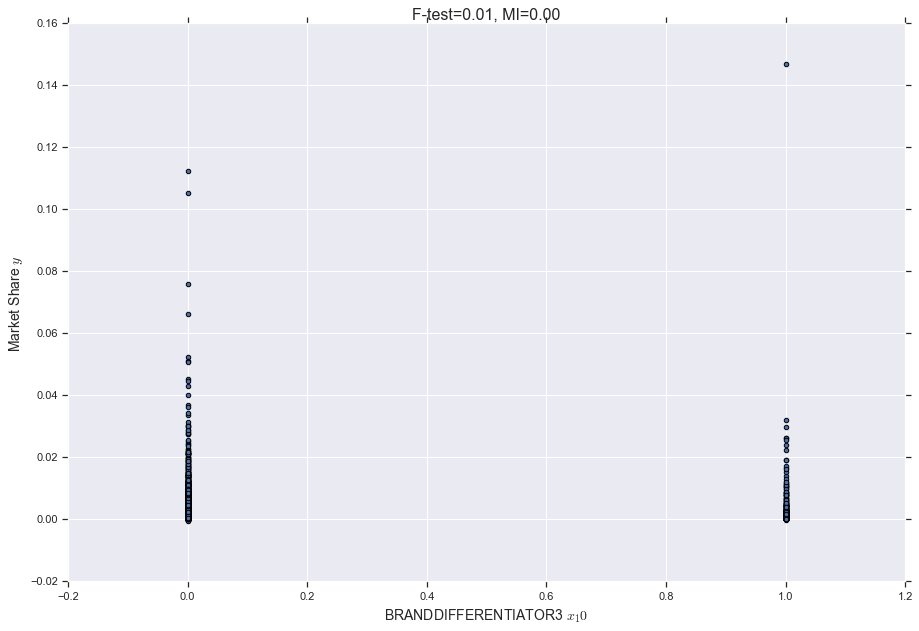

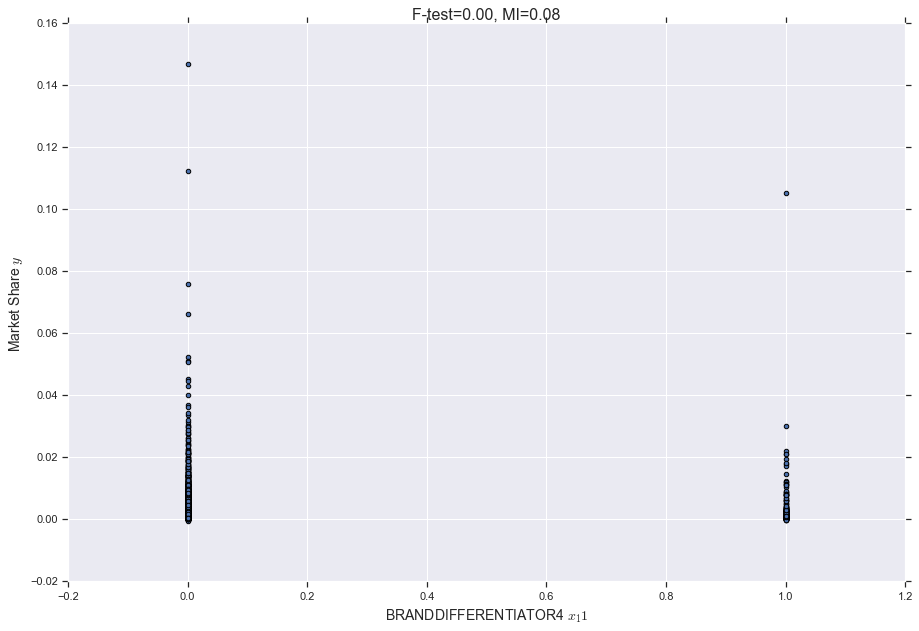

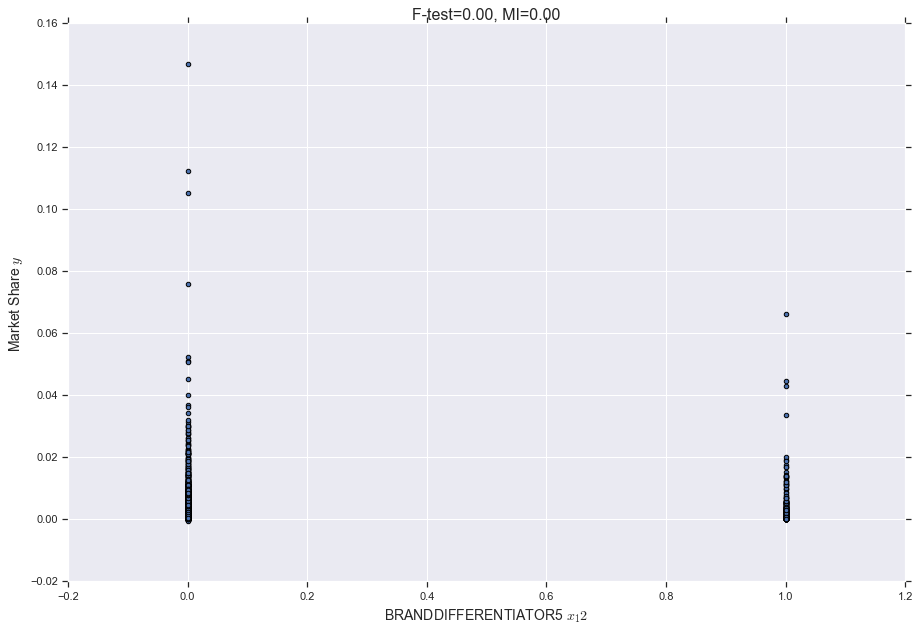

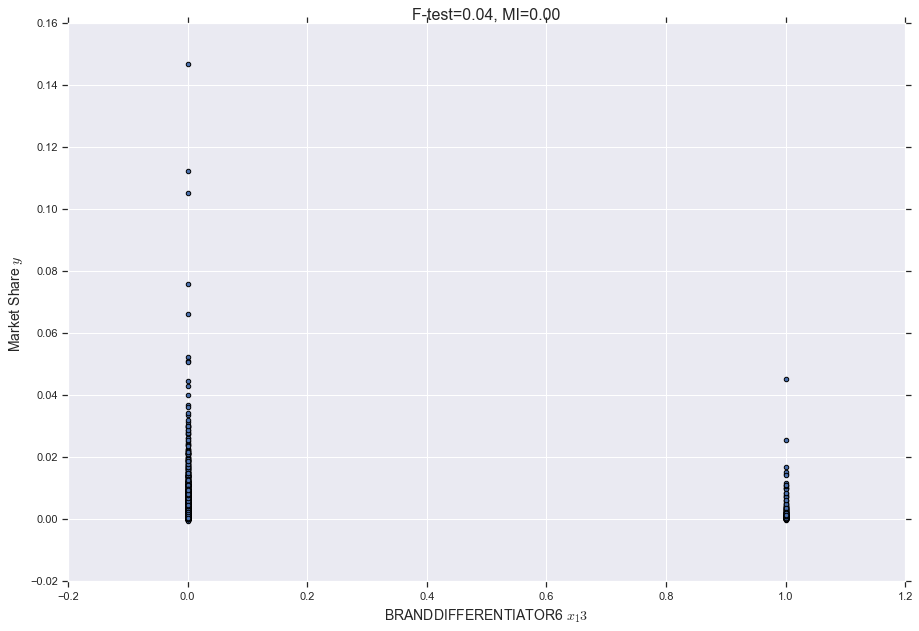

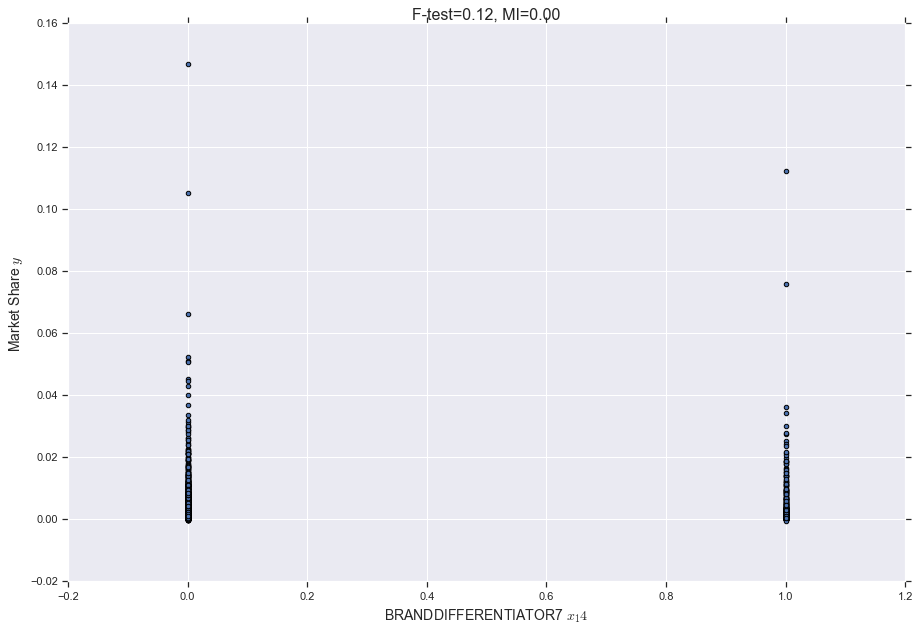

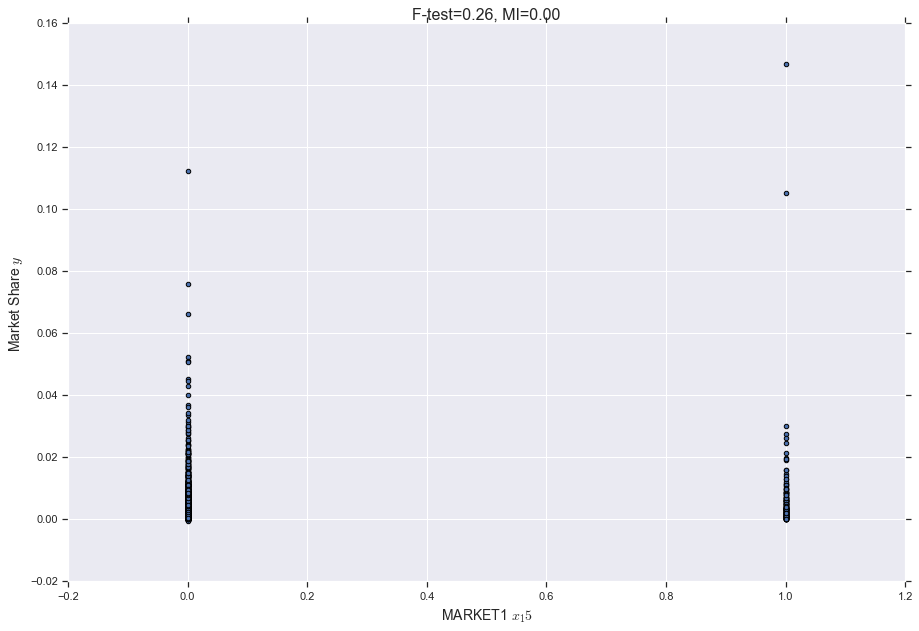

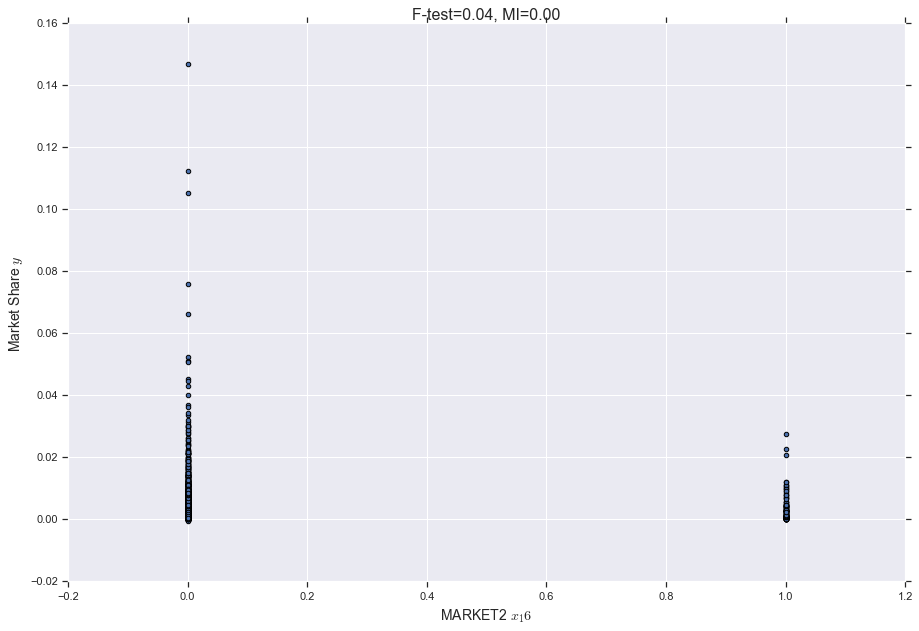

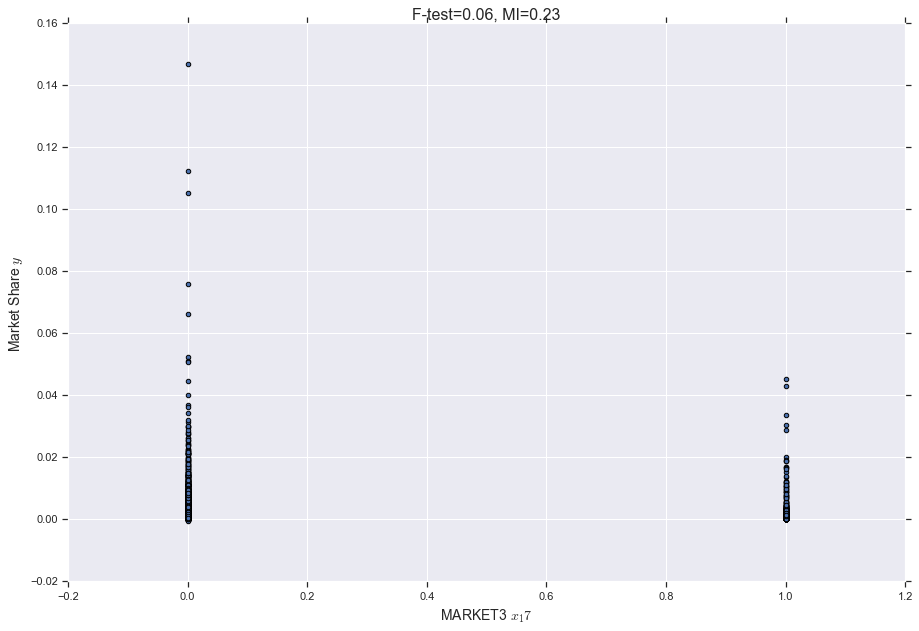

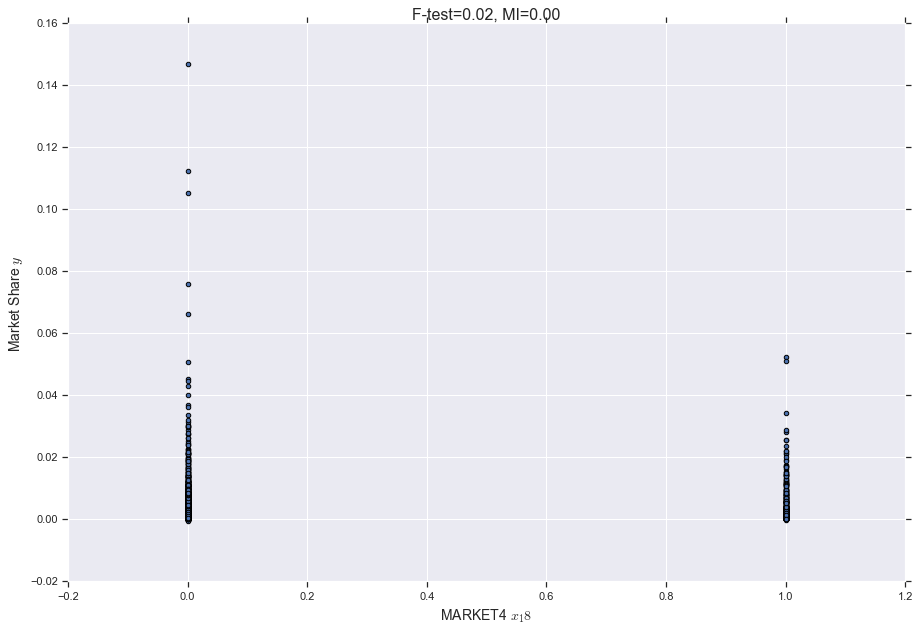

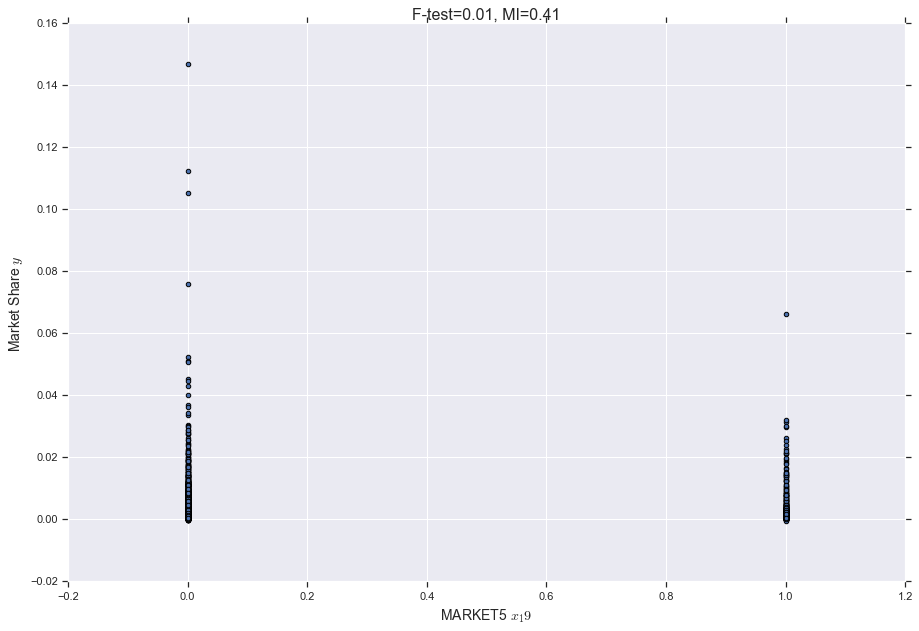

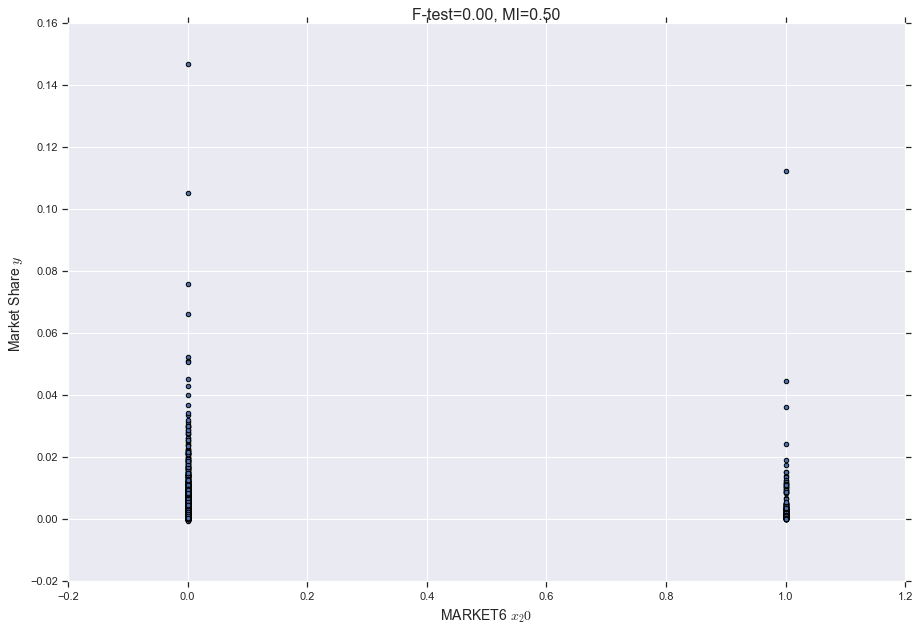

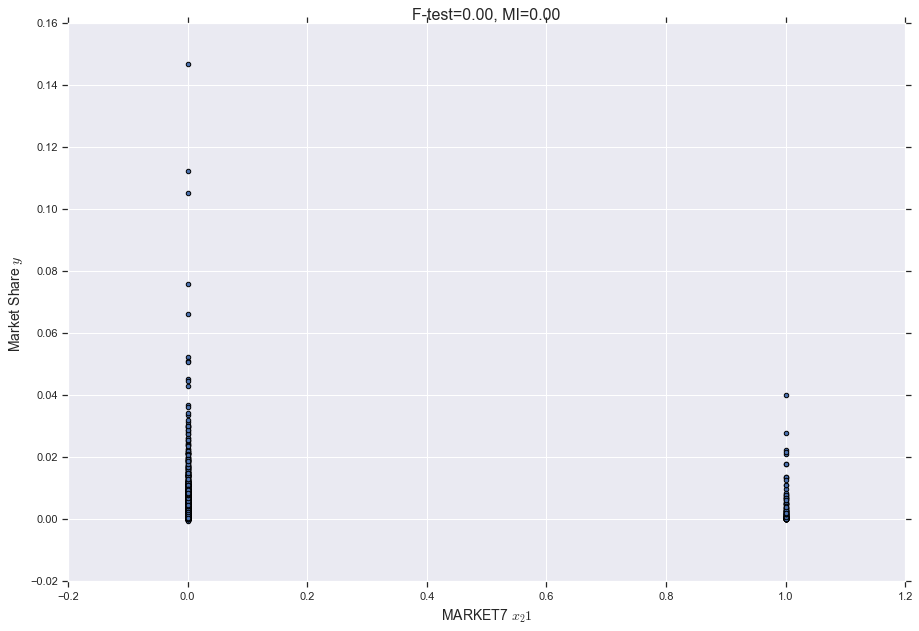

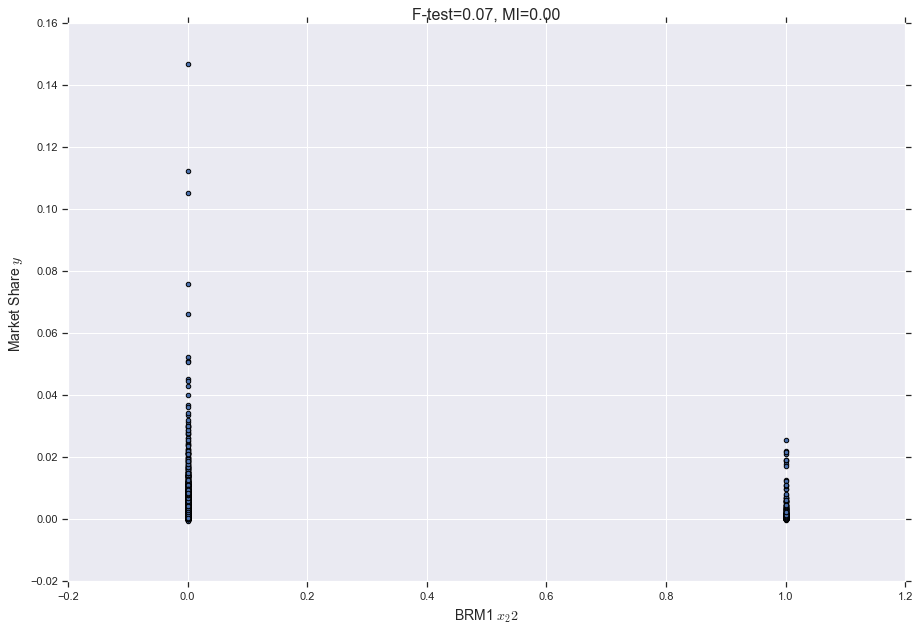

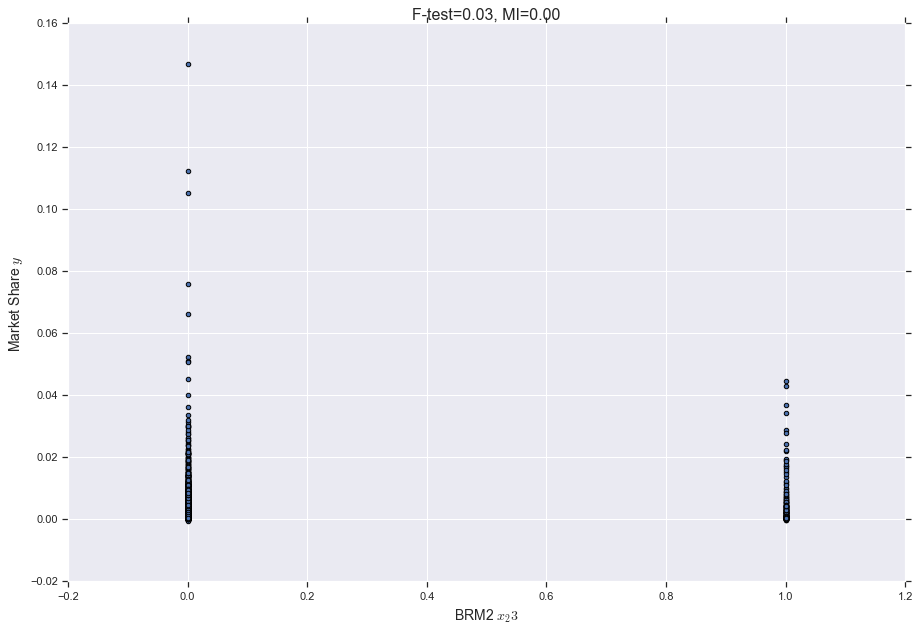

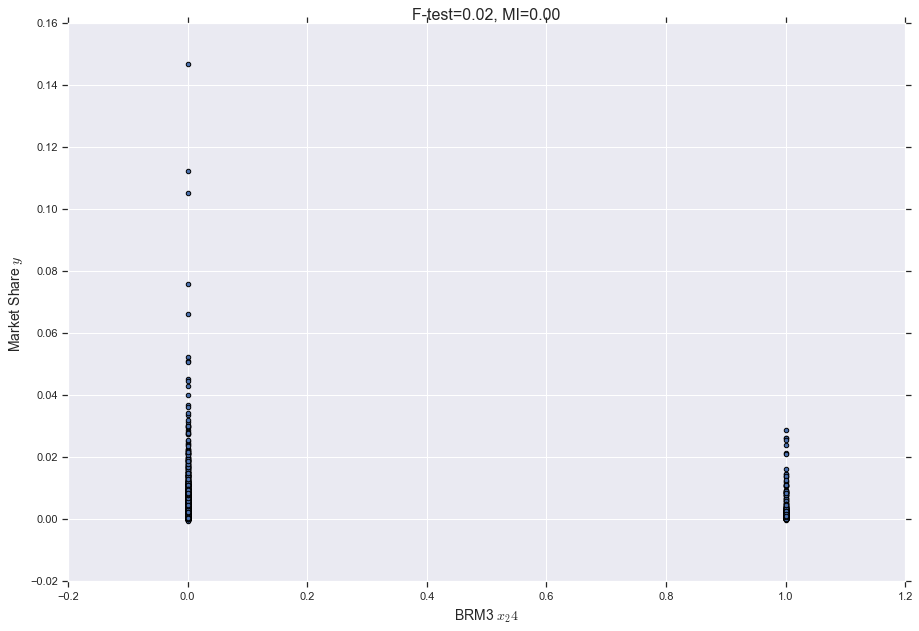

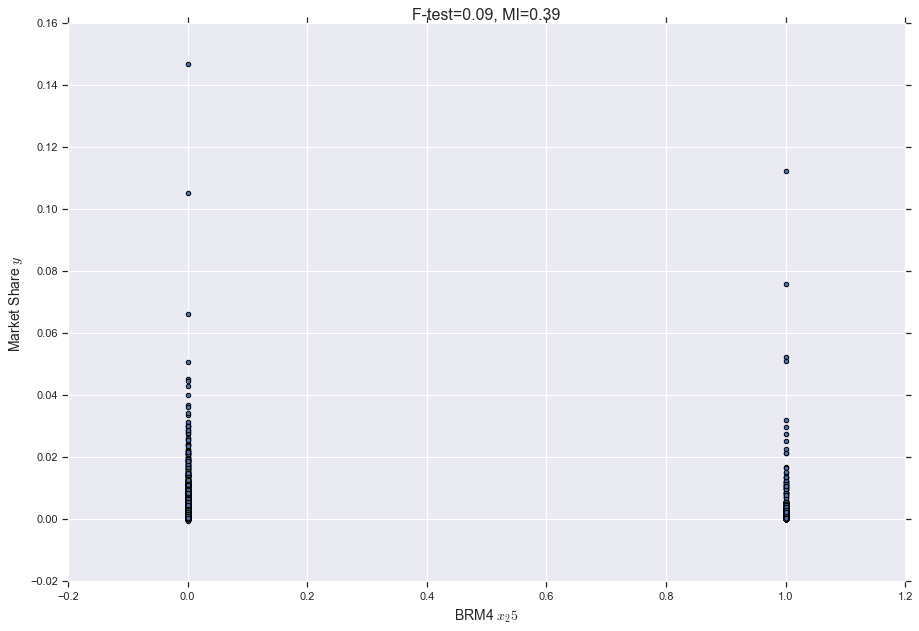

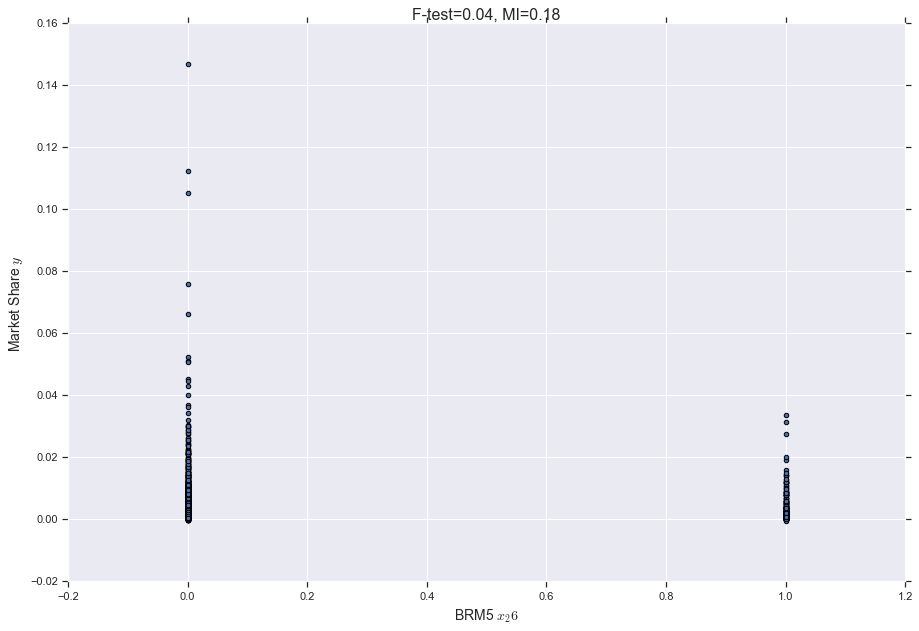

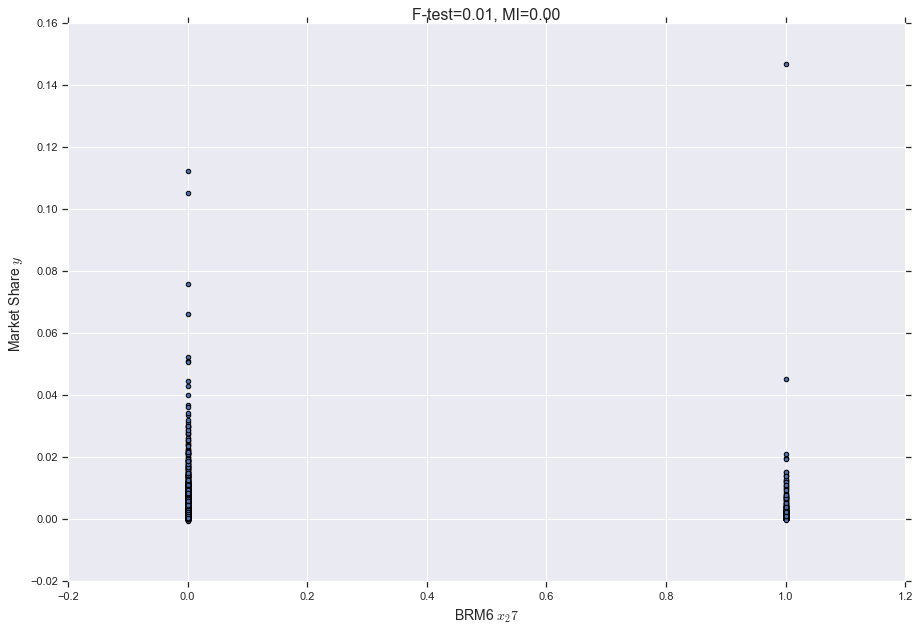

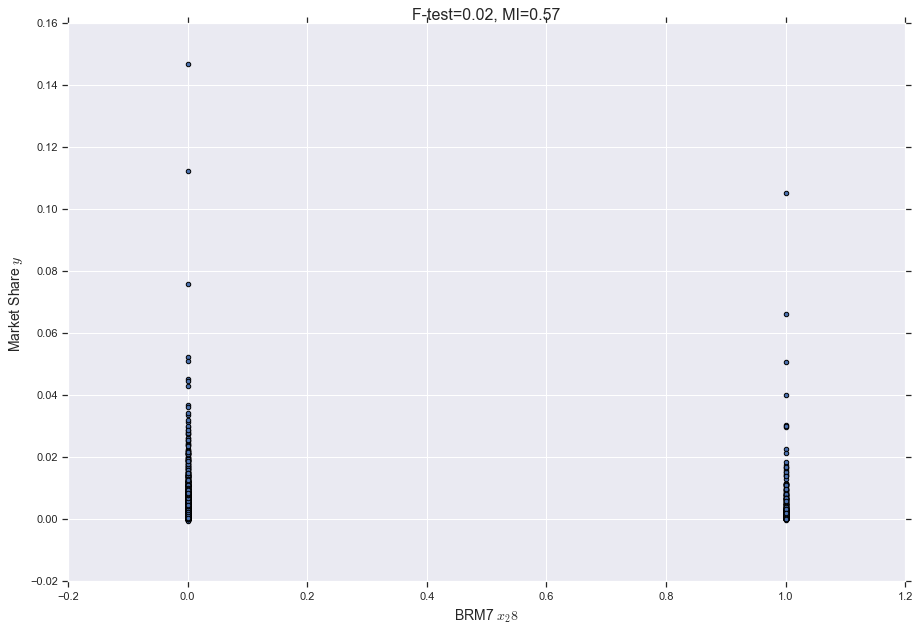

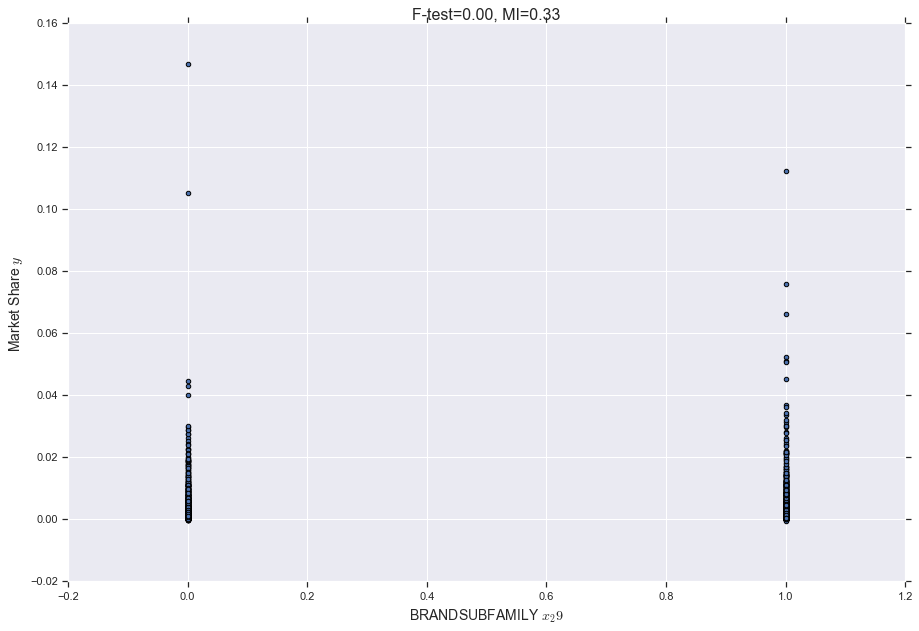

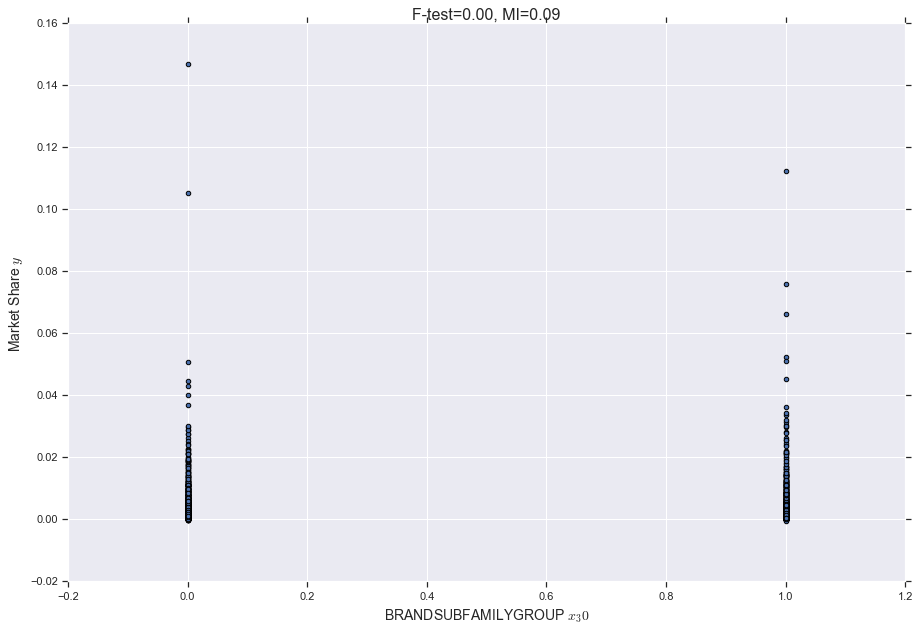

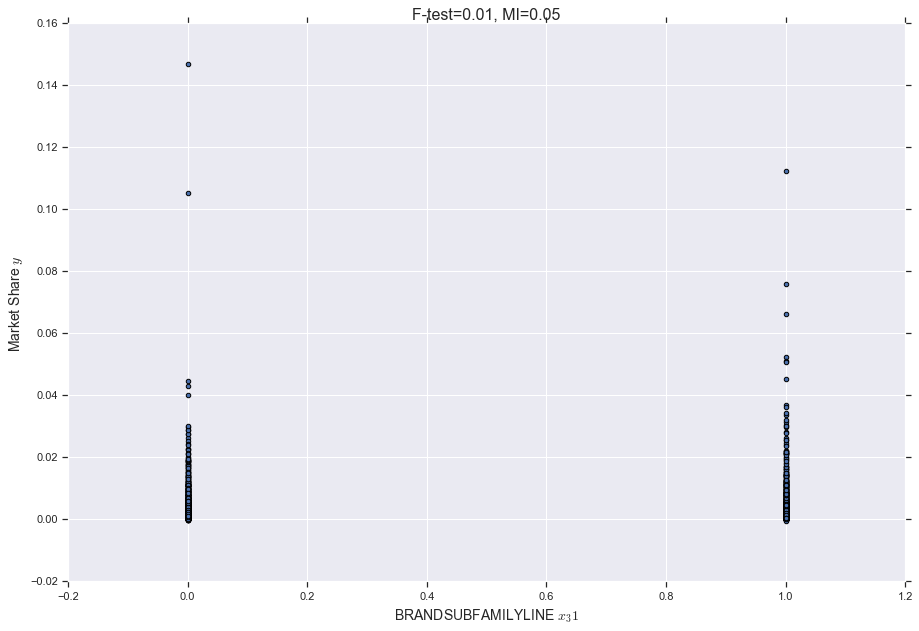

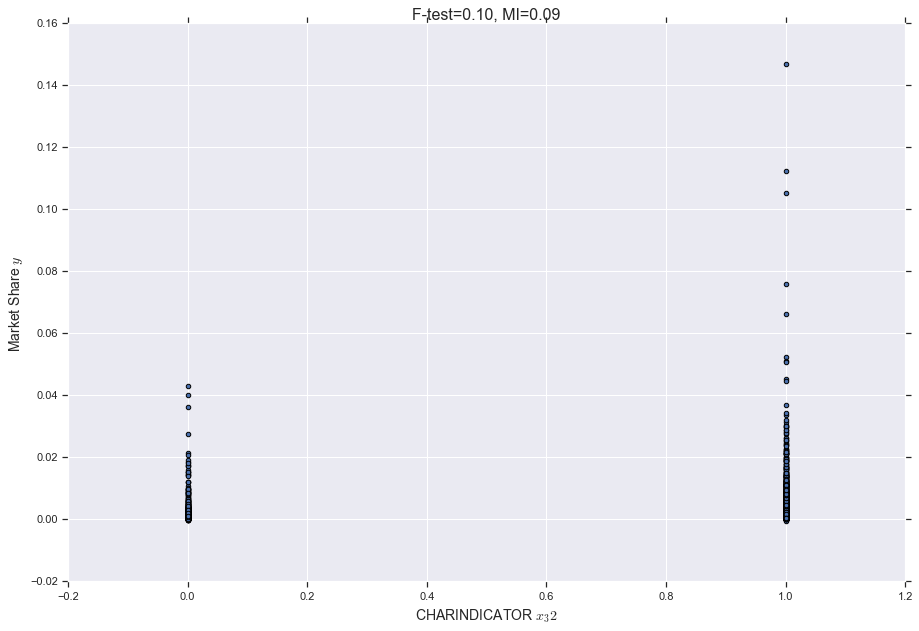

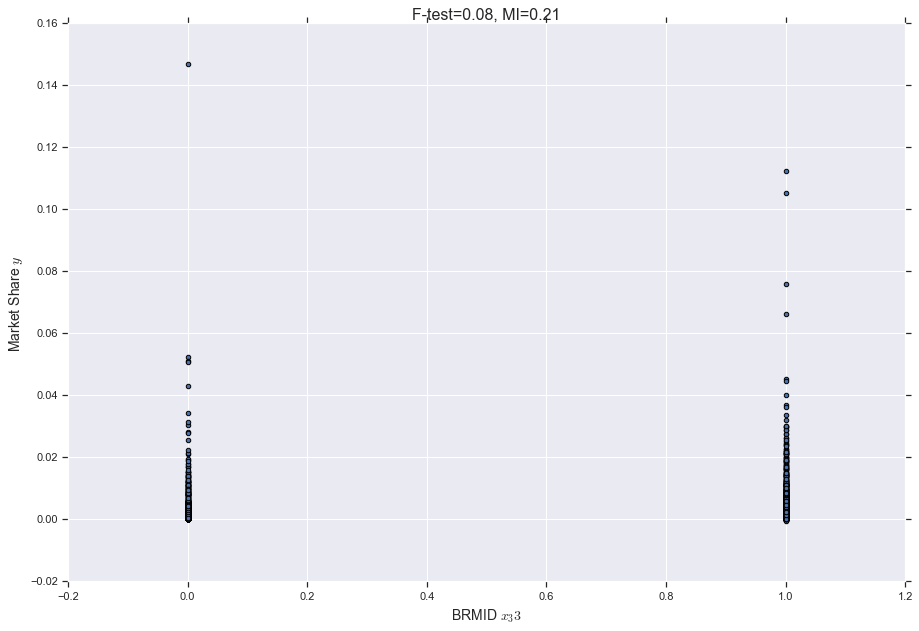

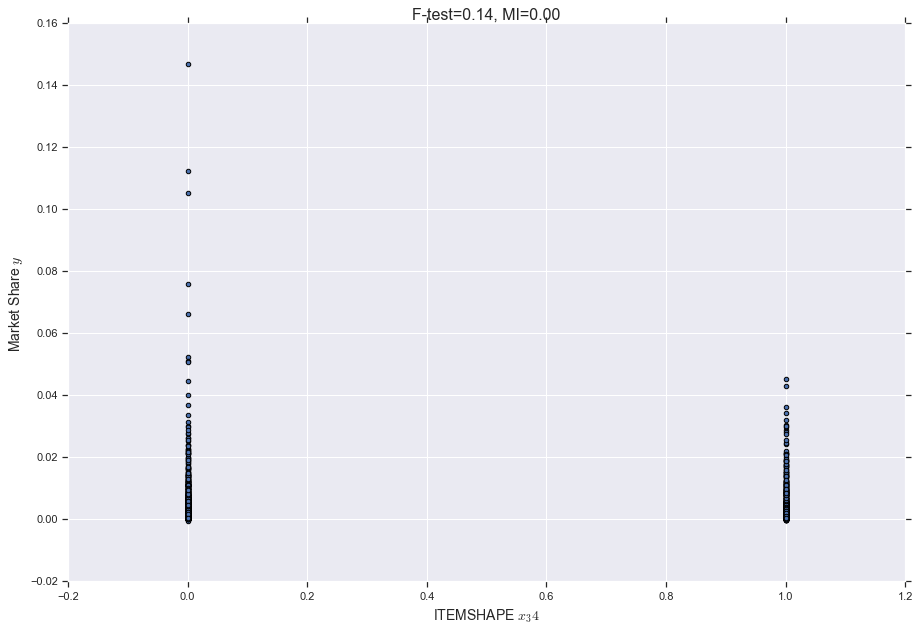

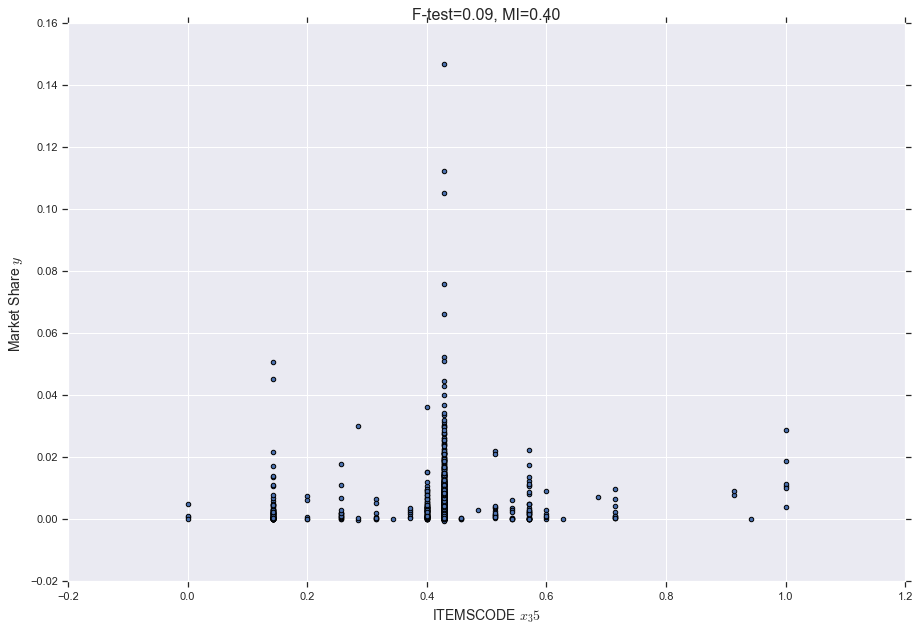

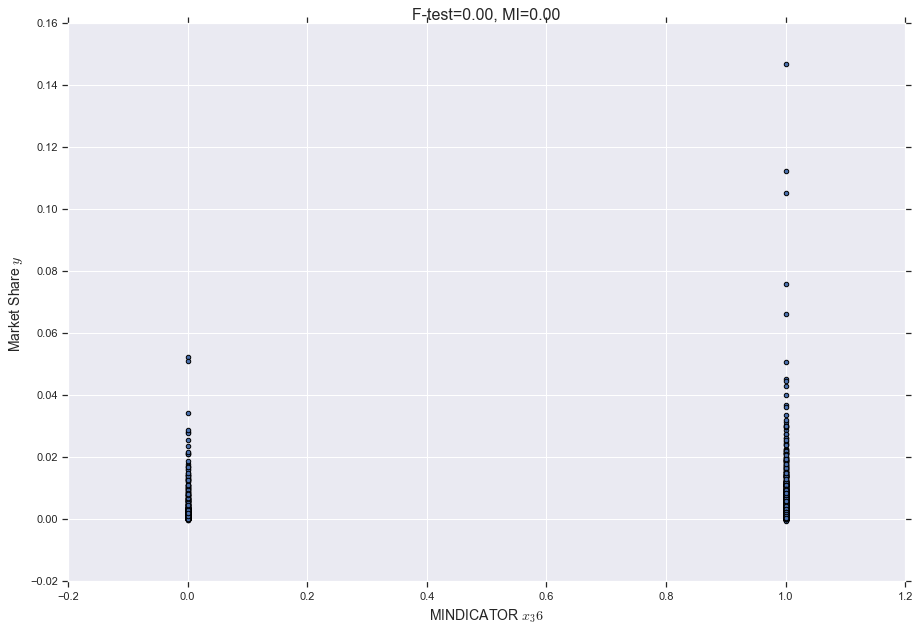

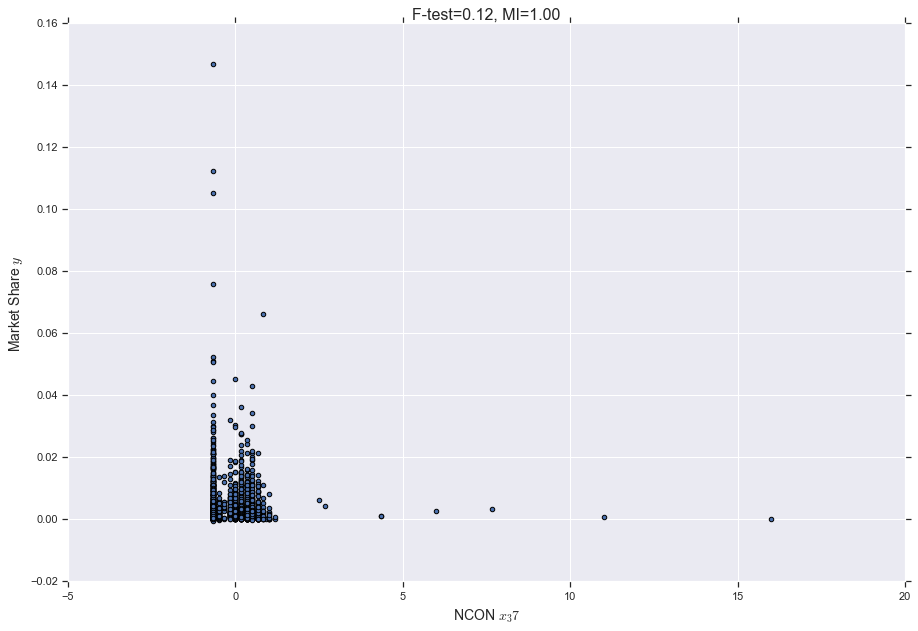

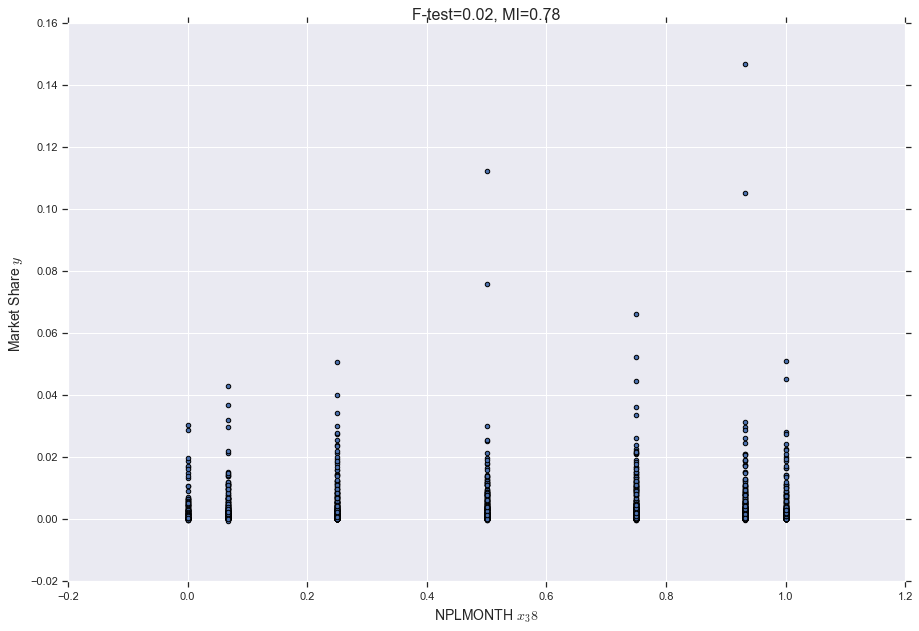

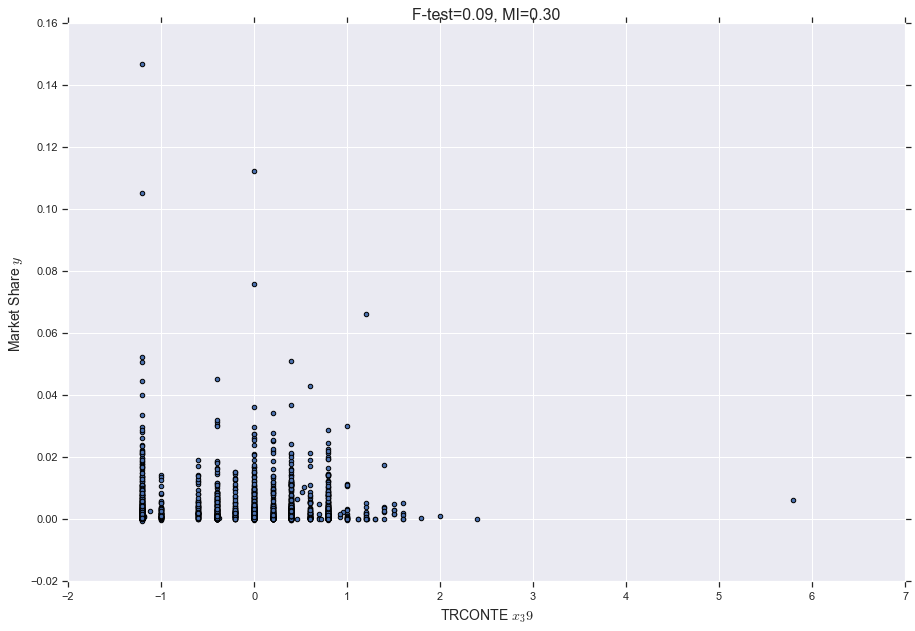

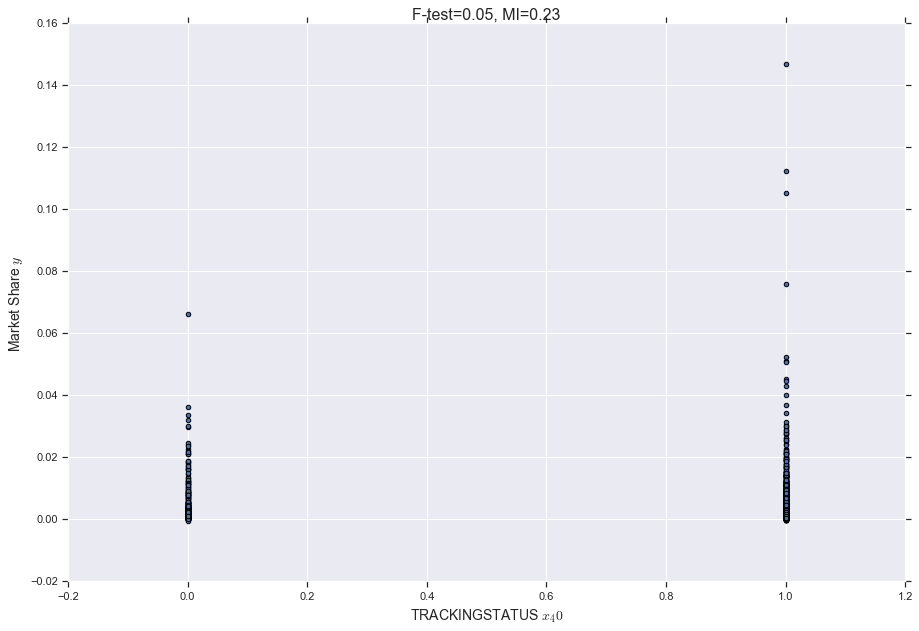

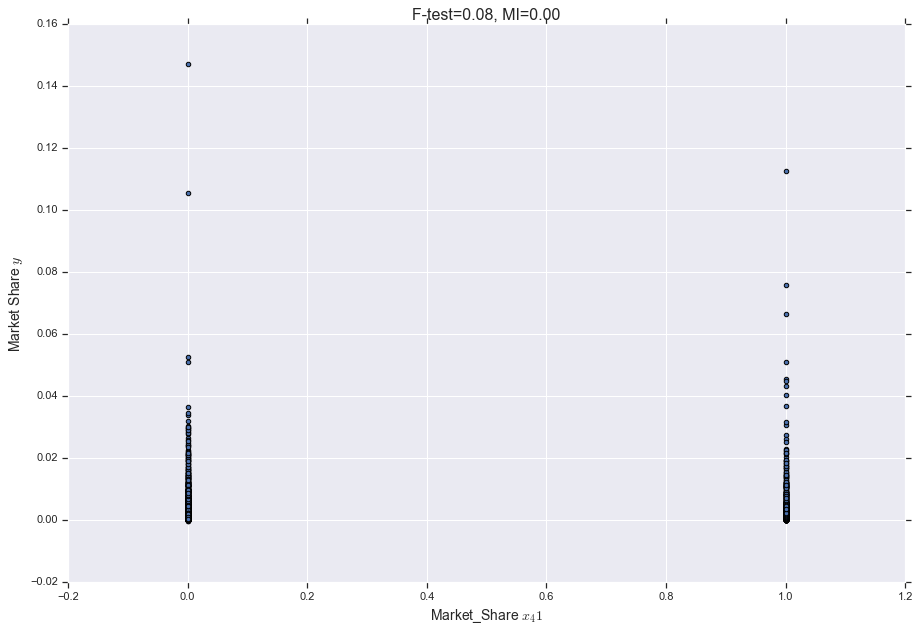

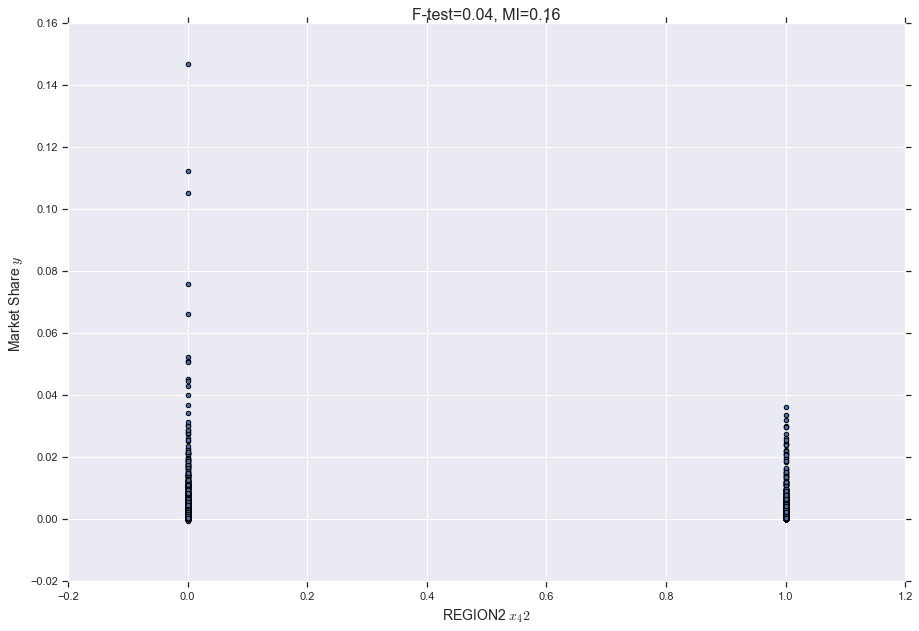

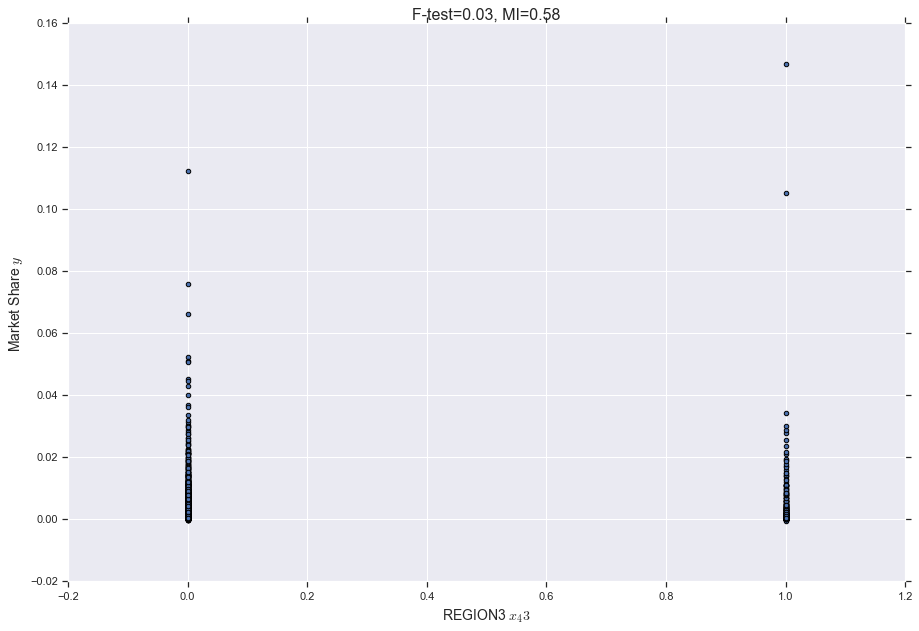

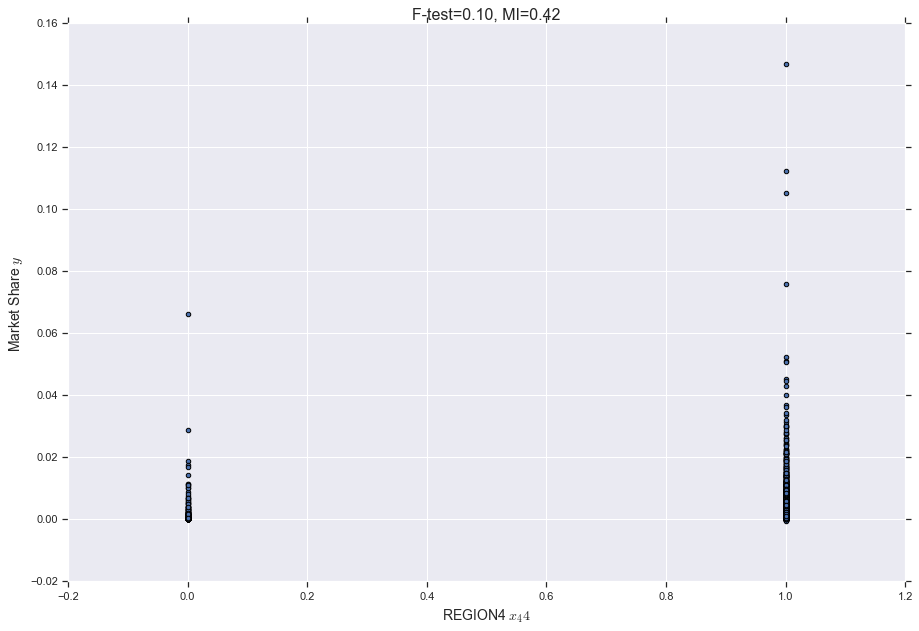

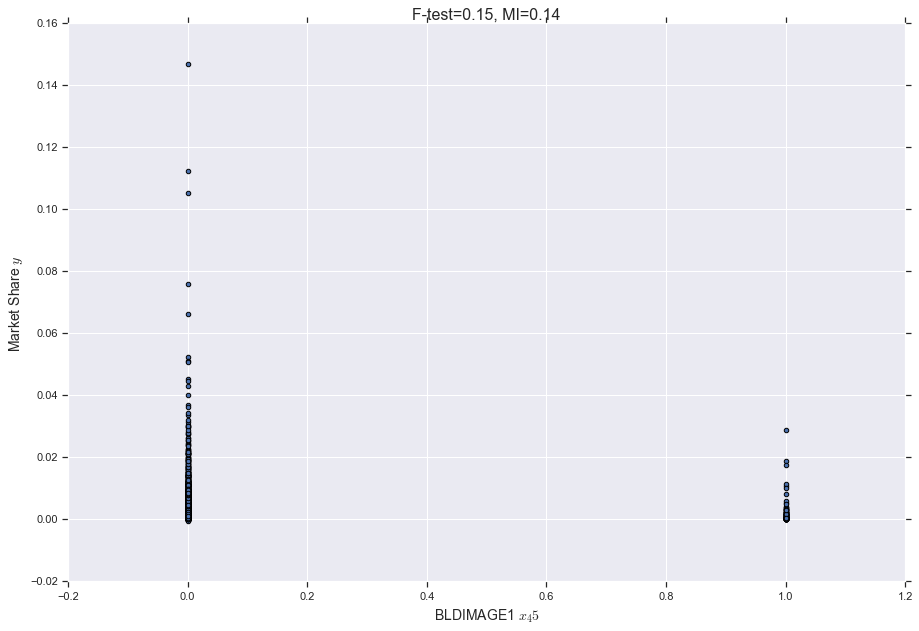

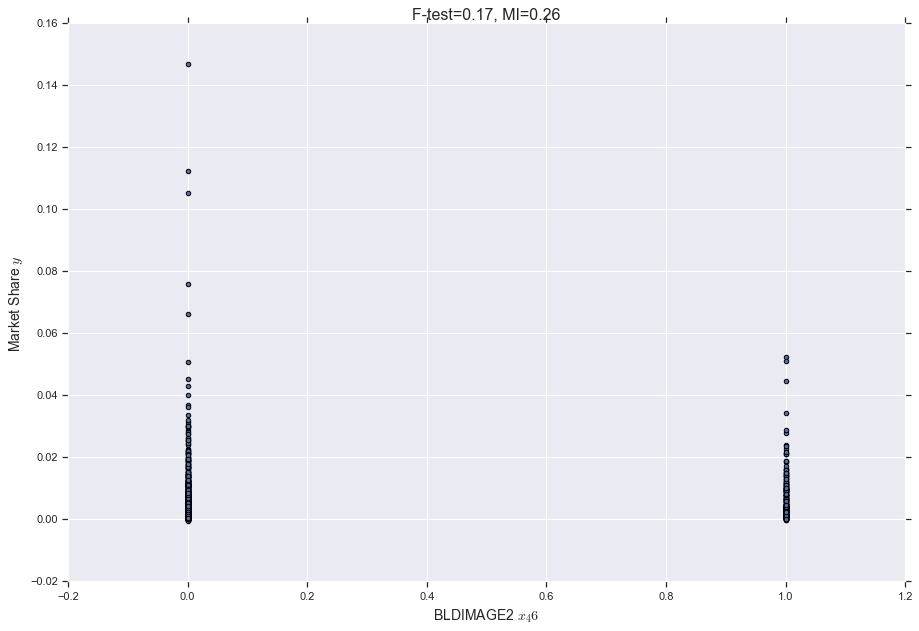

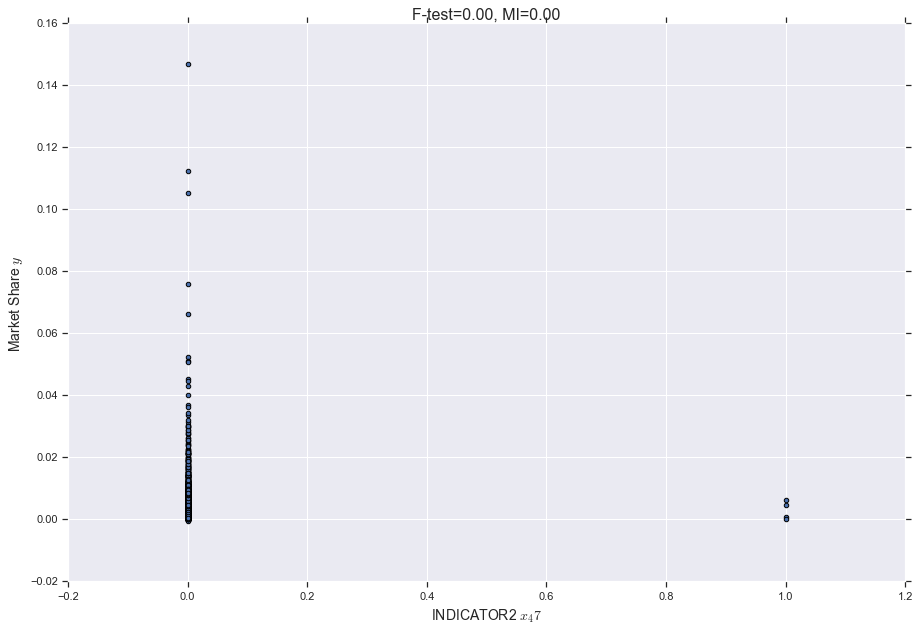

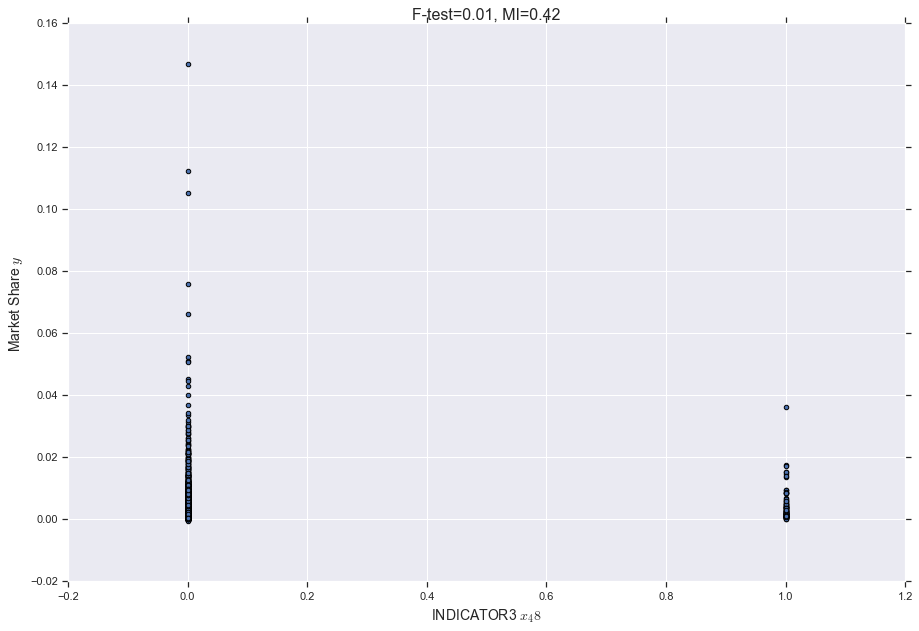

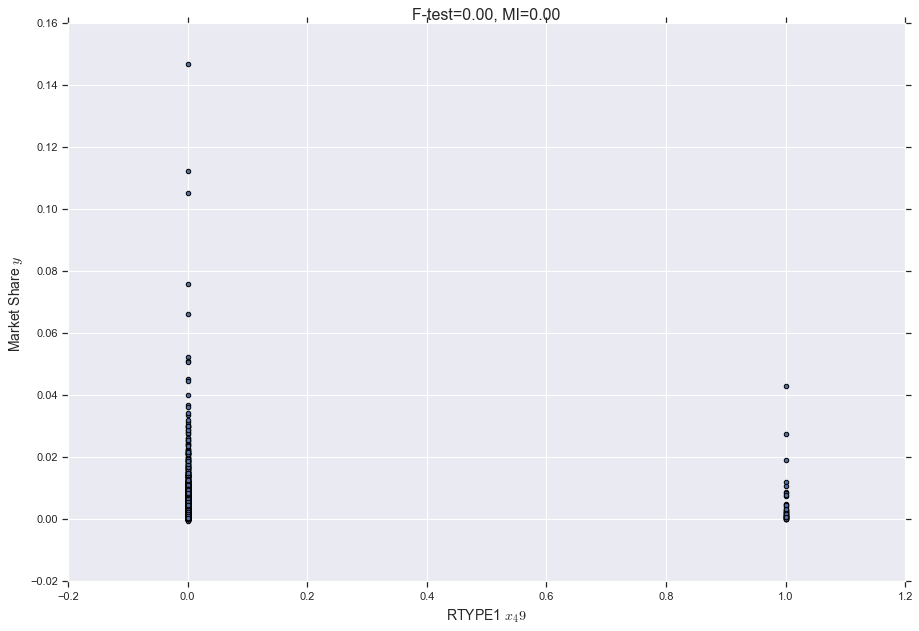

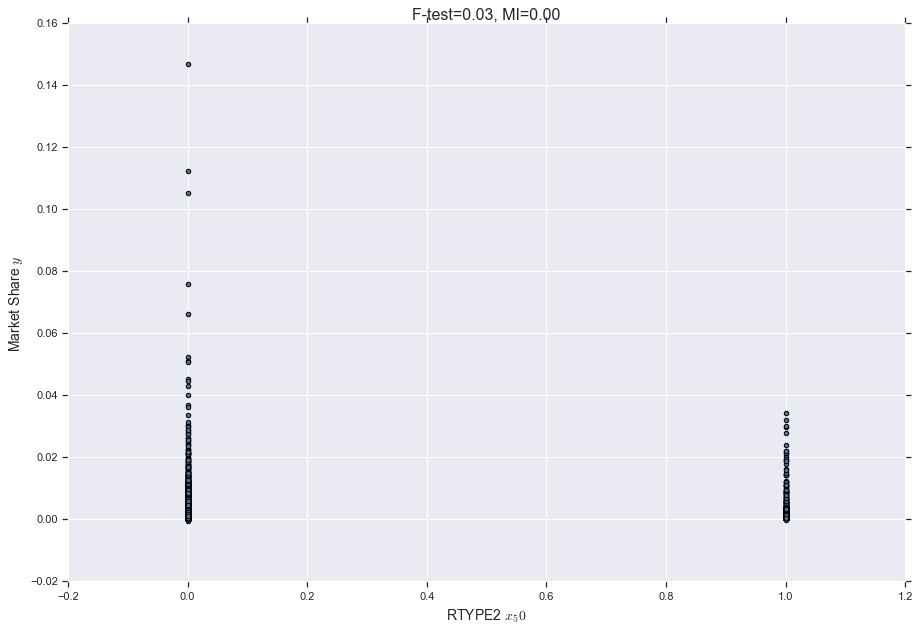

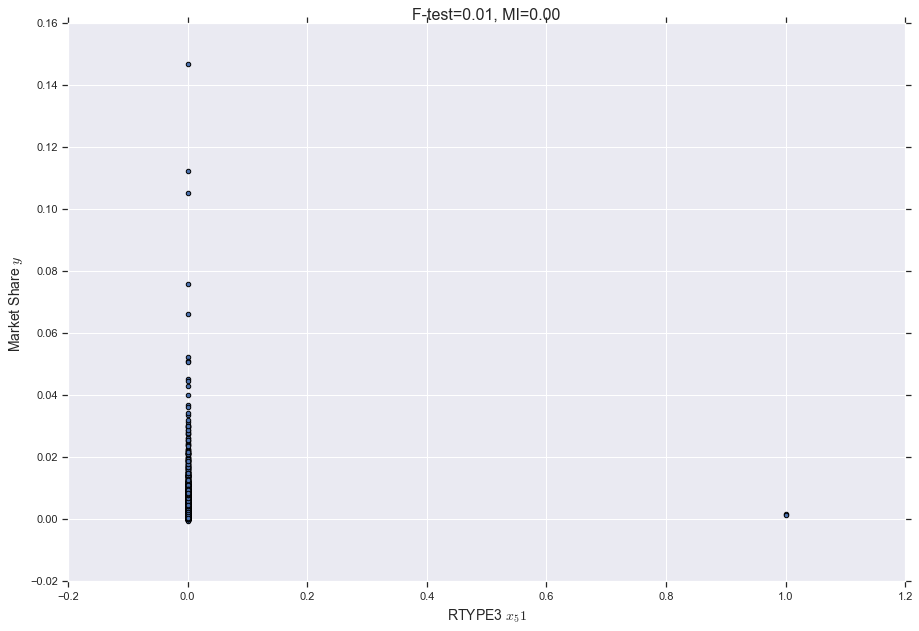

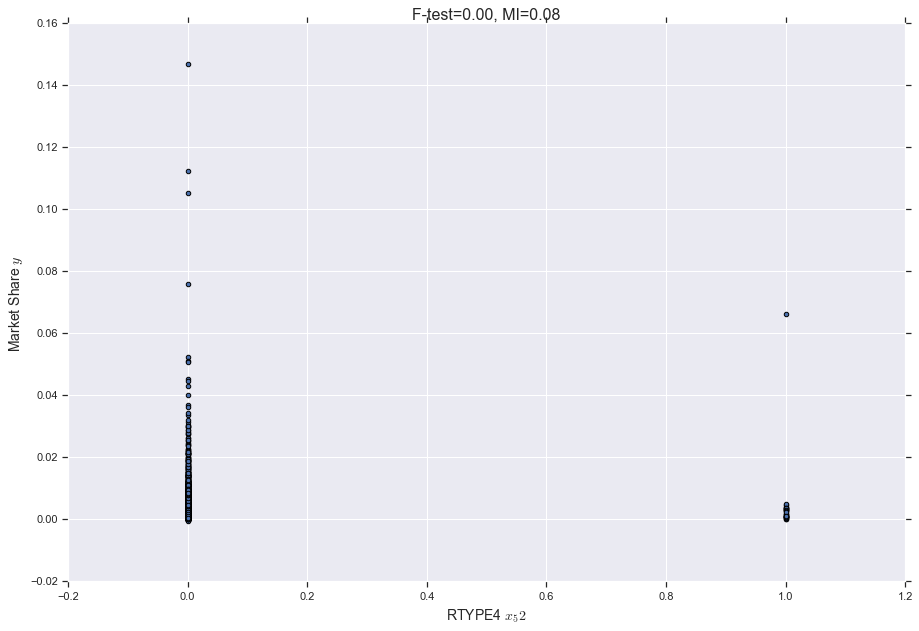

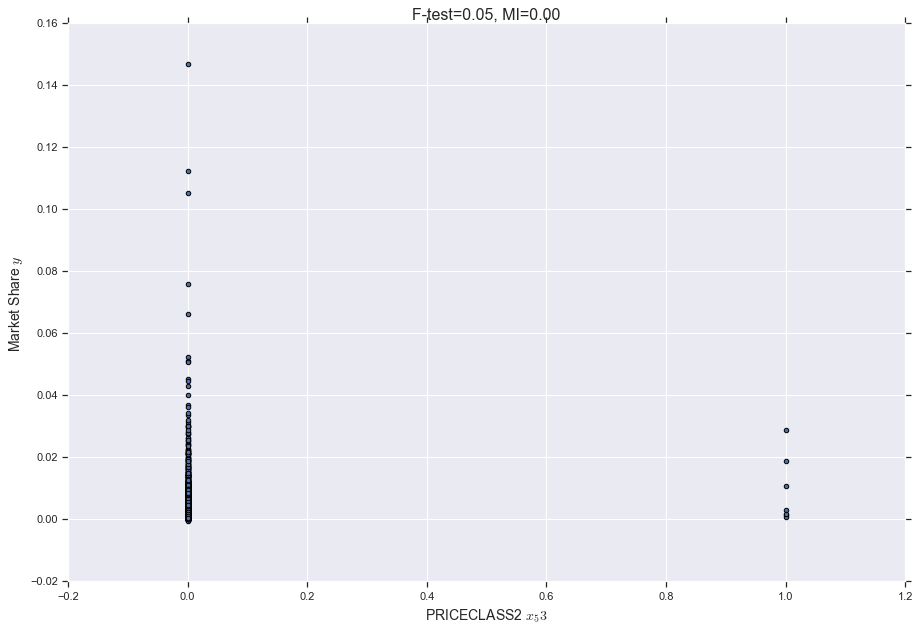

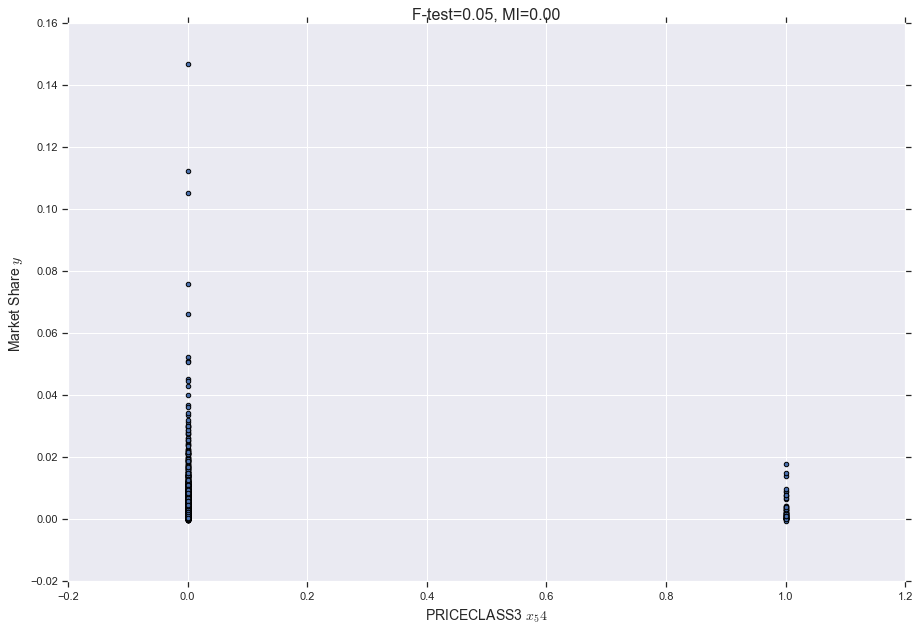

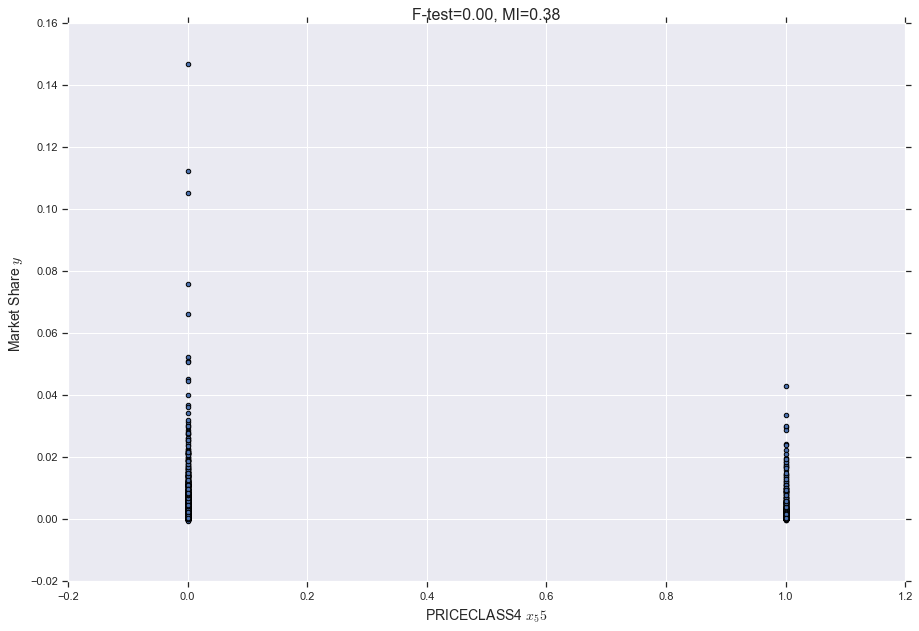

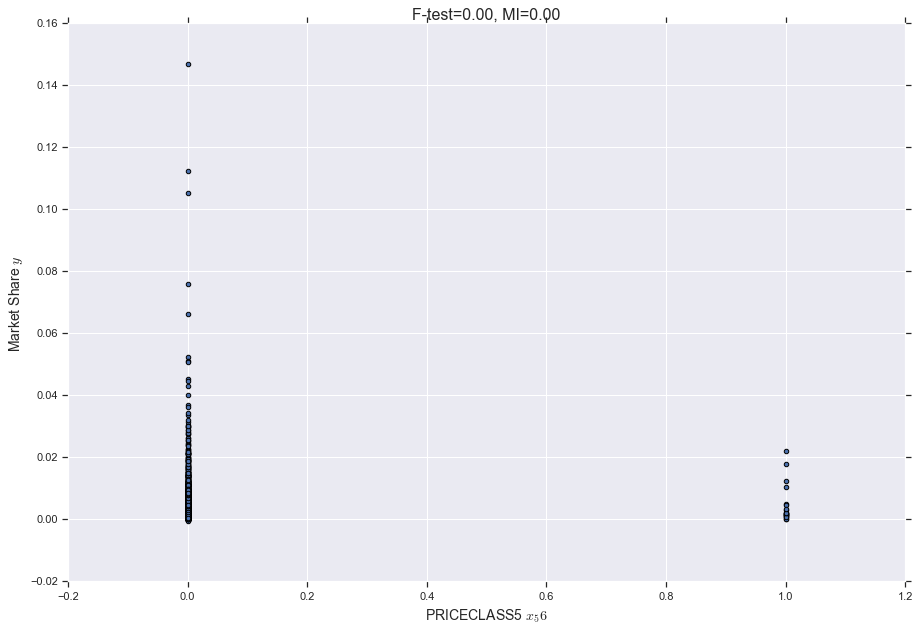

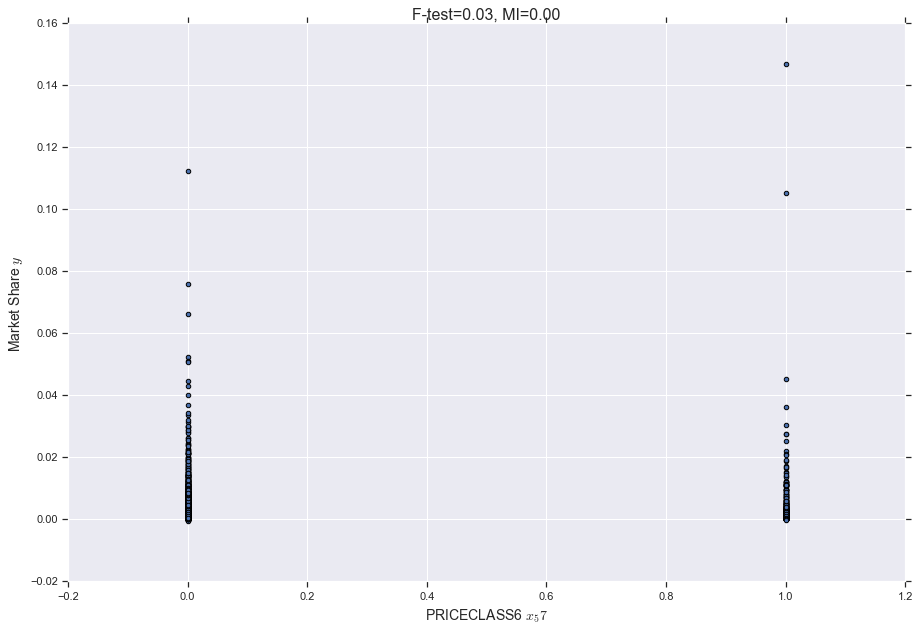

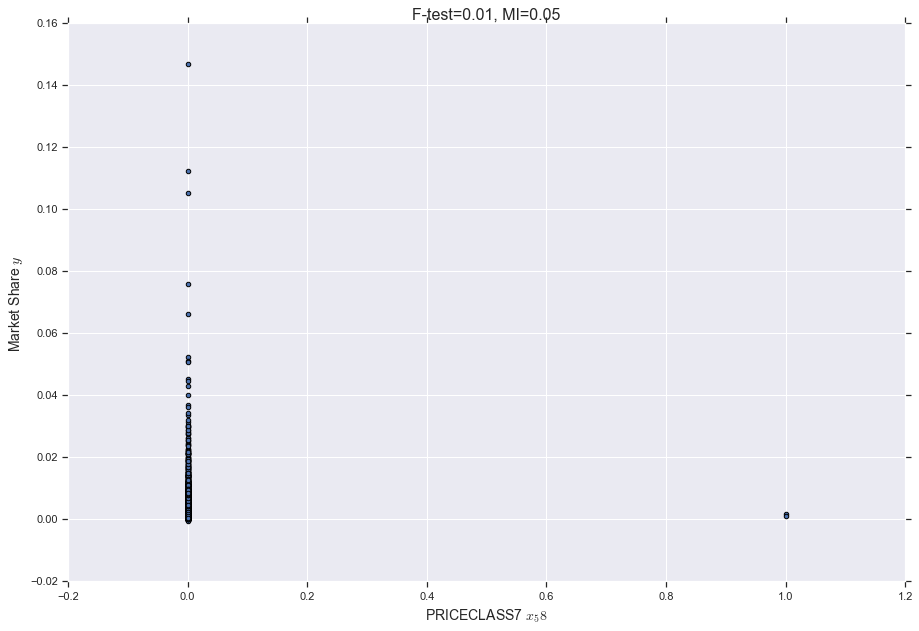

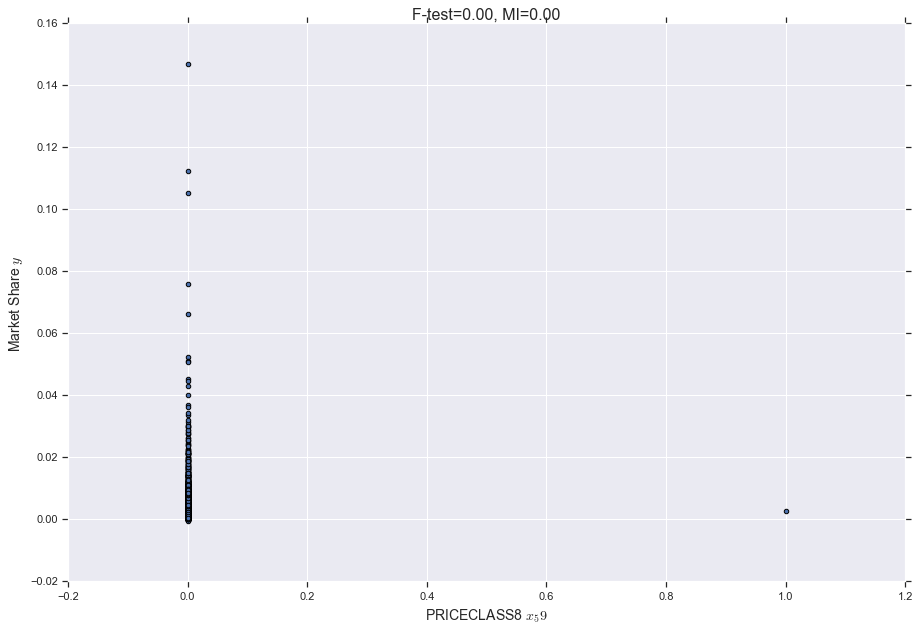

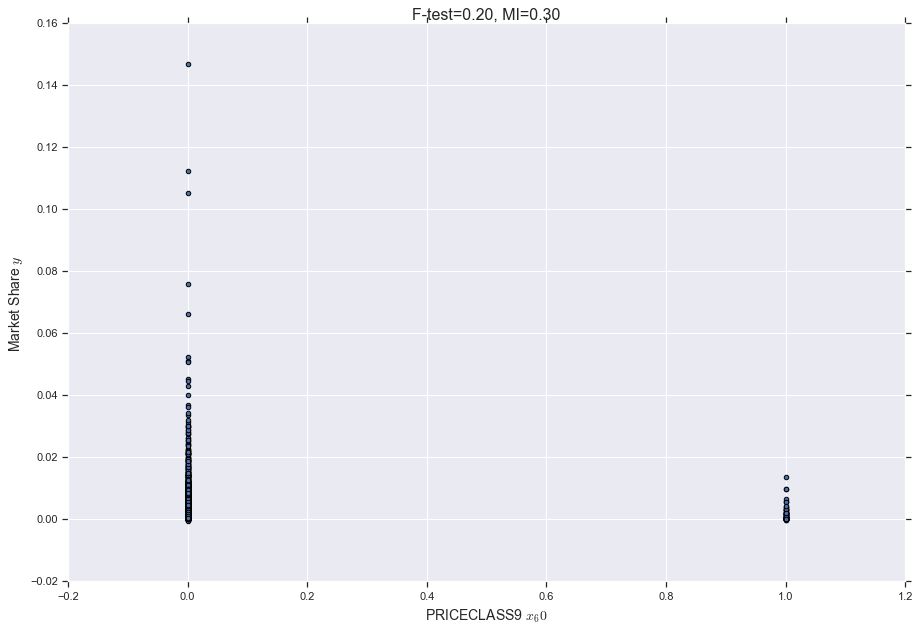

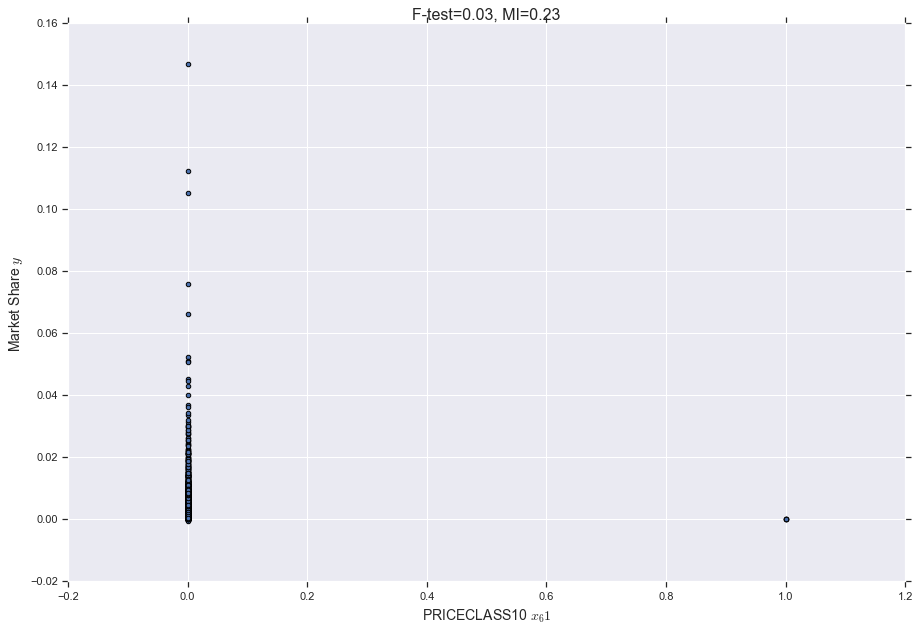

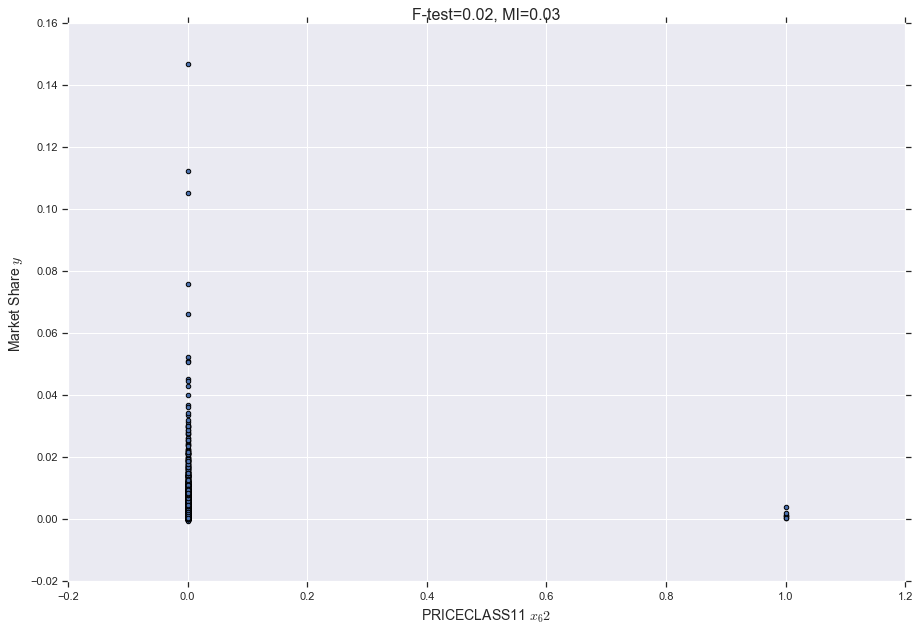

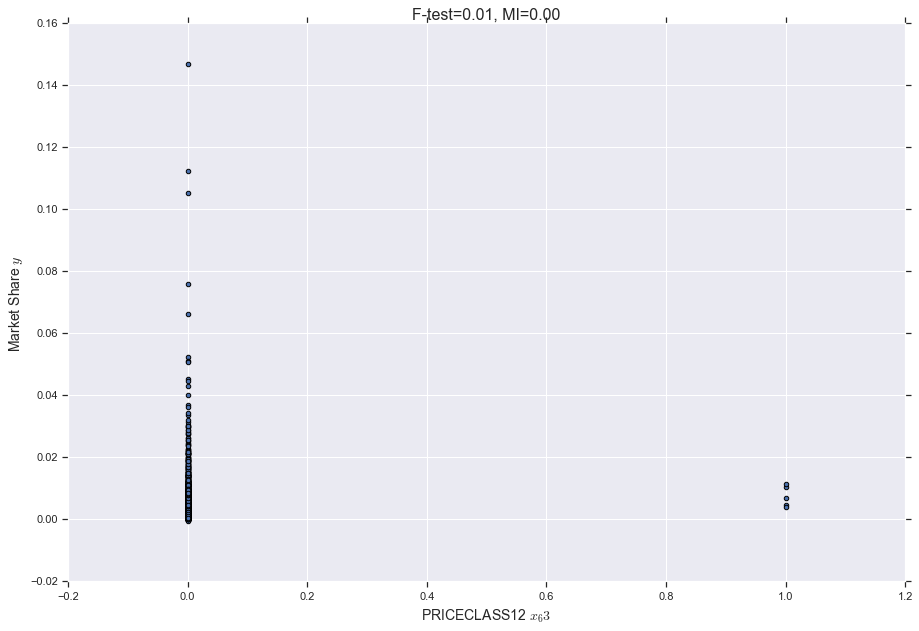

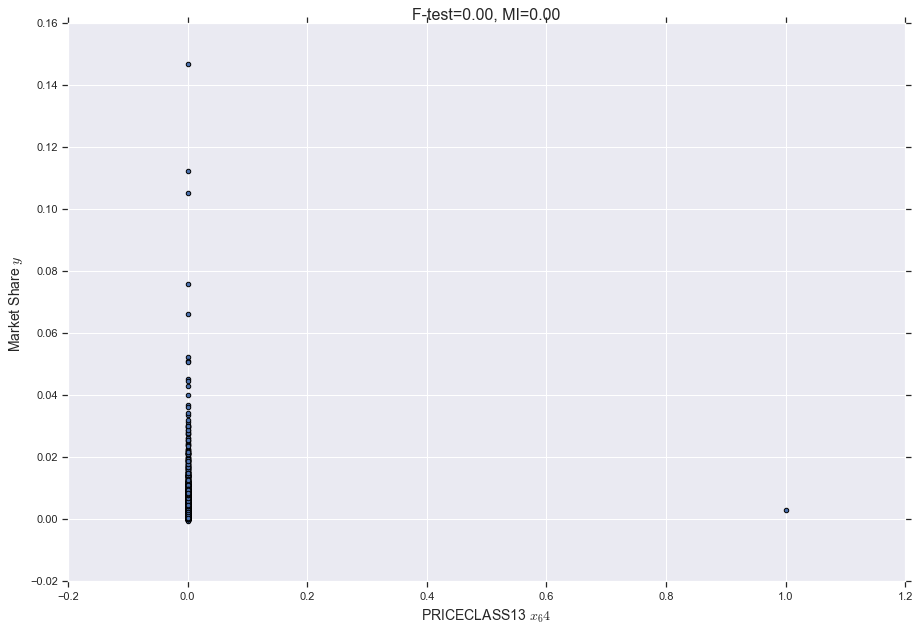

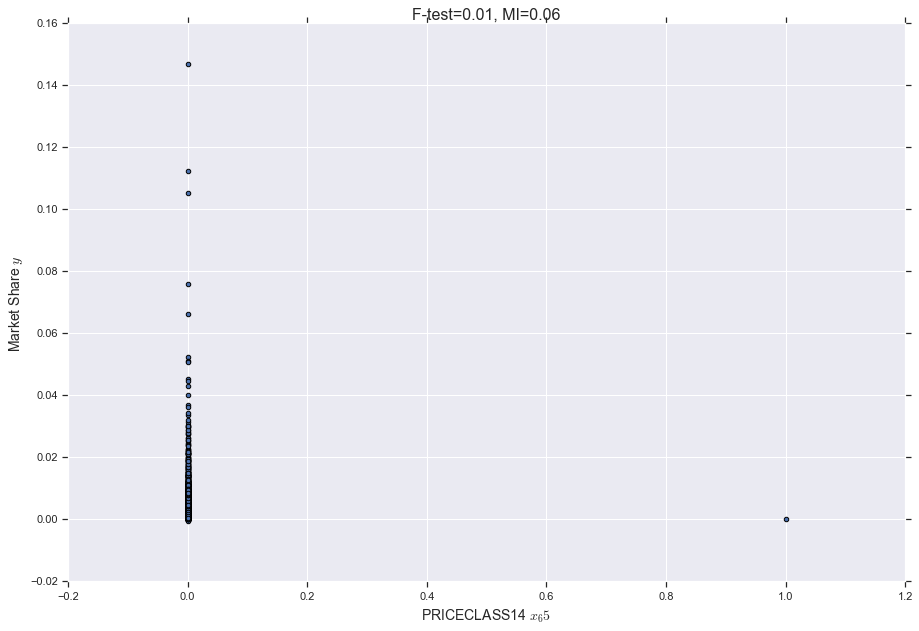

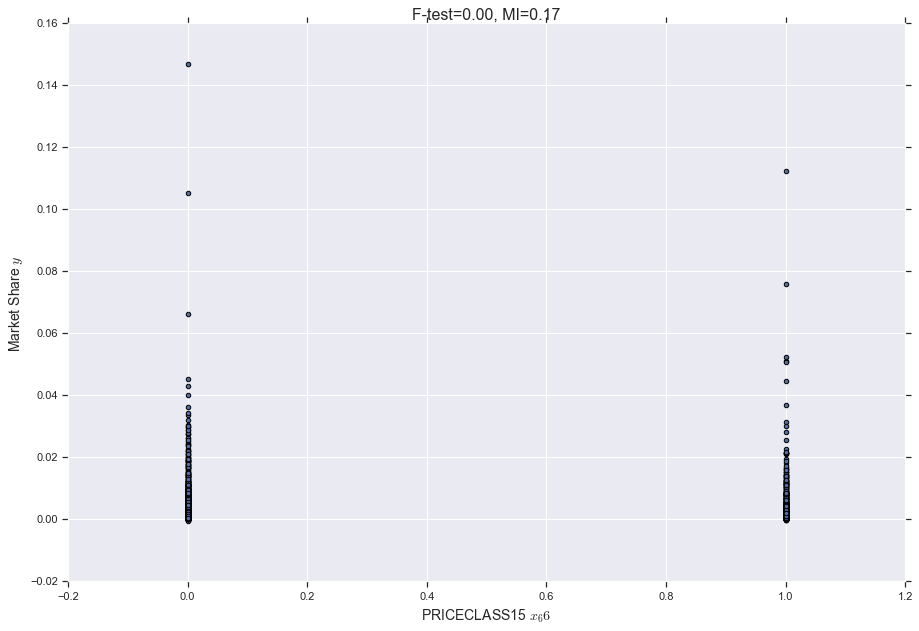

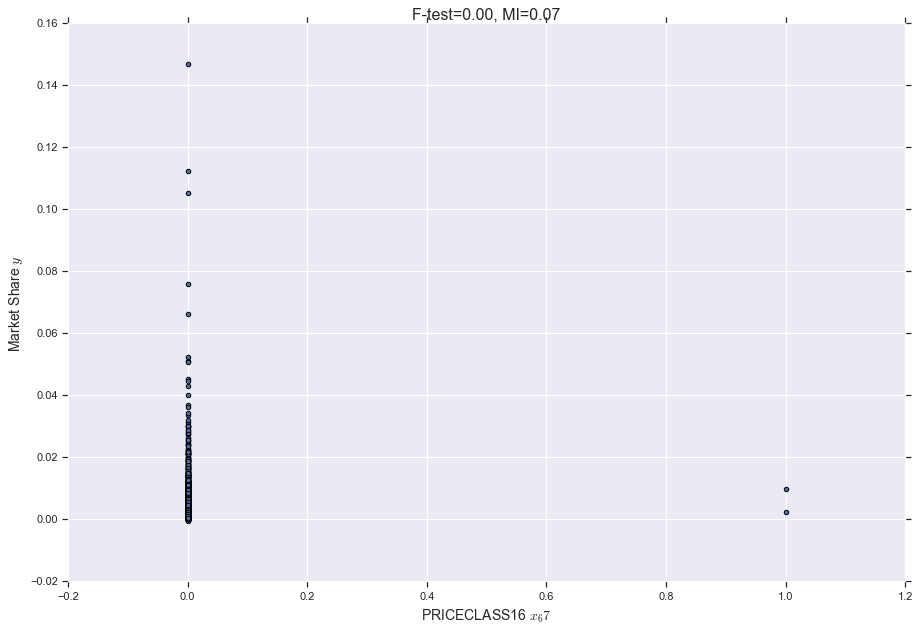

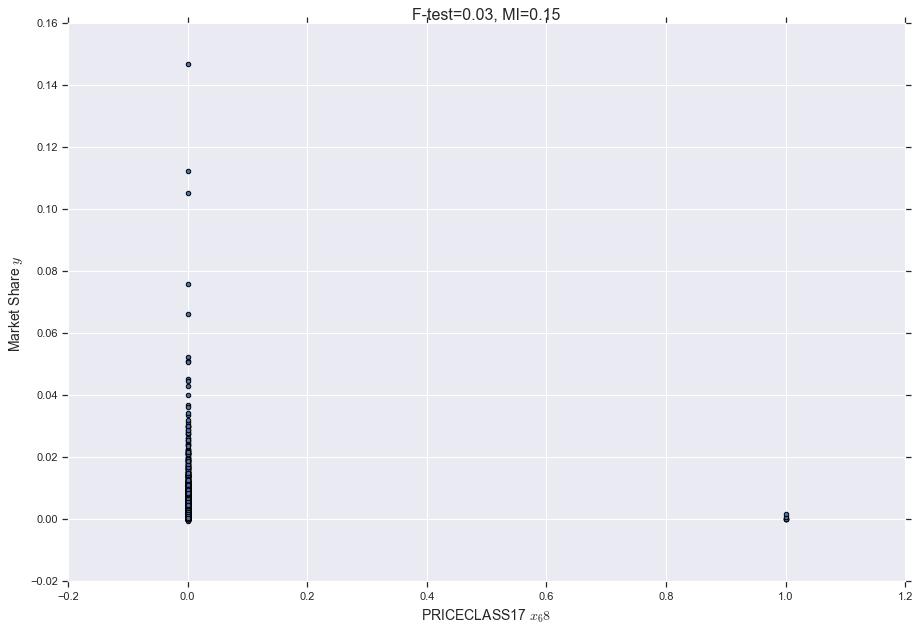

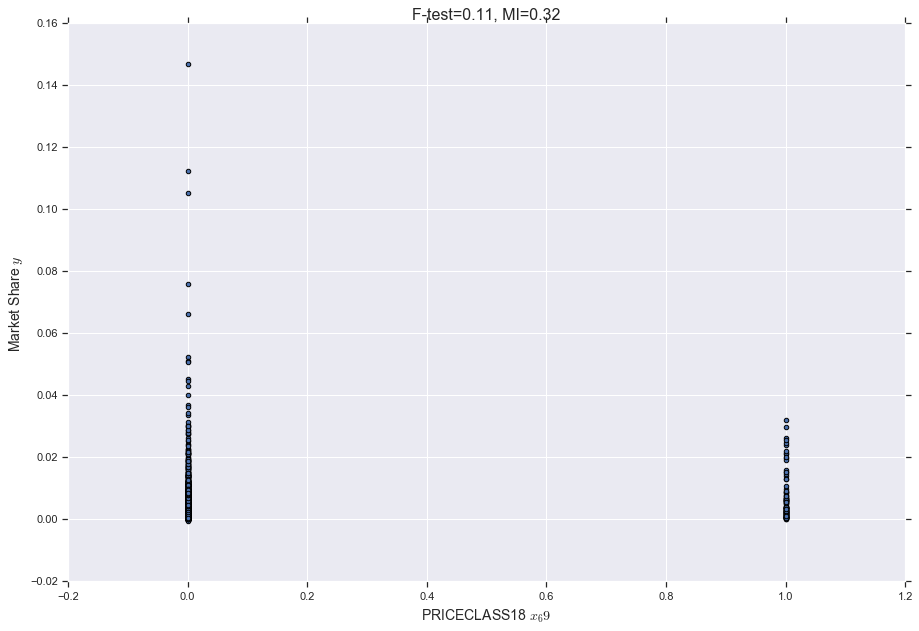

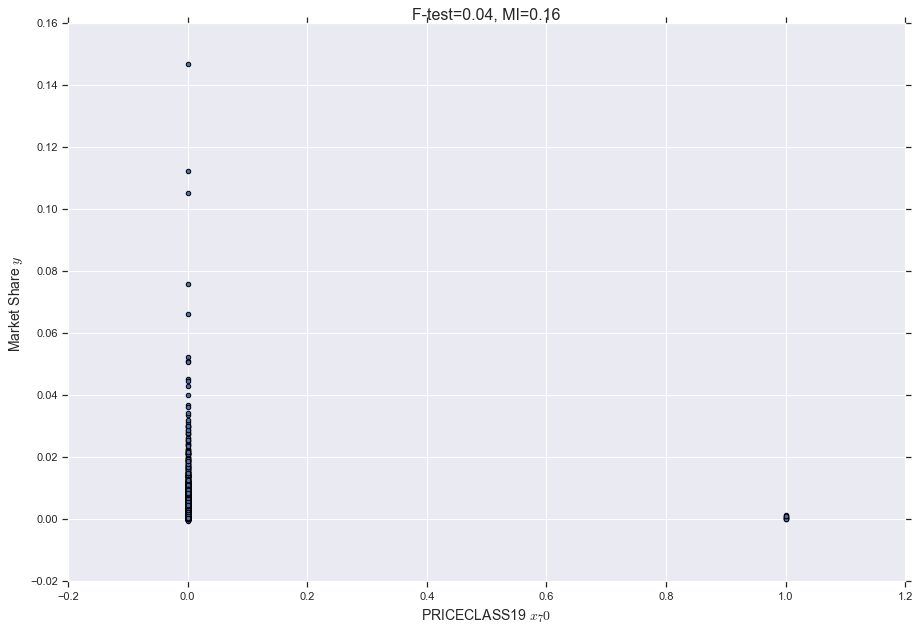

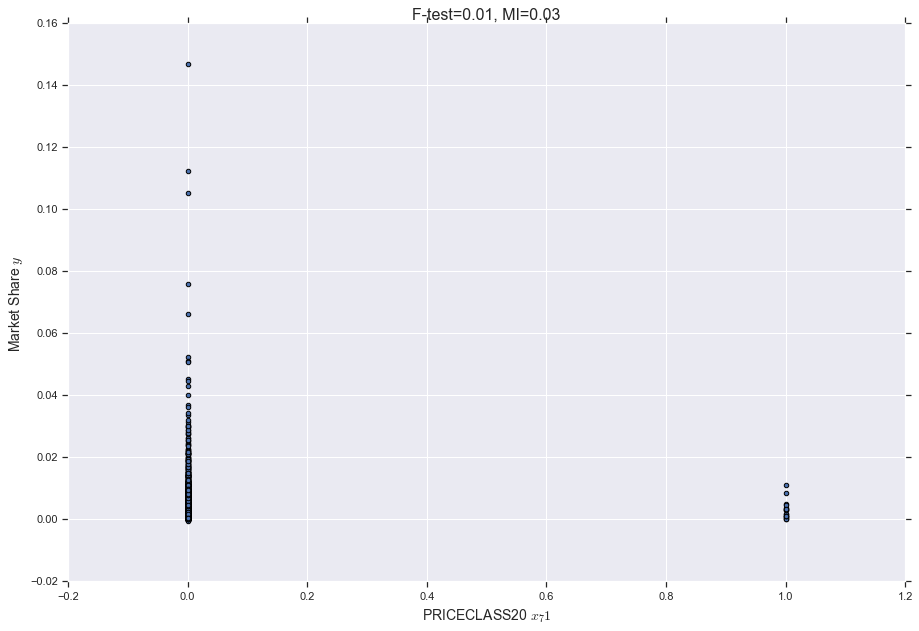

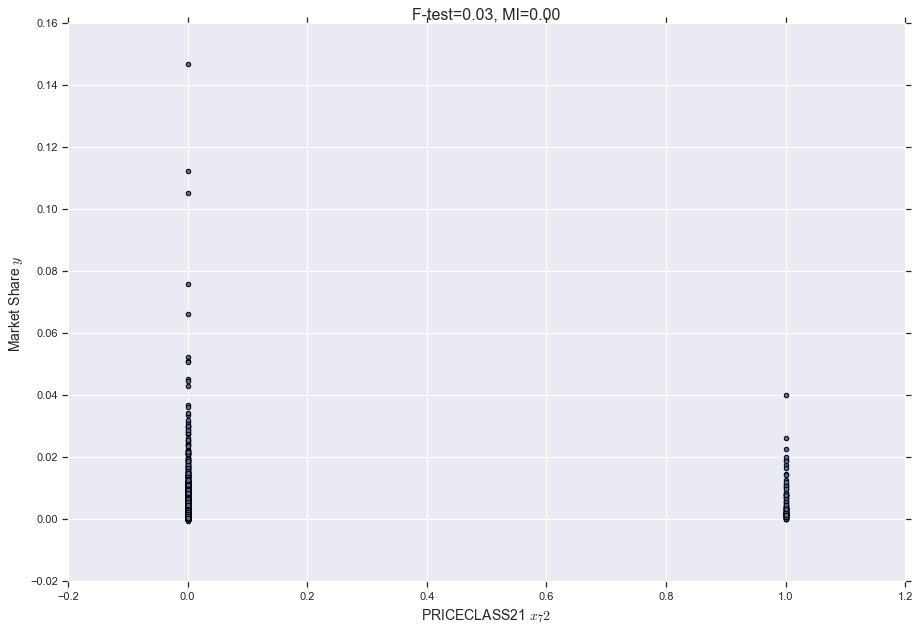

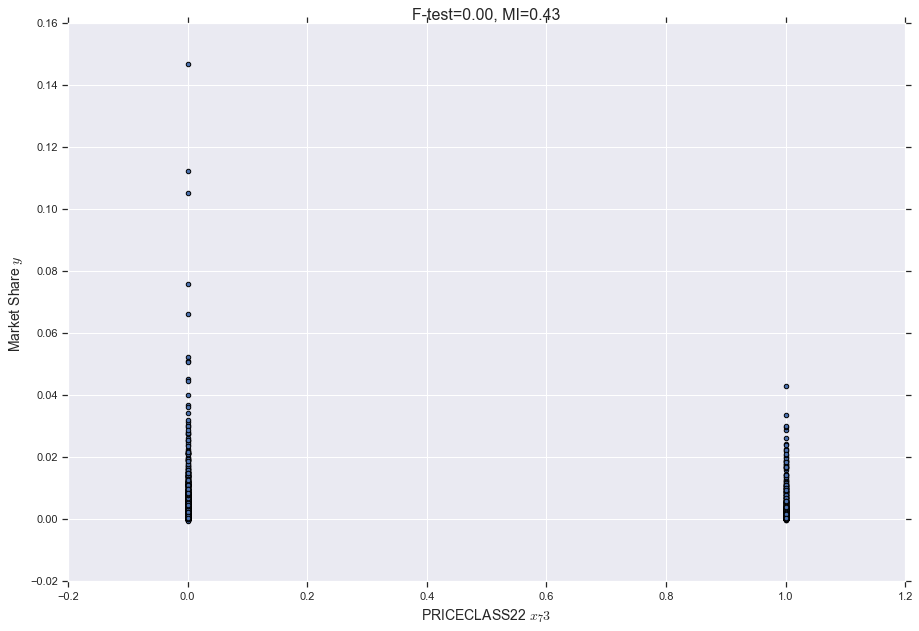

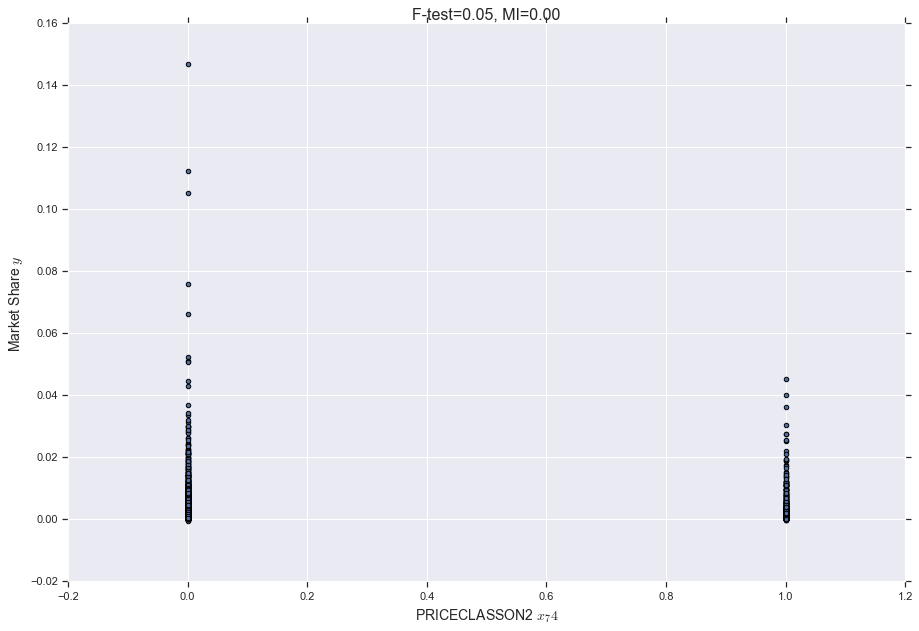

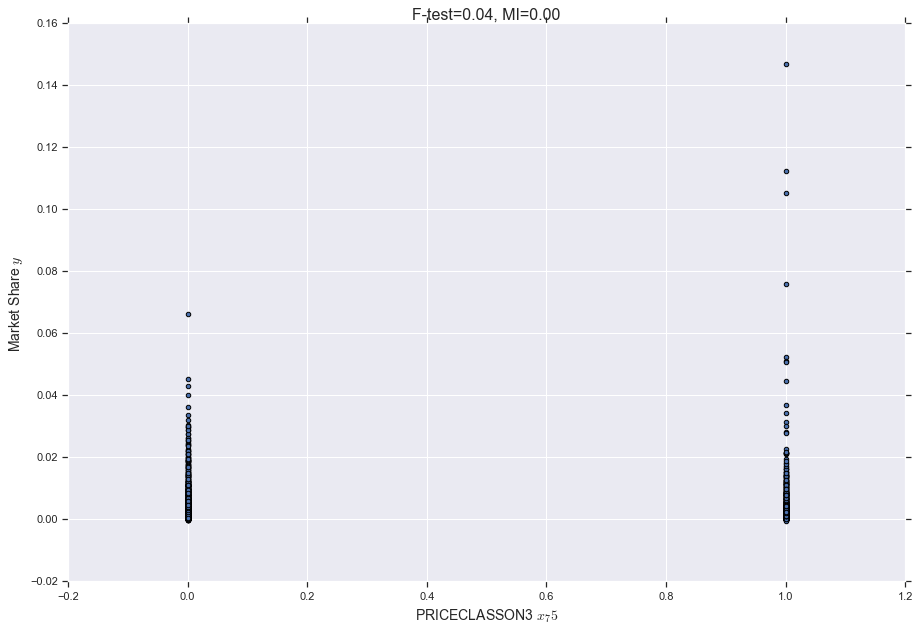

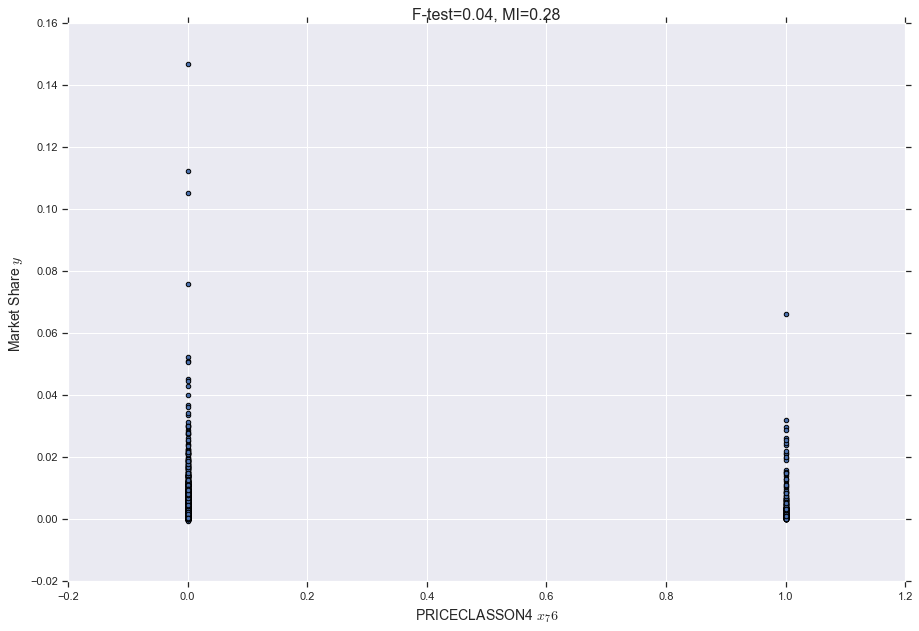

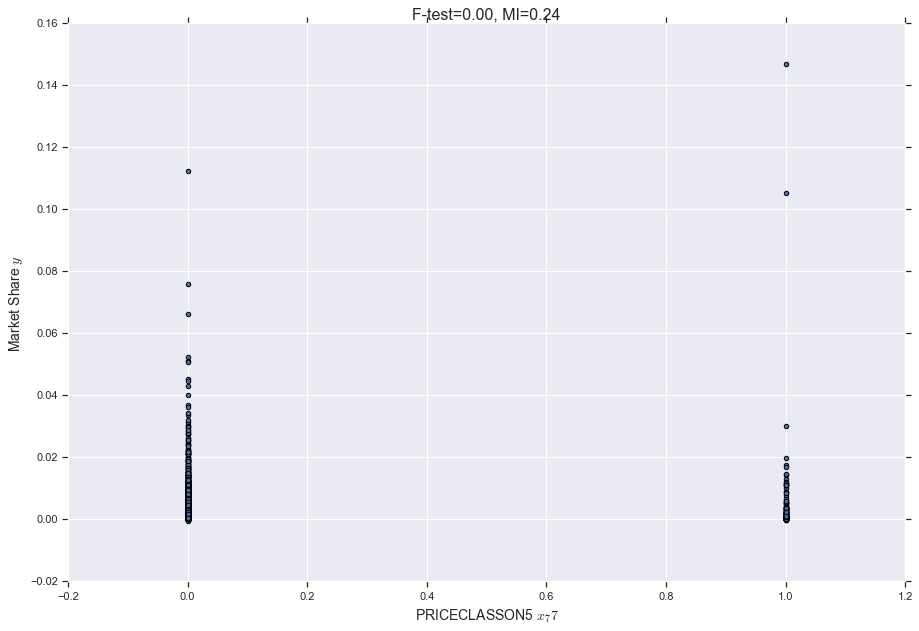

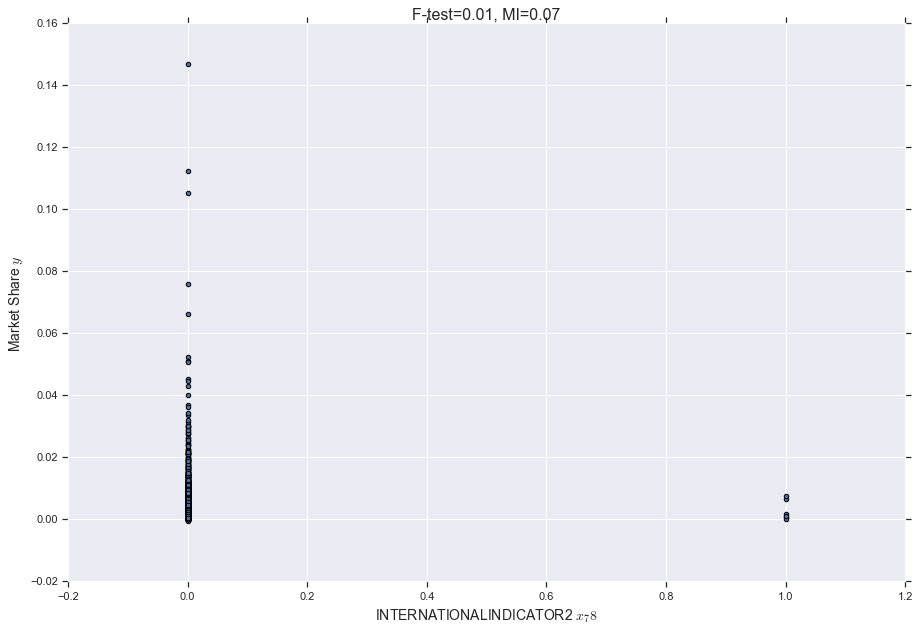

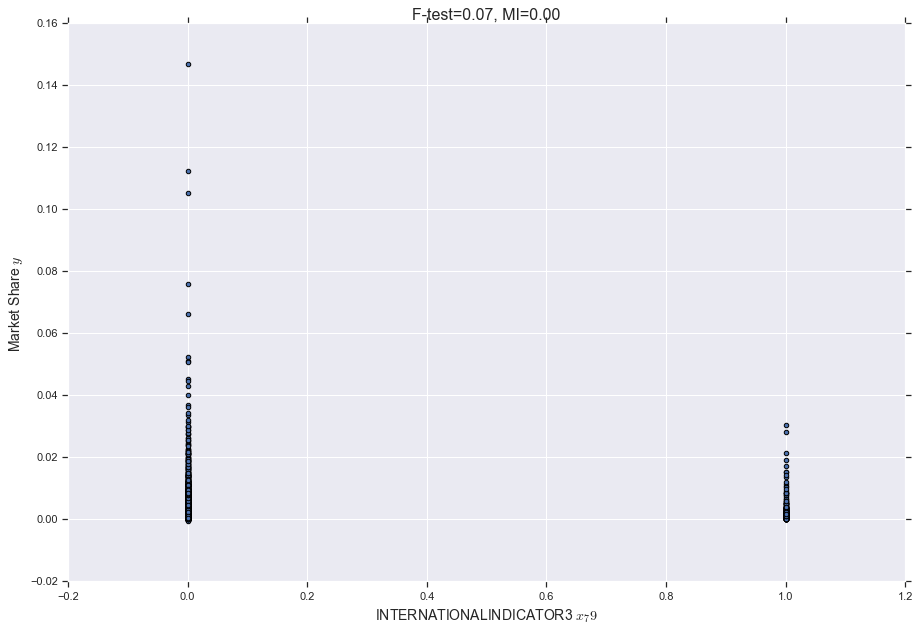

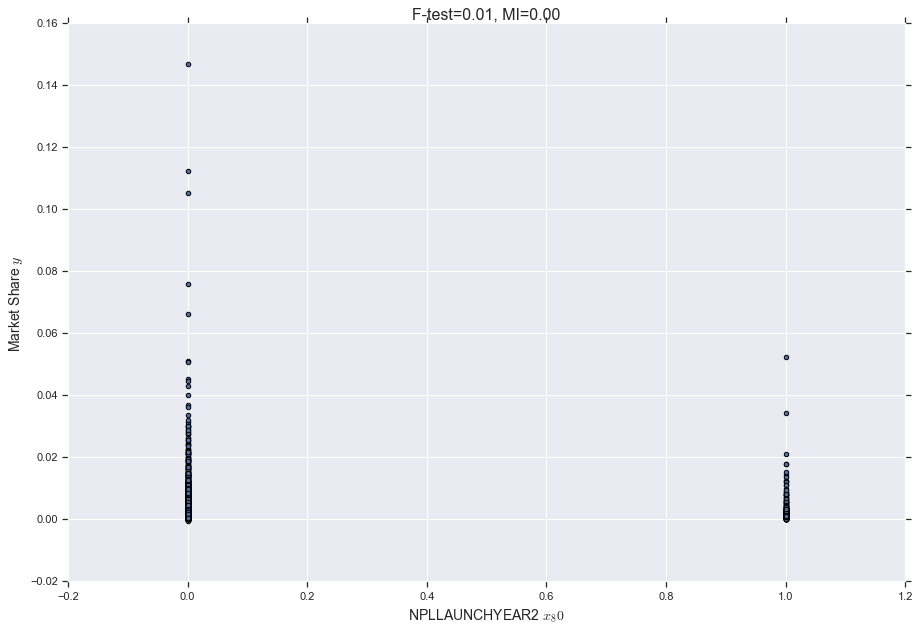

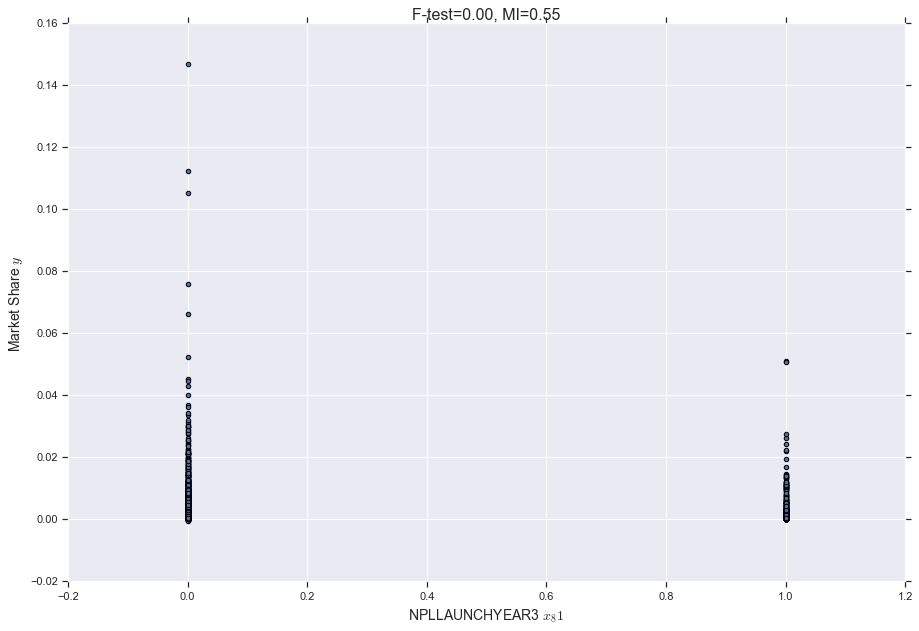

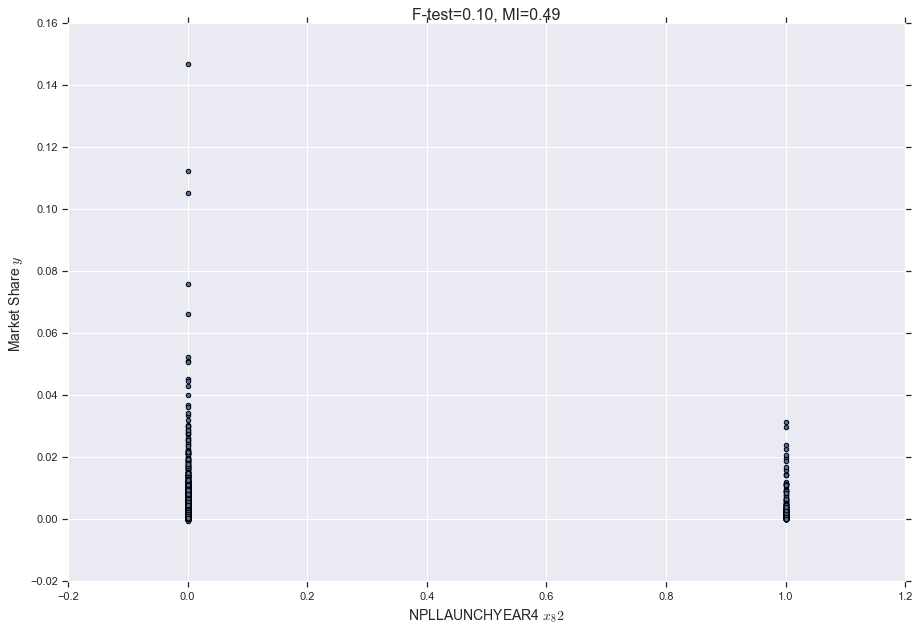

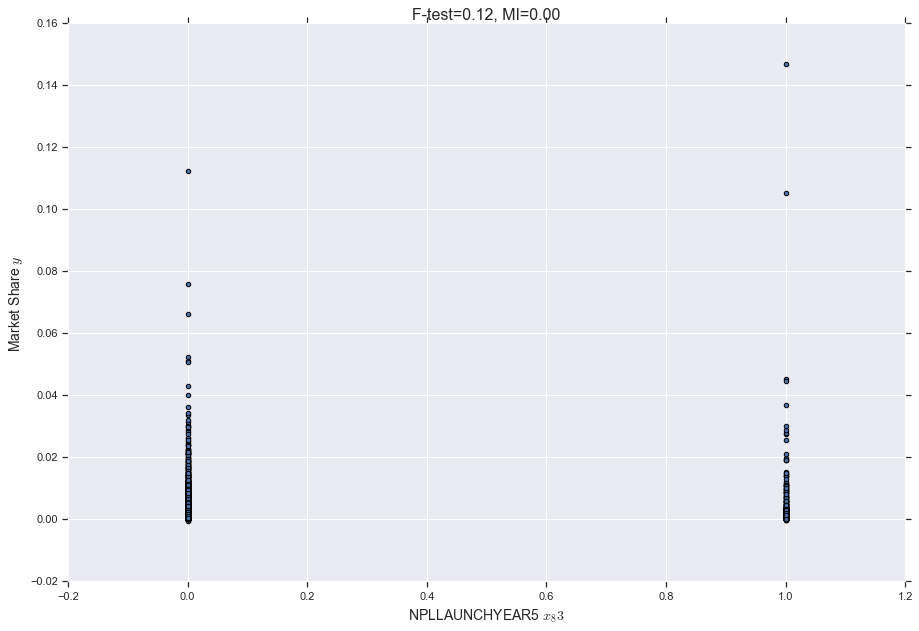

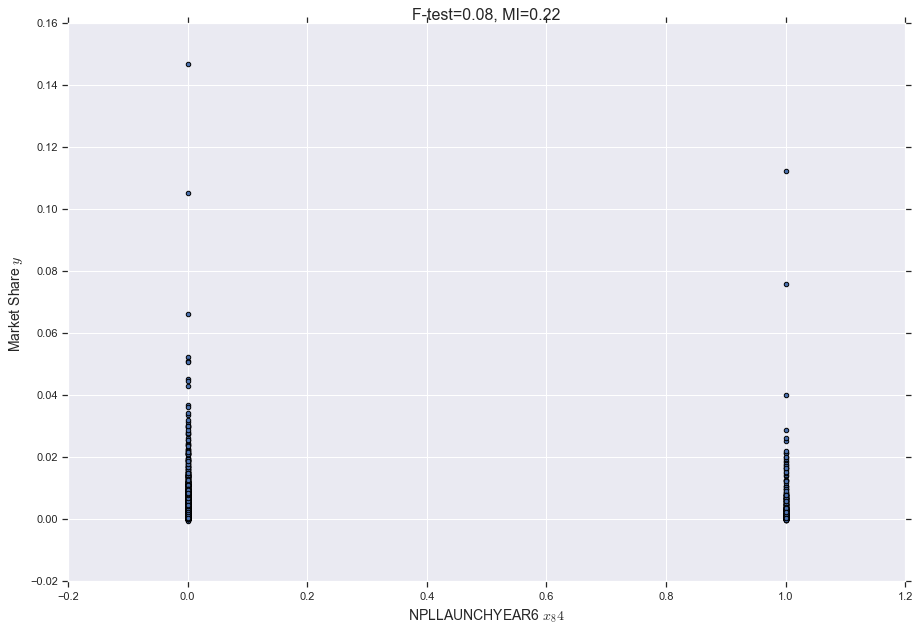

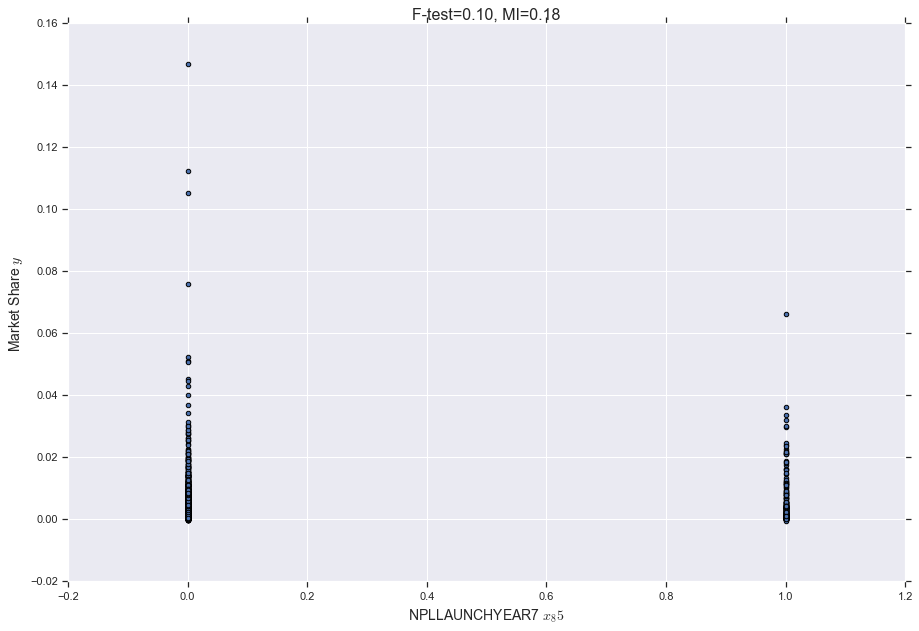

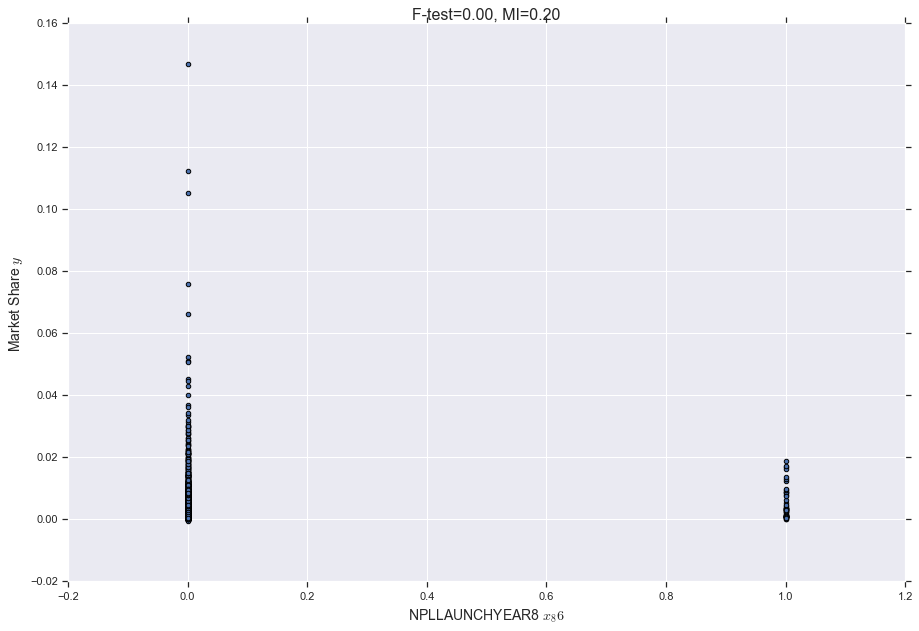

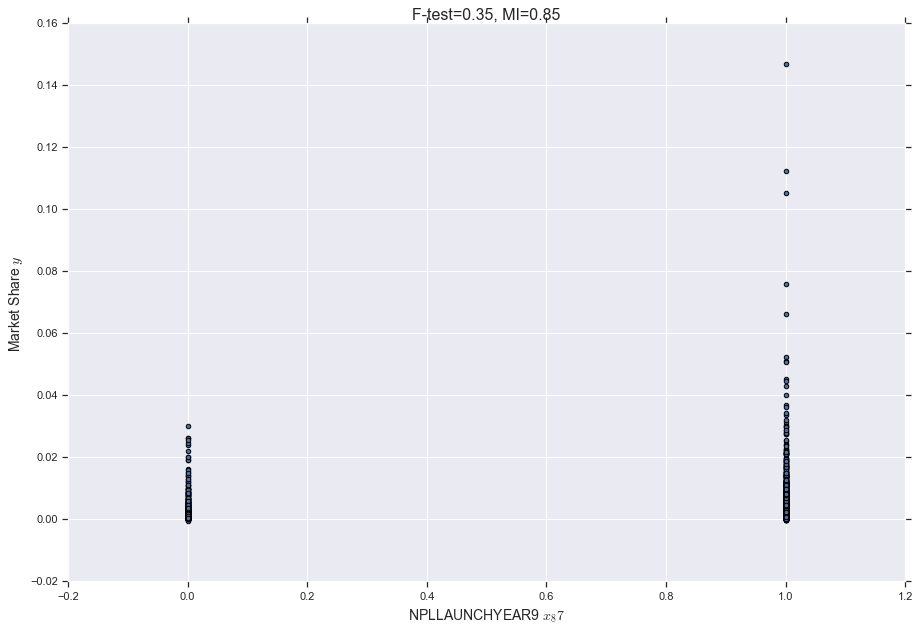

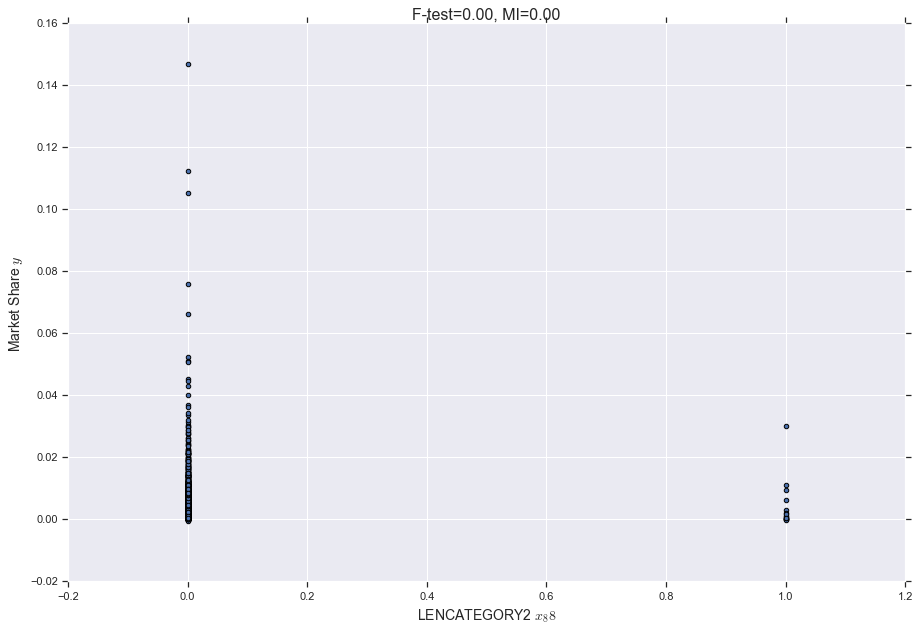

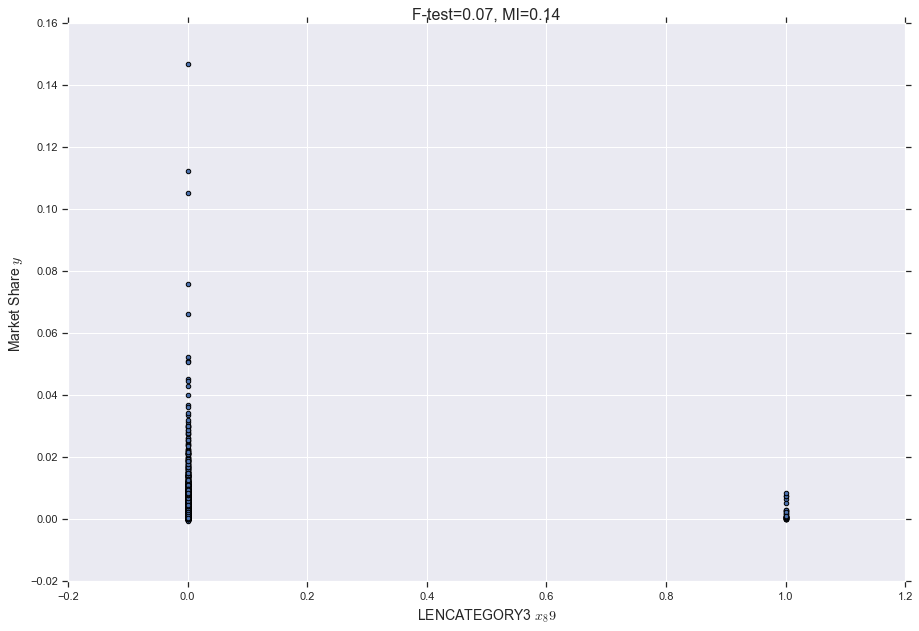

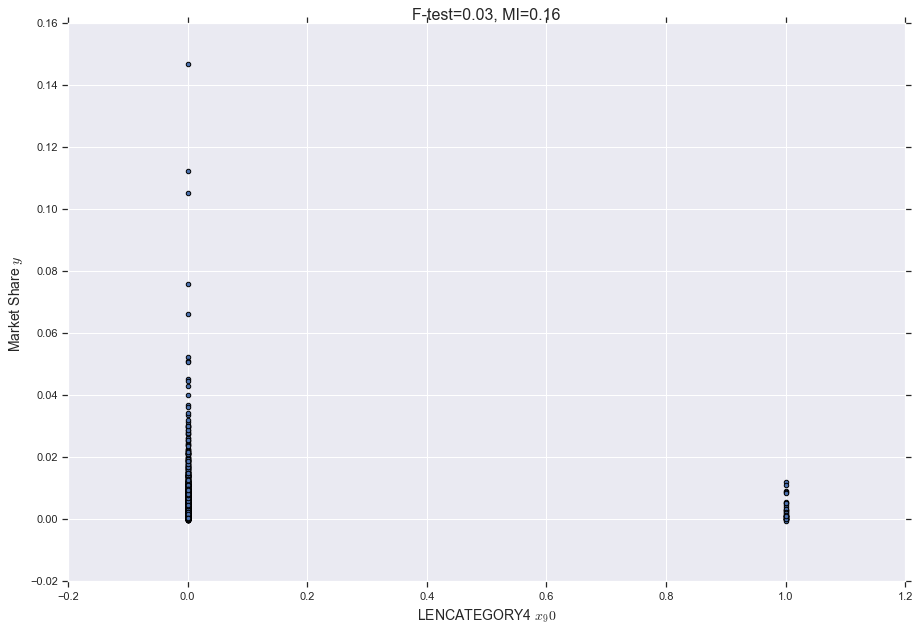

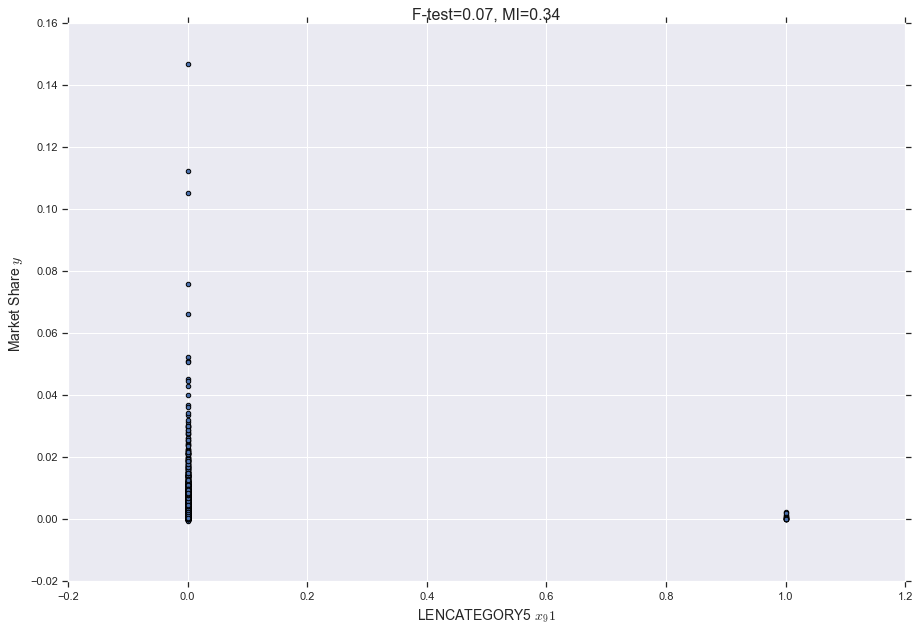

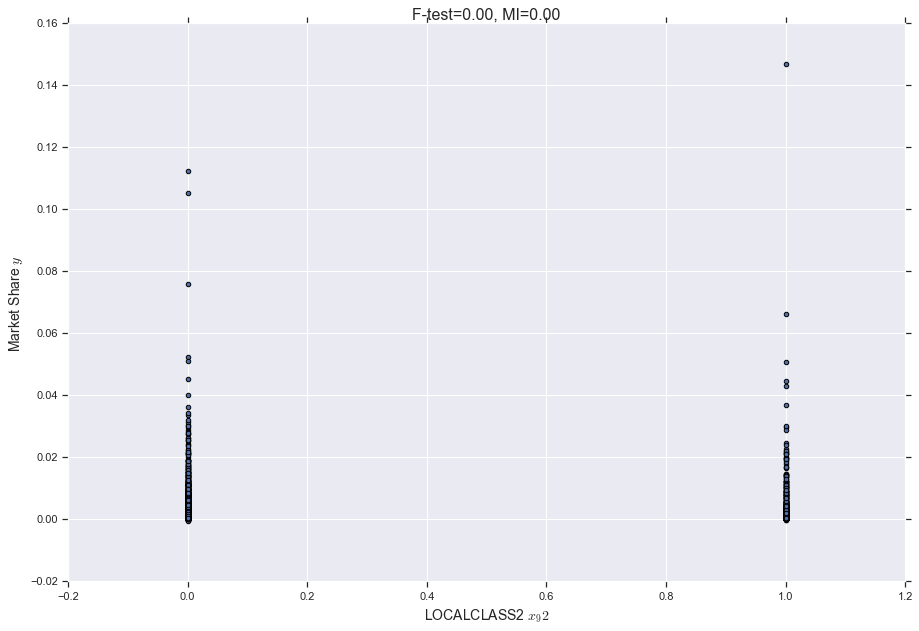

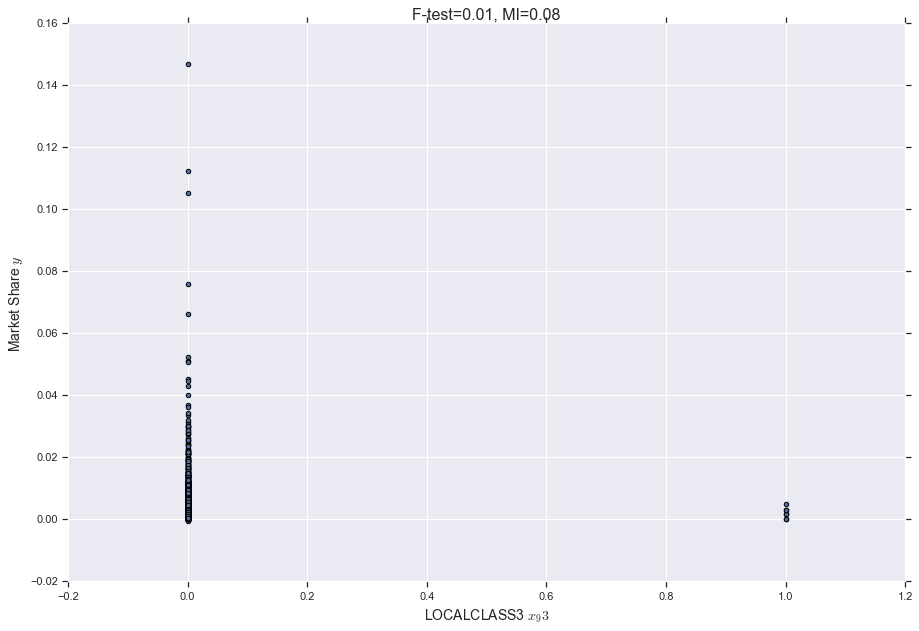

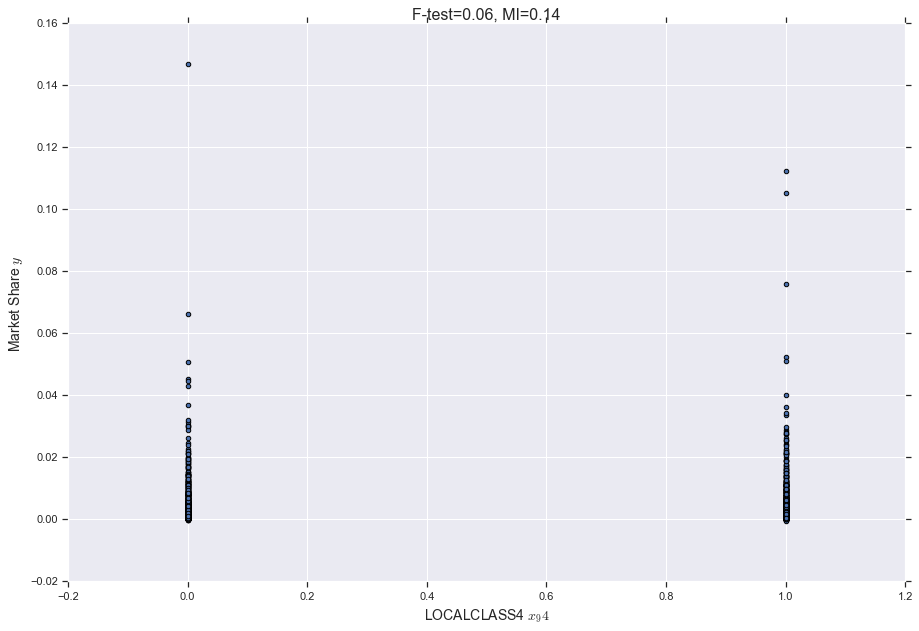

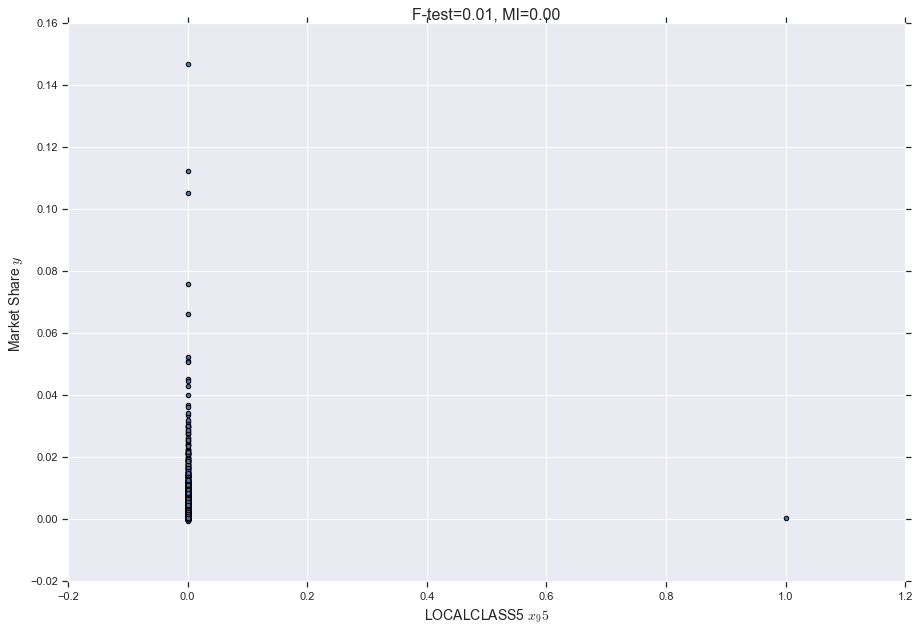

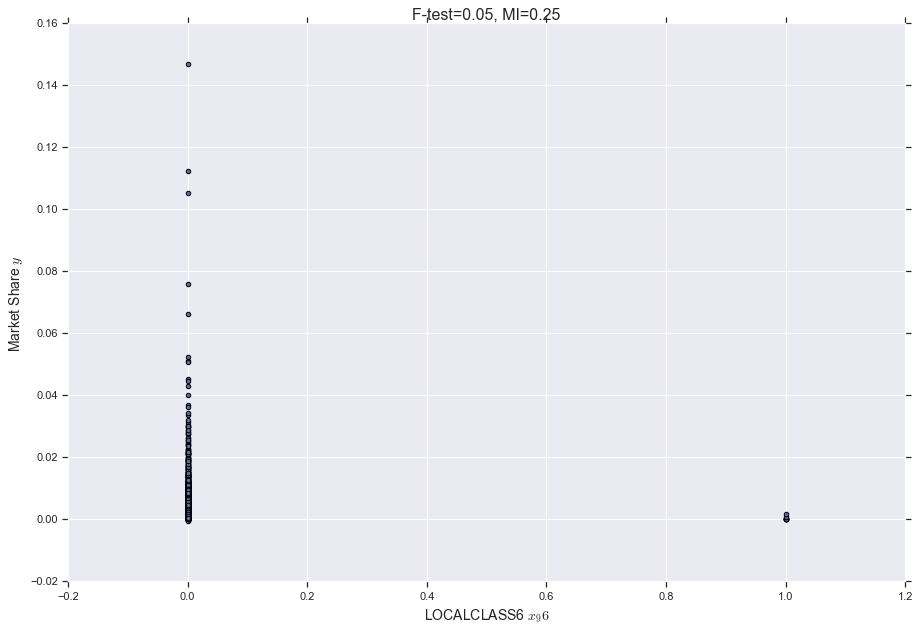

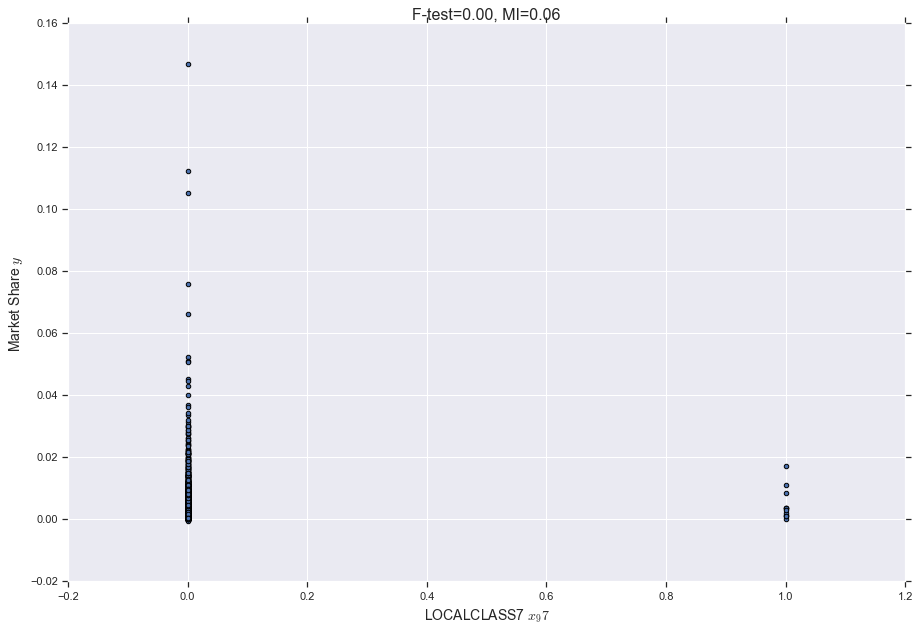

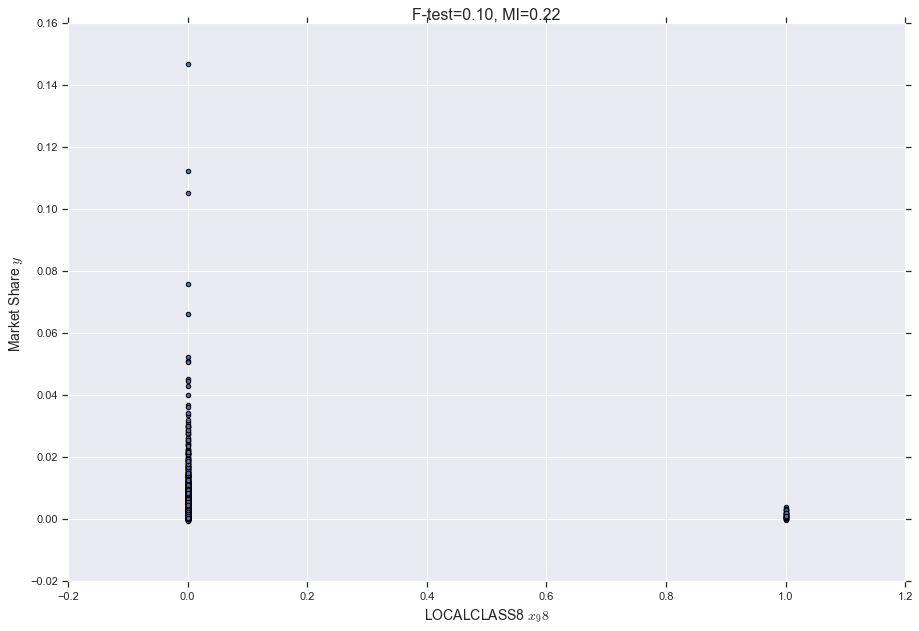

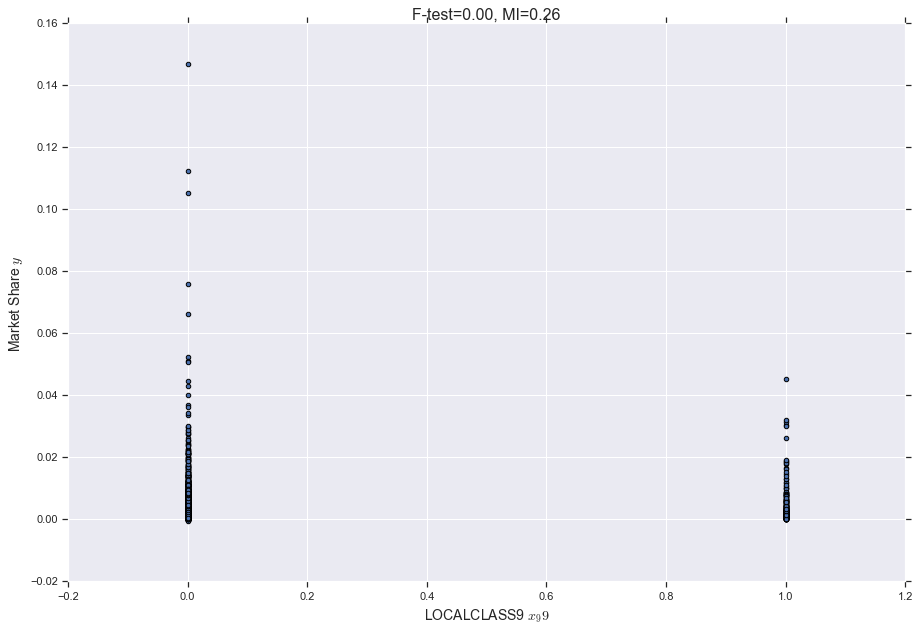

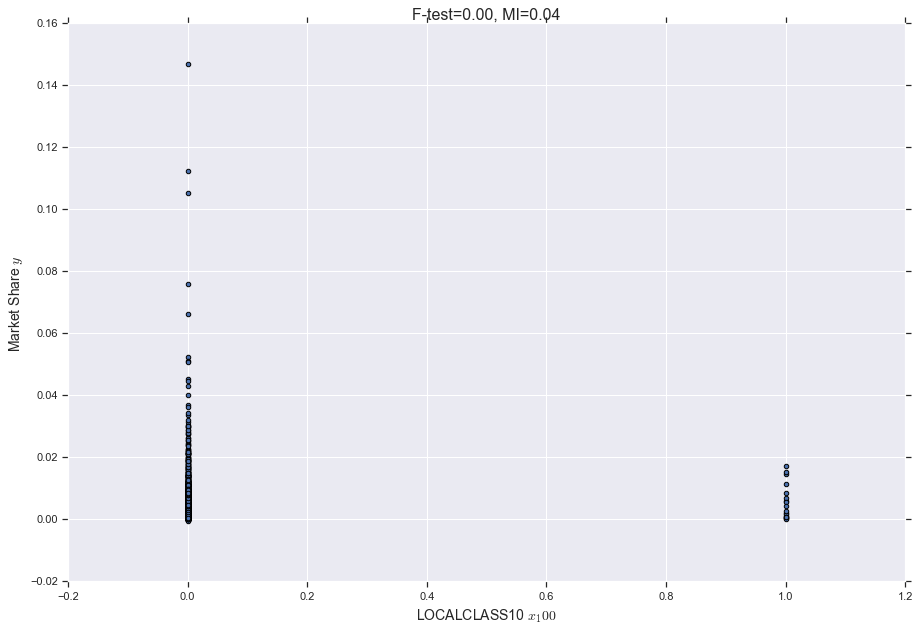

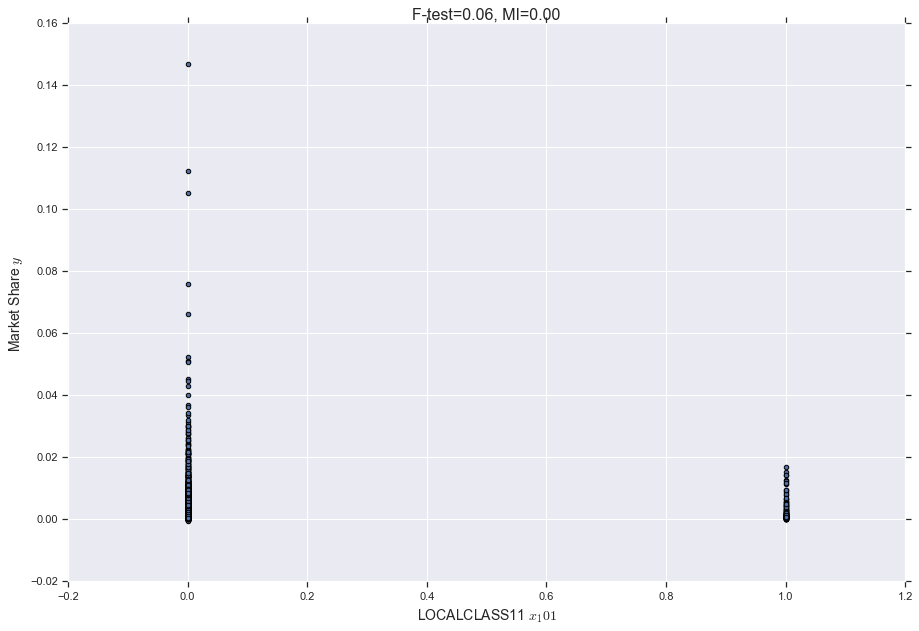

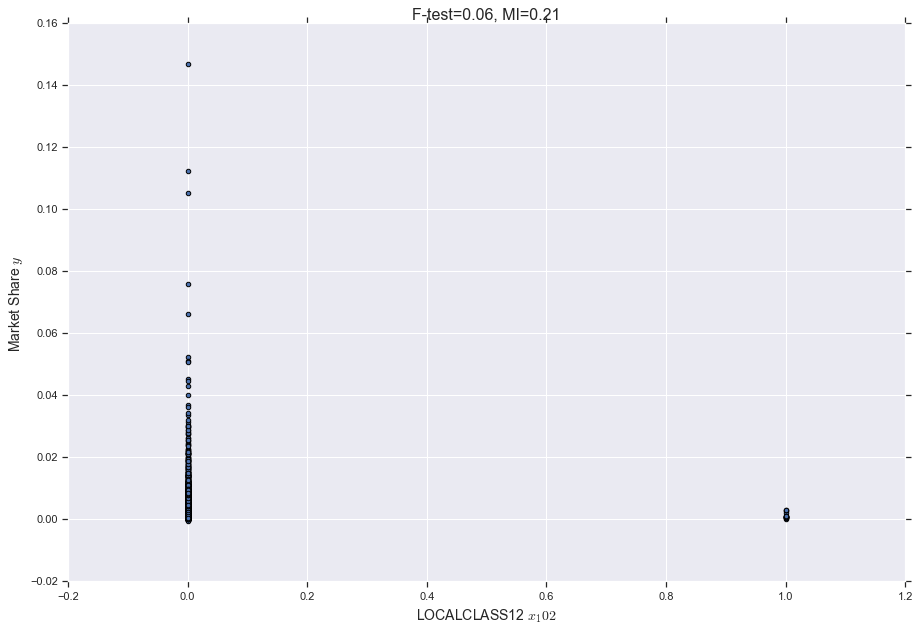

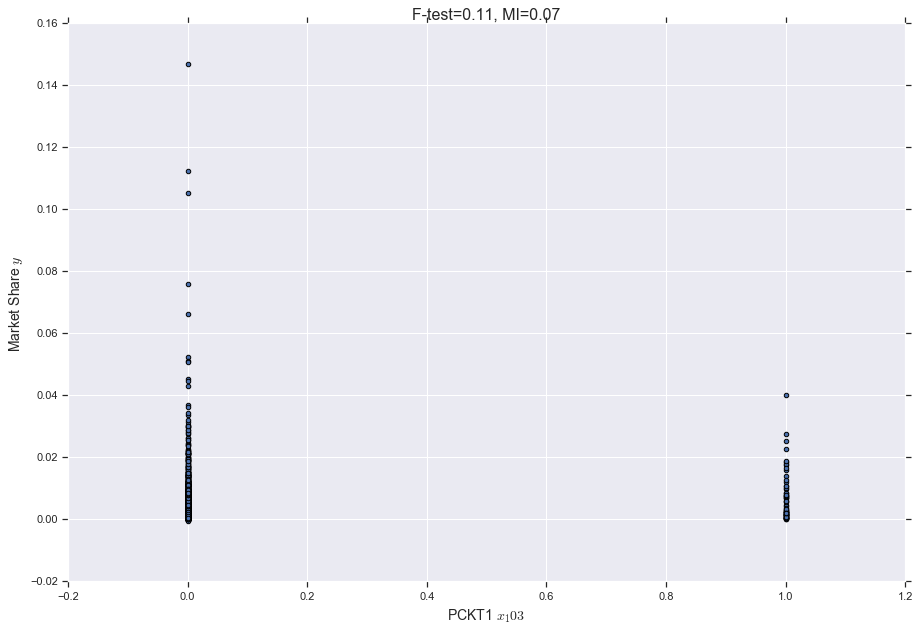

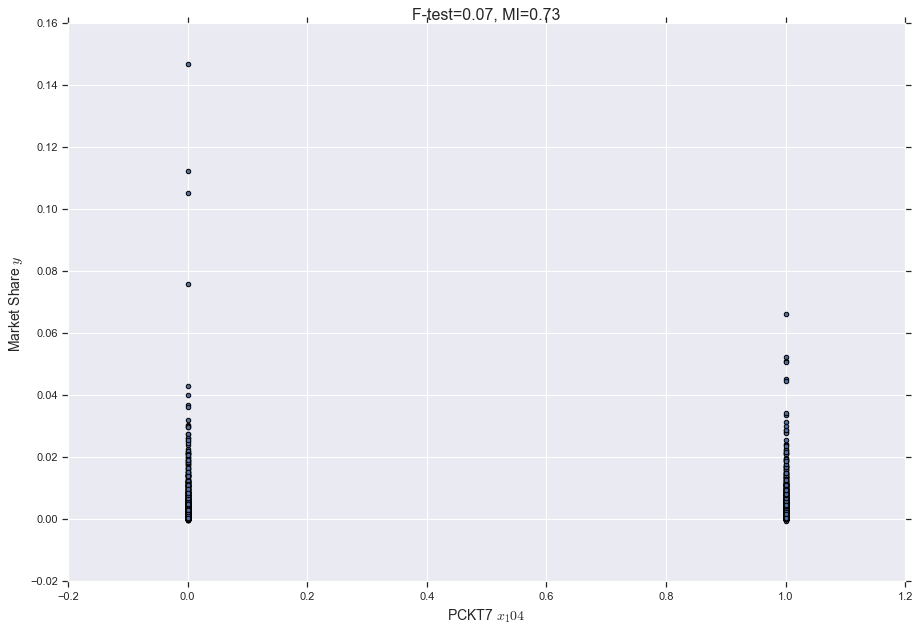

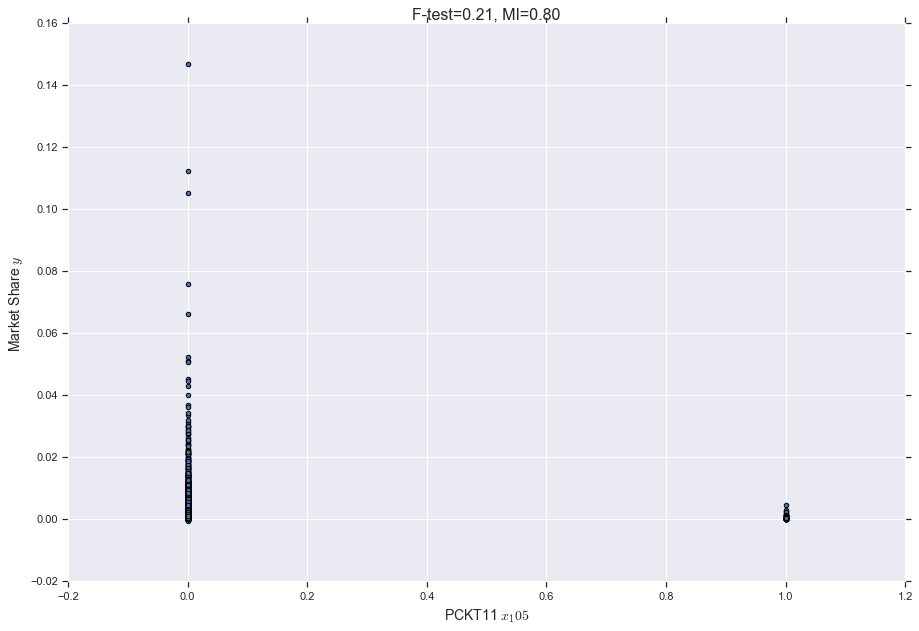

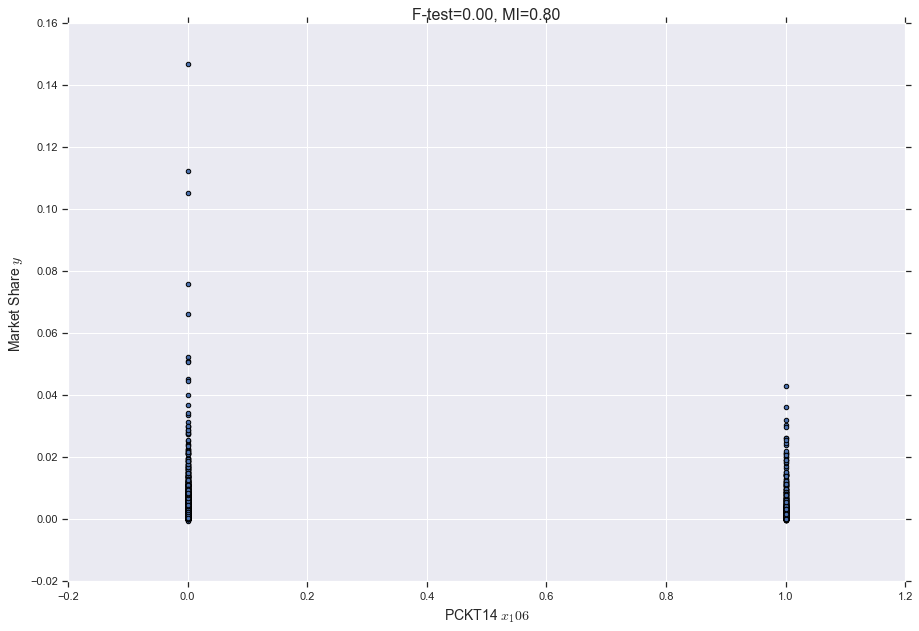

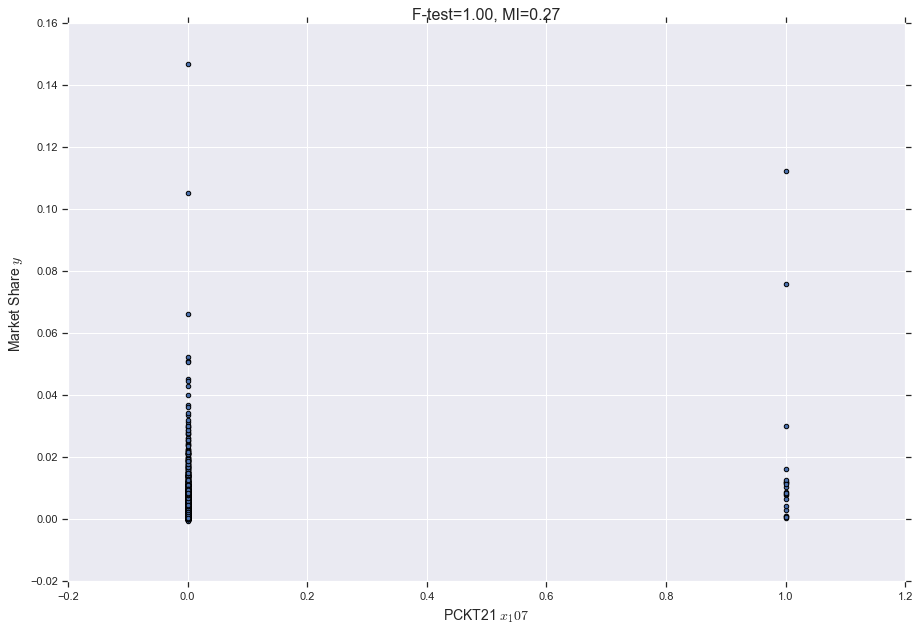

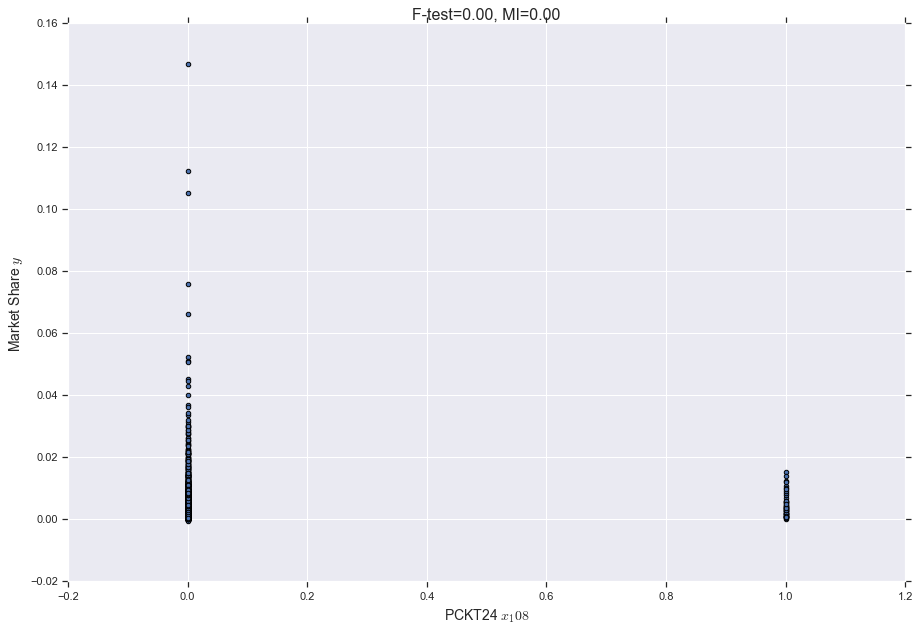

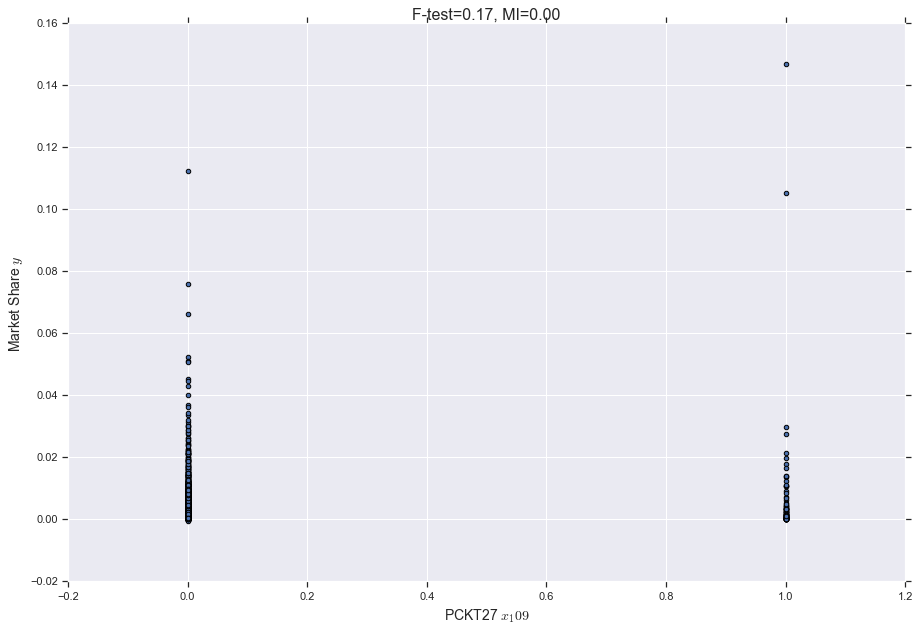

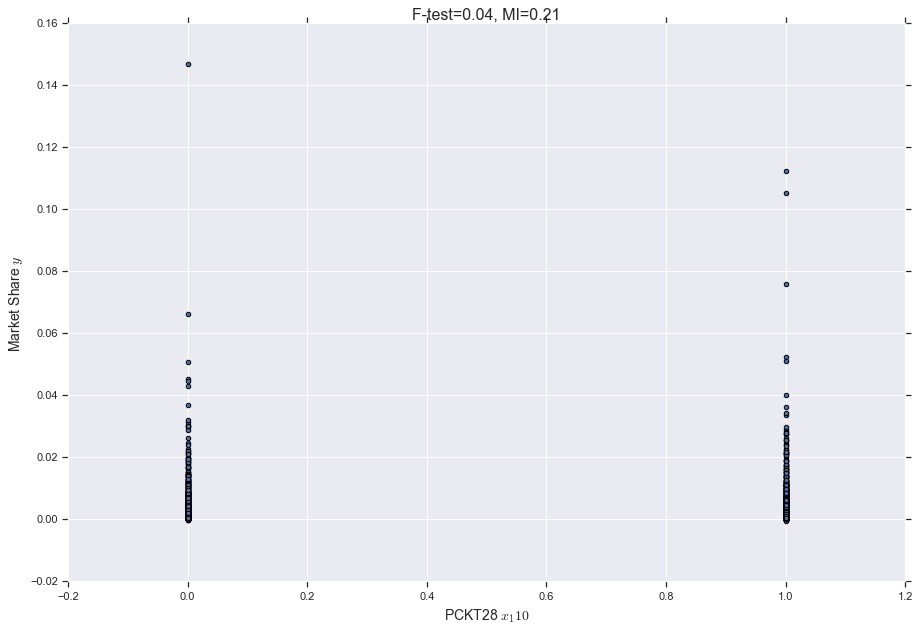

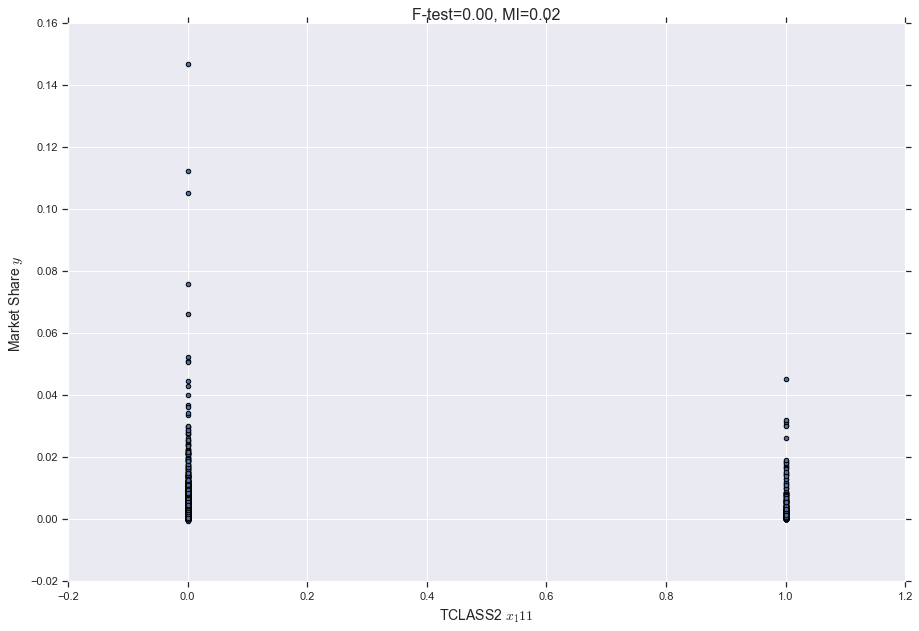

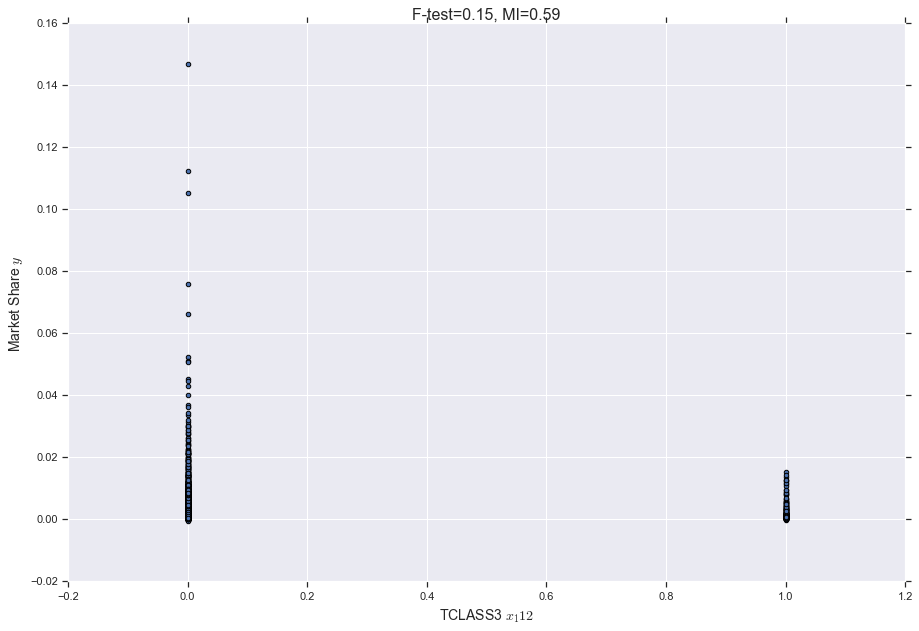

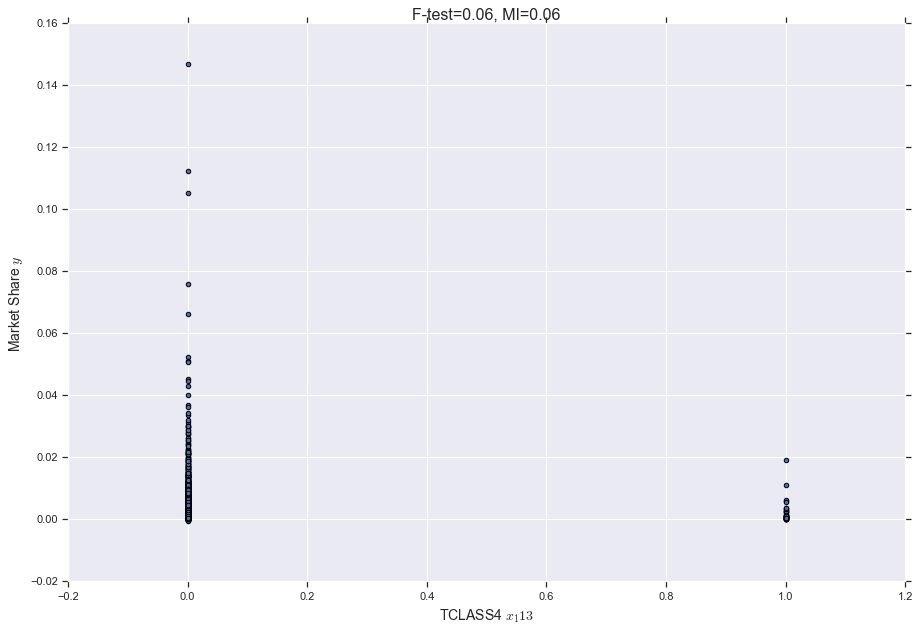

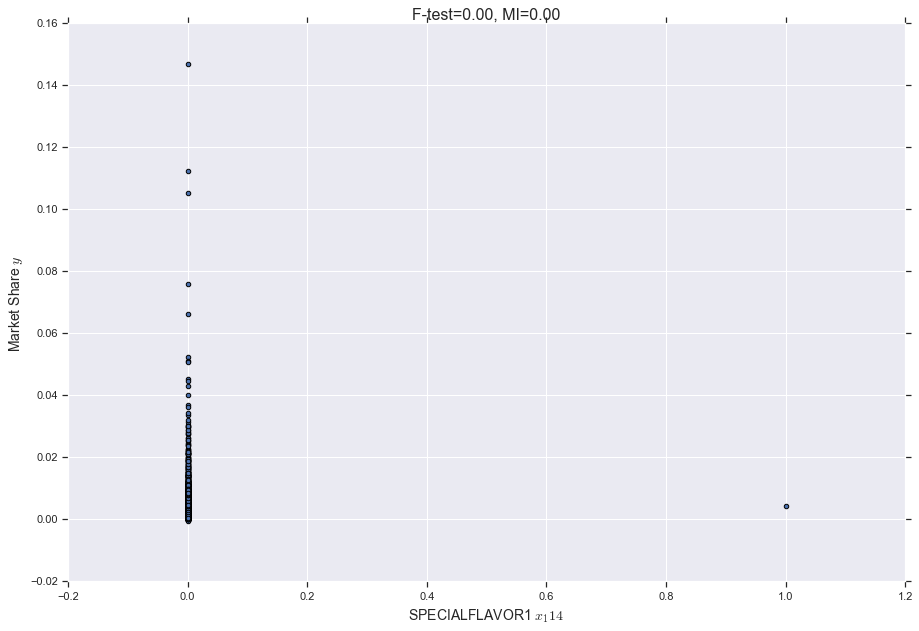

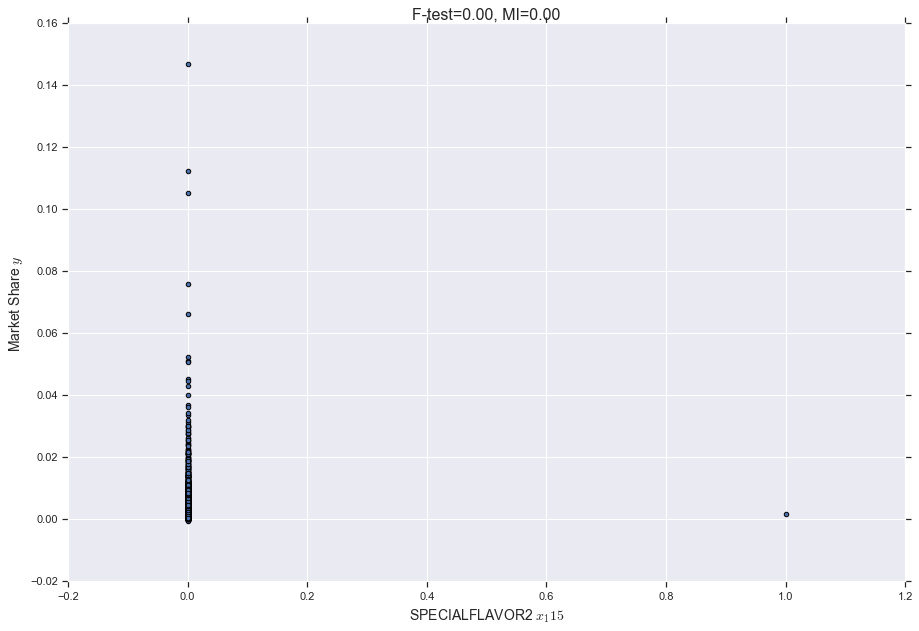

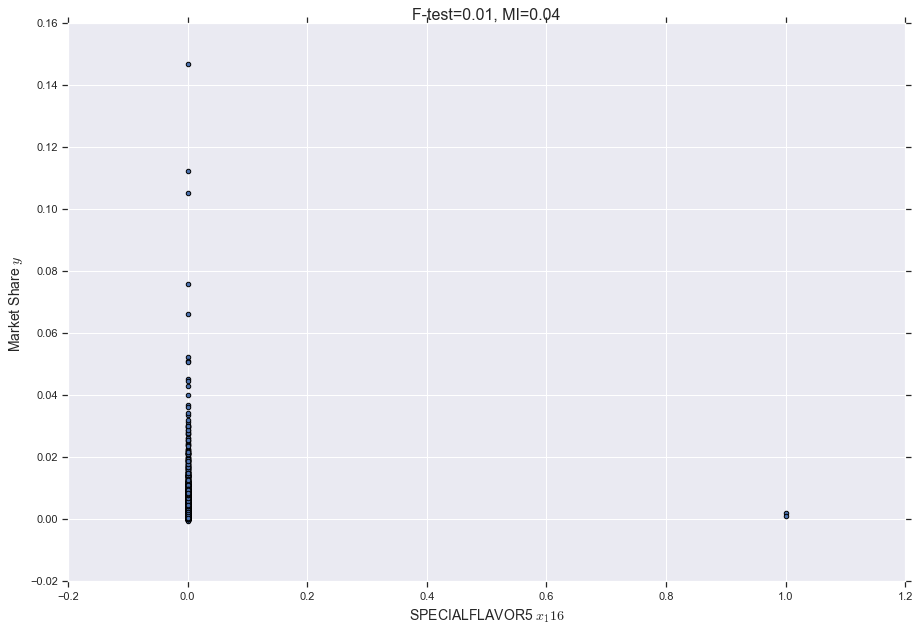

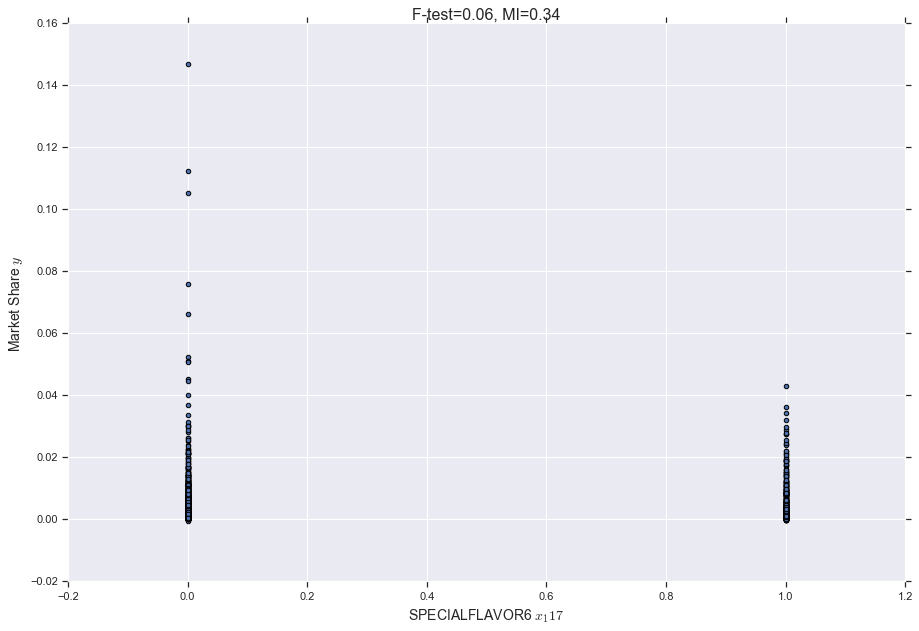

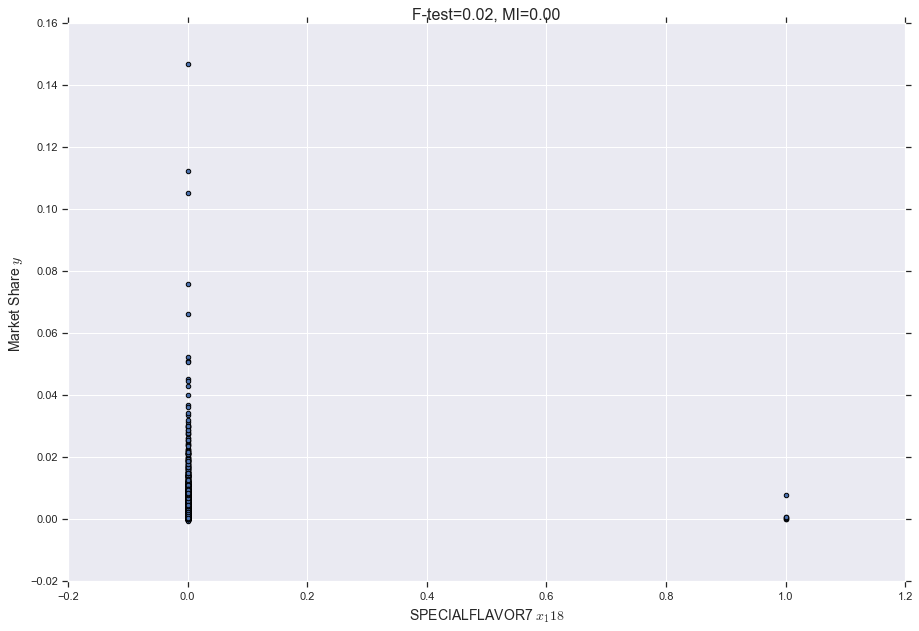

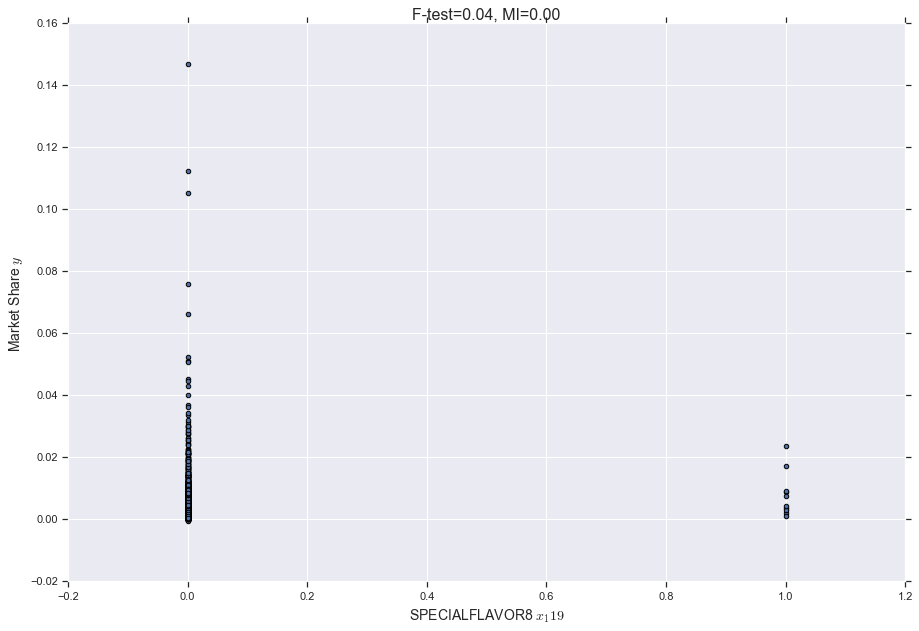

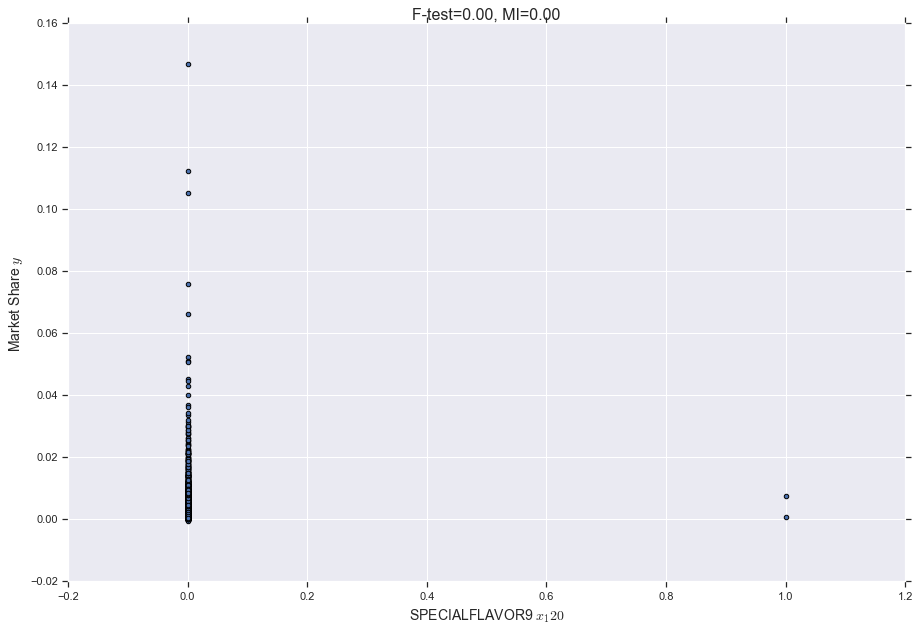

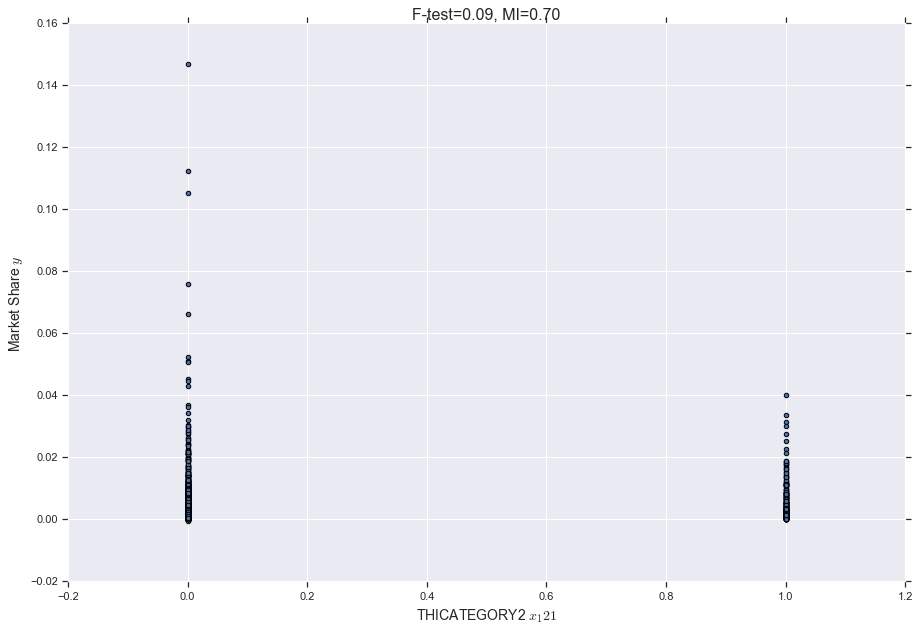

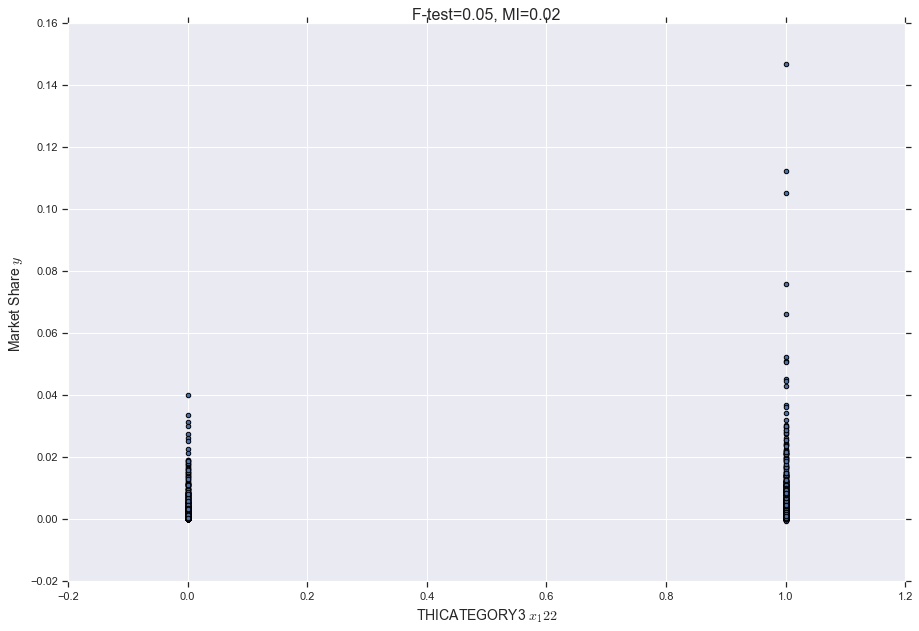

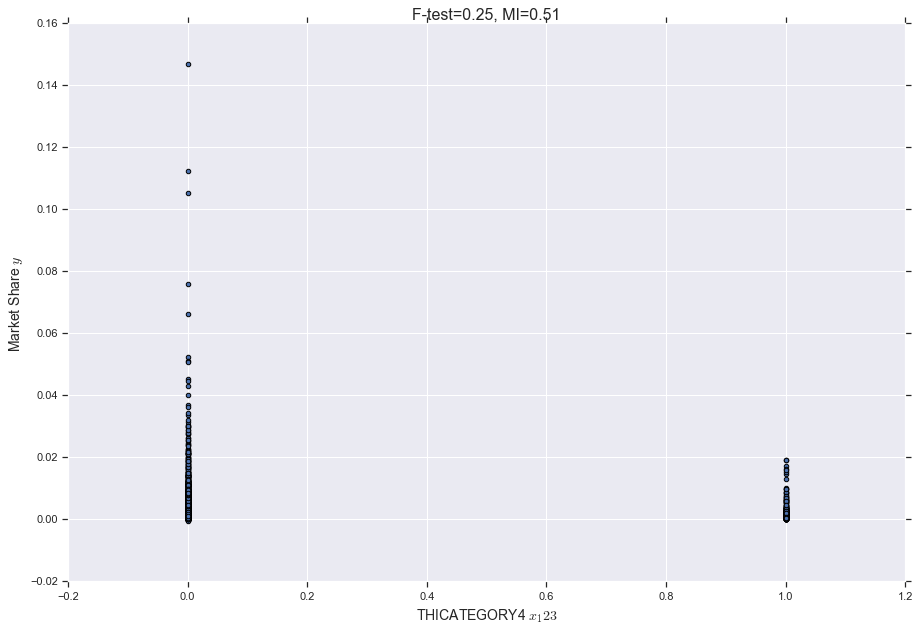

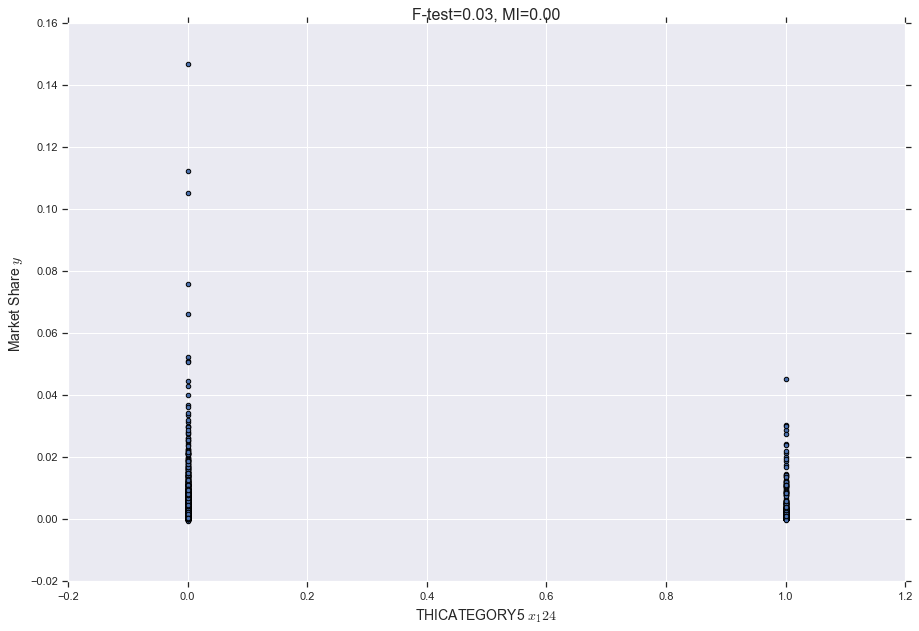

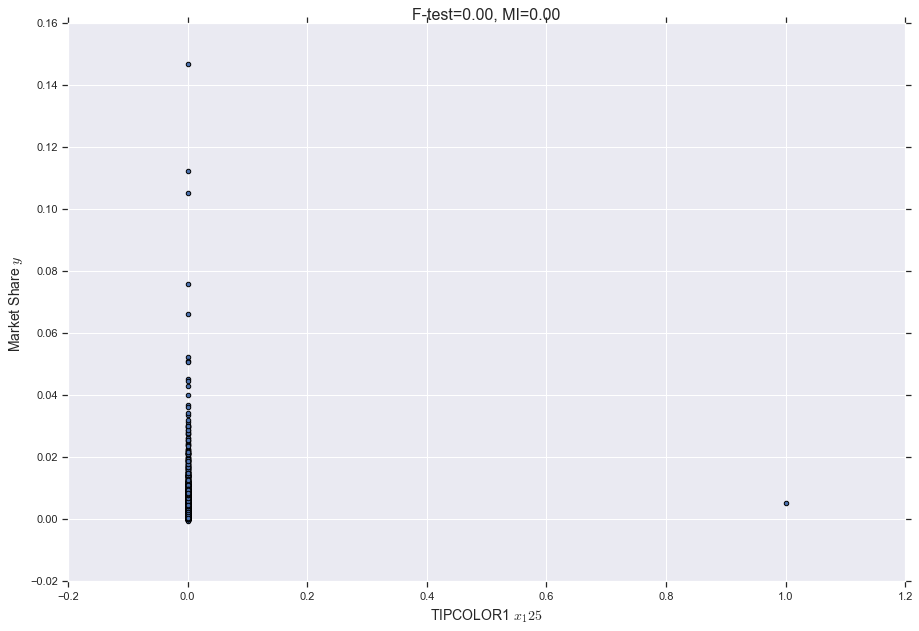

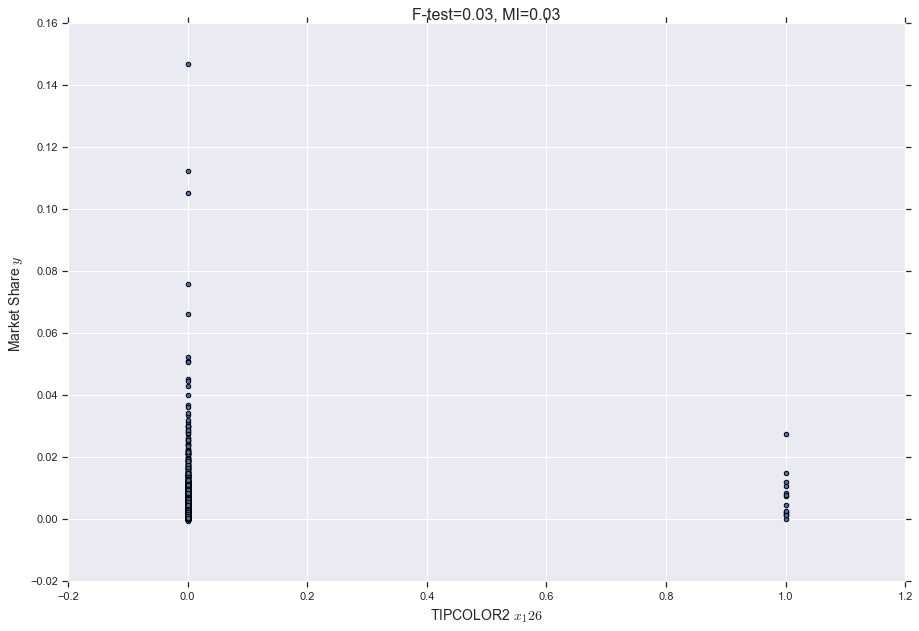

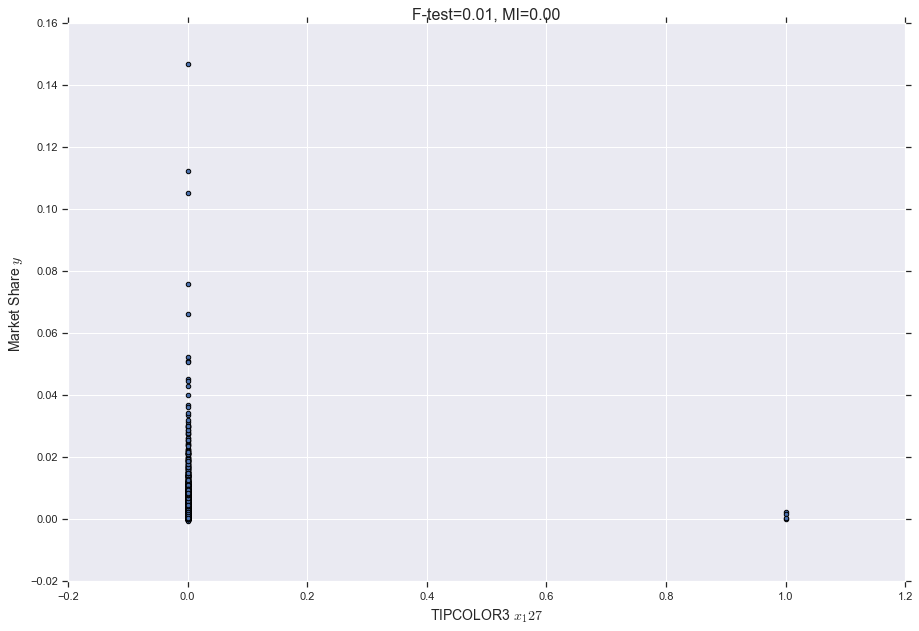

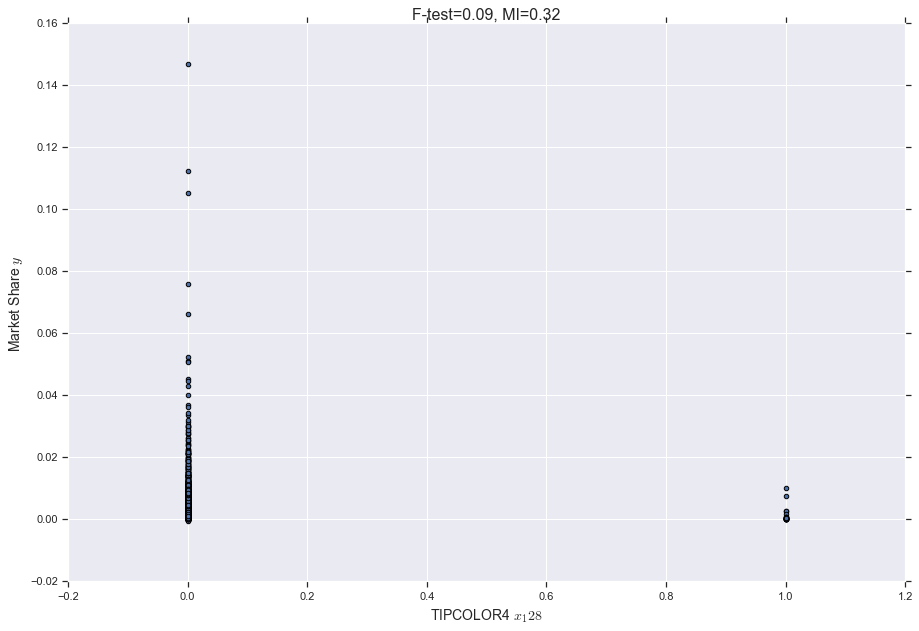

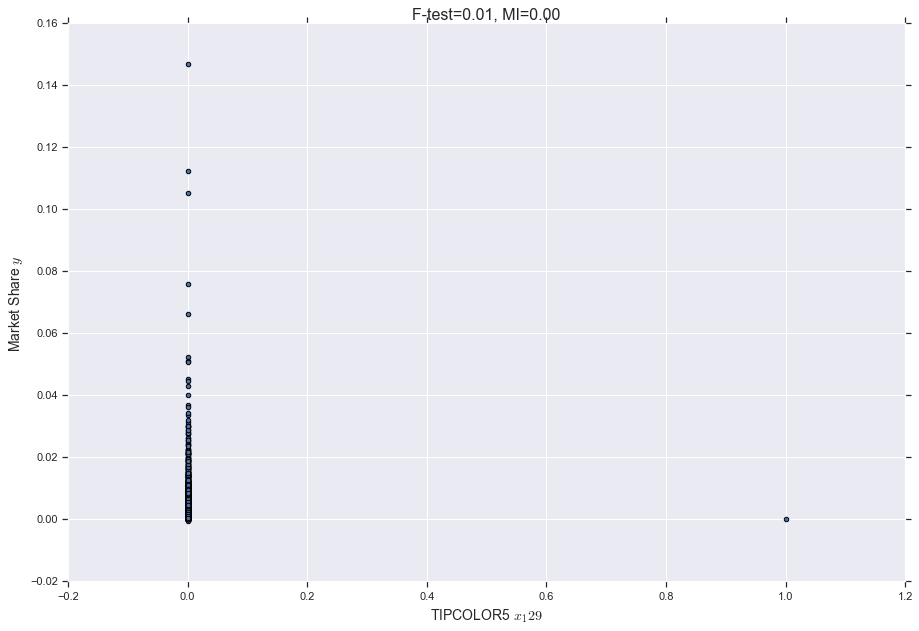

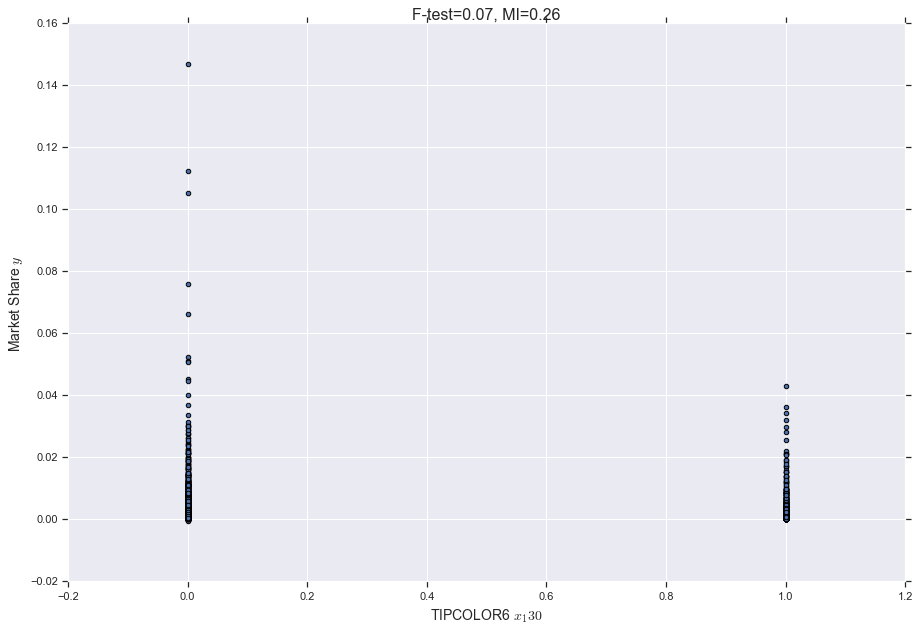

In [46]:
# Scatter plts for each fatures with f test and MI
from sklearn.feature_selection import f_regression, mutual_info_regression

np.random.seed(0)
num = len(df_scaled.columns) - 1

f_test, p = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

for i in range(num):
    plt.figure(figsize=(15, 10))
    plt.scatter(X[:, i], y, edgecolor='black', s=20)
    plt.xlabel(df_scaled.columns[i]+" $x_{}$".format(i + 1), fontsize=14)
    plt.ylabel("Market Share $y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
              fontsize=16)
    plt.show()

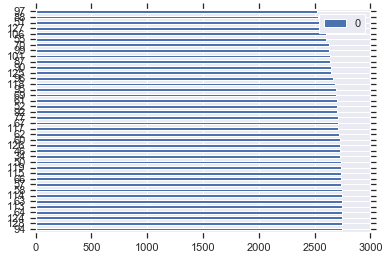

In [47]:
# Show top 40 KW features
df_kw = pd.DataFrame(kruskal)
top40 = df_kw.sort_values(by=0, ascending=False)[:40]
top40.plot(kind='barh')

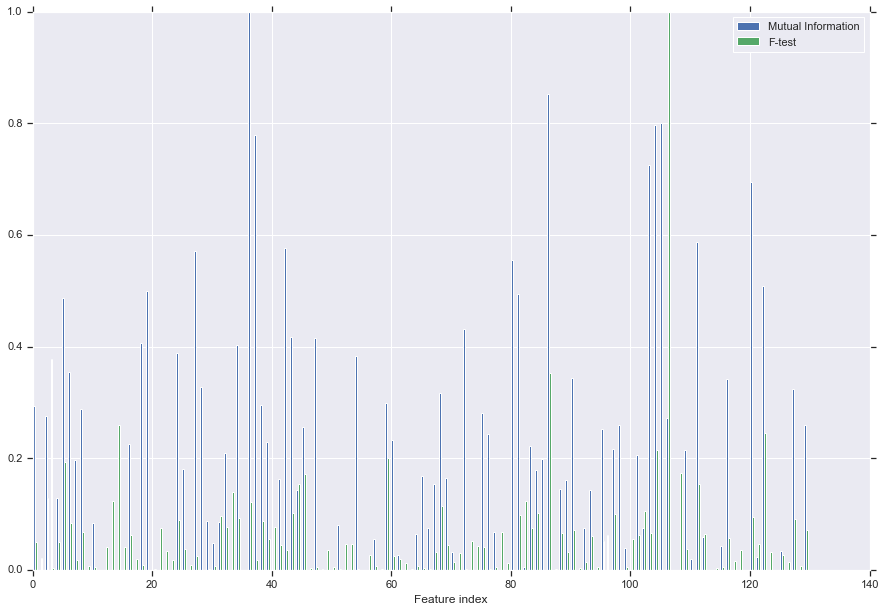

In [48]:
# Plot MI and f test on same graph
plt.figure(figsize=(15, 10))
ax1 = plt.bar(range(num), mi, color='b', width=0.33, )
ax2 = plt.bar(np.array(range(num))+0.33, f_test, color='g', width=0.33)
plt.legend((ax1, ax2), ('Mutual Information', 'F-test'))
plt.xlabel('Feature index')
plt.savefig('image/MI_ftest2.jpg')
plt.show()

In [49]:
# We look for features with low pvalue (rejecting hypothesis)
relevant = dict()
irrelevant = dict()
for i in range(len(f_test)):
    if p[i] < 0.05 and mi[i] < 0.05:
        irrelevant[df_scaled.columns[i]] = f_test[i]
    if f_test[i] > 0.8 :
        relevant[df_scaled.columns[i]] = f_test[i]
    if mi[i] > 0.8:
        relevant[df_scaled.columns[i]] = mi[i]
print('Potentialy irrelevant features: ', irrelevant)
print('\nHigh indicators: ', relevant)

Potentialy irrelevant features:  {'PCKT27': 0.17427790605124205, 'NPLLAUNCHYEAR5': 0.1239216591070897, 'ITEMSHAPE': 0.14031212353151482, 'MARKET1': 0.2591660190788256, 'BRANDDIFFERENTIATOR7': 0.12315921149345008}

High indicators:  {'NCON': 1.0, 'PCKT21': 1.0, 'PCKT14': 0.8001340287372259, 'NPLLAUNCHYEAR9': 0.8522631866919689}


In [50]:
# Again remove irrelevant univariate features
df_short = df_scaled.copy()
df_short = df_short.drop(irrelevant.keys(), axis = 1)

## Training <a class="anchor" id="training"></a>  

One can see the problem as a classification or regression task. For the business perspective it is more interesting to provide an actual number instead of a label, i.e. it provides more insight. We will first investigate classification and then regression

### Classification

In [53]:
from sklearn import svm, linear_model, neighbors, ensemble
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix 
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn import metrics
from time import time
from scipy import interp
from sklearn.utils.extmath import density

In [608]:
# Construct binary label
y = np.where(df_scaled['Market_Share'] > 0.007, 1, 0)
X = df_short.as_matrix()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=41)

target_names = ['Failure', 'Success']

C:\Users\Louis\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


              precision    recall  f1-score   support

     Failure       0.83      0.98      0.90       279
     Success       0.65      0.17      0.27        65

   micro avg       0.83      0.83      0.83       344
   macro avg       0.74      0.57      0.58       344
weighted avg       0.80      0.83      0.78       344



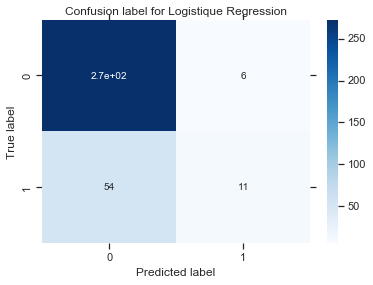

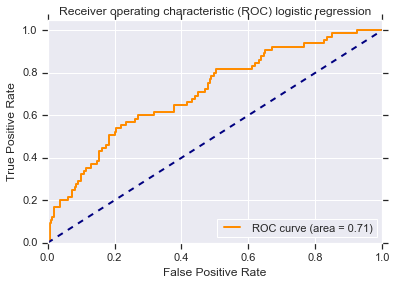

In [373]:
# Train logistic regression classifier
classifier = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)
clf = classifier.fit(X_train, y_train)

# Evaluate model
pred_ = clf.predict(X_test)
y_score = clf.predict_proba(X_test)
print(classification_report(y_test, pred_, target_names=target_names))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, pred_), annot=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion label for Logistique Regression')
plt.savefig('image/conf_matrix_logit.png')
plt.show()

# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) logistic regression')
plt.legend(loc="lower right")
plt.savefig('image/roc_logit.png')
plt.show()

<Container object of 125 artists>

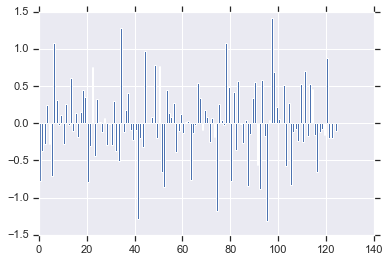

In [400]:
plt.bar(range(len(clf.coef_[0])), clf.coef_[0])

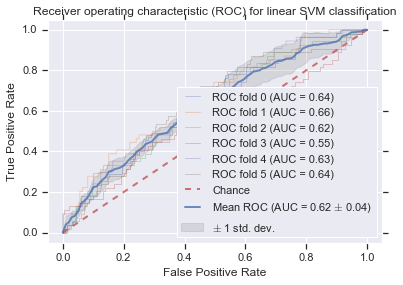

In [609]:
# Linear Support Vector Machine Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
svc = svm.LinearSVC(max_iter=10000)
classifier = CalibratedClassifierCV(svc, cv=2) 

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) for linear SVM classification')
plt.legend(loc="lower right")
plt.show()

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.01)
train time: 0.261s
test time:  0.001s
accuracy:   0.208
dimensionality: 120
density: 0.983333
classification report:
              precision    recall  f1-score   support

     Failure       0.83      0.99      0.90       279
     Success       0.67      0.12      0.21        65

   micro avg       0.82      0.82      0.82       344
   macro avg       0.75      0.55      0.55       344
weighted avg       0.80      0.82      0.77       344

confusion matrix:


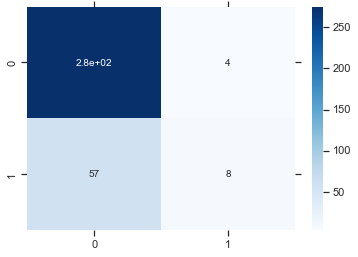


Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=50, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
      validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.029s
test time:  0.001s
accuracy:   0.395
dimensionality: 120
density: 0.900000
classification report:
              precision    recall  f1-score   support

     Failure       0.86      0.81      0.84       279
     Success       0.35      0.45      0.39        65

   micro avg       0.74      0.74      0.74       344
   macro avg       0.61      0.63      0.62       344
weighted avg       0.77      0.74      0.75       344

confusion matrix:


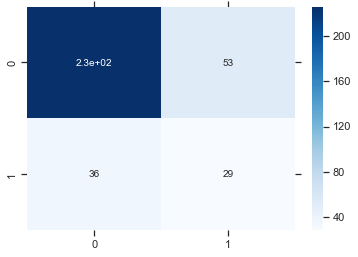


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=50, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.049s
test time:  0.000s
accuracy:   0.000
dimensionality: 120
density: 0.983333
classification report:
              precision    recall  f1-score   support

     Failure       0.81      1.00      0.89       279
     Success       0.00      0.00      0.00        65

   micro avg       0.81      0.81      0.81       344
   macro avg       0.41      0.50      0.45       344
weighted avg       0.66      0.81      0.72       344

confusion matrix:


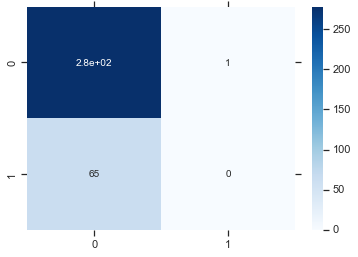


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')
train time: 0.031s
test time:  0.391s
accuracy:   0.211
classification report:
              precision    recall  f1-score   support

     Failure       0.83      0.99      0.90       279
     Success       0.73      0.12      0.21        65

   micro avg       0.83      0.83      0.83       344
   macro avg       0.78      0.56      0.56       344
weighted avg       0.81      0.83      0.77       344

confusion matrix:


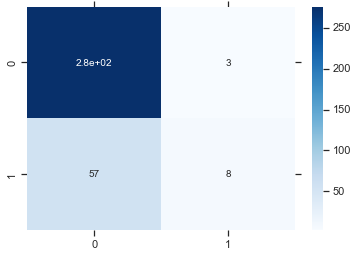


Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
train time: 1.284s
test time:  0.059s
accuracy:   0.293
classification report:
              precision    recall  f1-score   support

     Failure       0.84      0.98      0.90       279
     Success       0.71      0.18      0.29        65

   micro avg       0.83      0.83      0.83       344
   macro avg       0.77      0.58      0.60       344
weighted avg       0.81      0.83      0.79       344

confusion matrix:


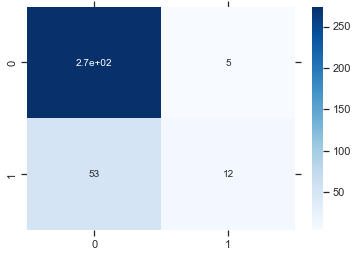


L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.067s
test time:  0.001s
accuracy:   0.247
dimensionality: 120
density: 0.983333
classification report:
              precision    recall  f1-score   support

     Failure       0.83      0.98      0.90       279
     Success       0.62      0.15      0.25        65

   micro avg       0.82      0.82      0.82       344
   macro avg       0.73      0.57      0.57       344
weighted avg       0.79      0.82      0.78       344

confusion matrix:


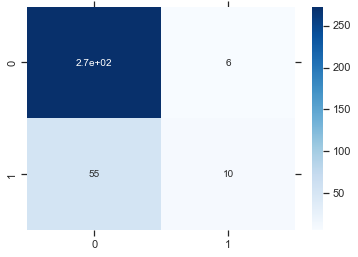


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.069s
test time:  0.001s
accuracy:   0.150
dimensionality: 120
density: 0.983333
classification report:
              precision    recall  f1-score   support

     Failure       0.82      0.97      0.89       279
     Success       0.40      0.09      0.15        65

   micro avg       0.80      0.80      0.80       344
   macro avg       0.61      0.53      0.52       344
weighted avg       0.74      0.80      0.75       344

confusion matrix:


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


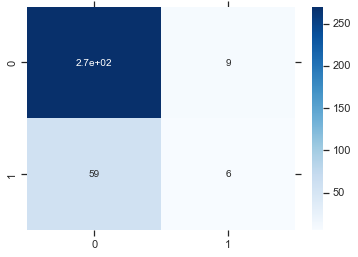


L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.456s
test time:  0.000s
accuracy:   0.205
dimensionality: 120
density: 0.725000
classification report:
              precision    recall  f1-score   support

     Failure       0.83      0.98      0.90       279
     Success       0.62      0.12      0.21        65

   micro avg       0.82      0.82      0.82       344
   macro avg       0.72      0.55      0.55       344
weighted avg       0.79      0.82      0.77       344

confusion matrix:


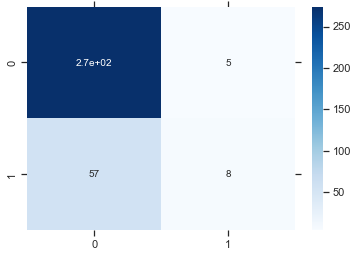


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.184s
test time:  0.001s
accuracy:   0.207
dimensionality: 120
density: 0.700000
classification report:
              precision    recall  f1-score   support

     Failure       0.83      0.95      0.89       279
     Success       0.41      0.14      0.21        65

   micro avg       0.80      0.80      0.80       344
   macro avg       0.62      0.55      0.55       344
weighted avg       0.75      0.80      0.76       344

confusion matrix:


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


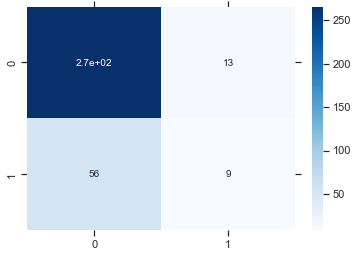


Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


train time: 0.226s
test time:  0.001s
accuracy:   0.364
dimensionality: 120
density: 0.858333
classification report:
              precision    recall  f1-score   support

     Failure       0.85      0.91      0.88       279
     Success       0.44      0.31      0.36        65

   micro avg       0.80      0.80      0.80       344
   macro avg       0.65      0.61      0.62       344
weighted avg       0.77      0.80      0.78       344

confusion matrix:


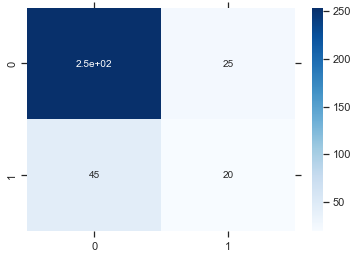


NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.006s
test time:  0.001s
accuracy:   0.338
classification report:
              precision    recall  f1-score   support

     Failure       0.85      0.63      0.73       279
     Success       0.25      0.52      0.34        65

   micro avg       0.61      0.61      0.61       344
   macro avg       0.55      0.58      0.53       344
weighted avg       0.74      0.61      0.65       344

confusion matrix:


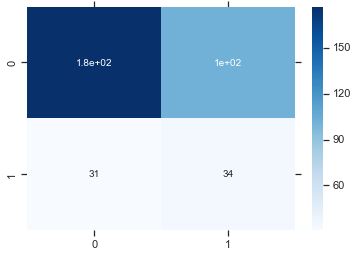


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0),
        max_features=None, no...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.247s
test time:  0.003s
accuracy:   0.247
classification report:
              precision    recall  f1-score   support

     Failure       0.83      0.98      0.90       279
     Success       0.62      0.15      0.25        65

   micro avg       0.82      0.82      0.82       344
   macro avg       0.73      0.57      0.57       344
weighted avg       0.79      0.82      0.78       344

confusion matrix:


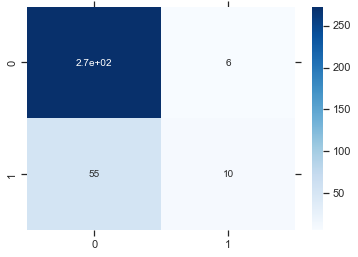

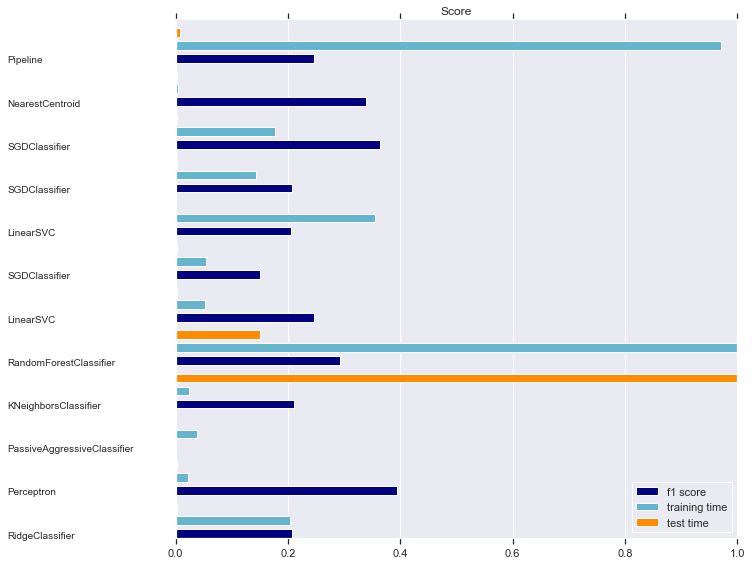

In [610]:
def benchClf(X_train, y_train, X_test, y_test, m):
    # #############################################################################
    # Benchmark classifiers
    def benchmark(clf):
        print('_' * 80)
        print("Training: ")
        print(clf)
        t0 = time()
        clf.fit(X_train, y_train)
        train_time = time() - t0
        print("train time: %0.3fs" % train_time)

        t0 = time()
        pred = clf.predict(X_test)
        test_time = time() - t0
        print("test time:  %0.3fs" % test_time)

        score = metrics.f1_score(y_test, pred)
        print("accuracy:   %0.3f" % score)

        if hasattr(clf, 'coef_'):
            print("dimensionality: %d" % clf.coef_.shape[1])
            print("density: %f" % density(clf.coef_))

        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                                target_names=target_names))

        print("confusion matrix:")
        plt.figure()
        sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Blues')
        plt.savefig('image/conf/'+str(t0)+'.jpg')
        plt.show()

        print()
        clf_descr = str(clf).split('(')[0]
        return clf_descr, score, train_time, test_time


    results = []
    for clf, name in (
            (linear_model.RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
            (linear_model.Perceptron(max_iter=50, tol=1e-3), "Perceptron"),
            (linear_model.PassiveAggressiveClassifier(max_iter=50, tol=1e-3),
             "Passive-Aggressive"),
            (neighbors.KNeighborsClassifier(n_neighbors=10), "kNN"),
            (ensemble.RandomForestClassifier(n_estimators=100), "Random forest")):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf))

    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        results.append(benchmark(svm.LinearSVC(penalty=penalty, dual=False,
                                           tol=1e-3)))

        # Train SGD model
        results.append(benchmark(linear_model.SGDClassifier(alpha=.0001, max_iter=50,
                                               penalty=penalty)))

    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(linear_model.SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty="elasticnet")))

    # Train NearestCentroid without threshold
    print('=' * 80)
    print("NearestCentroid (aka Rocchio classifier)")
    results.append(benchmark(neighbors.NearestCentroid()))

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    results.append(benchmark(Pipeline([
      ('feature_selection', SelectFromModel(svm.LinearSVC(penalty="l1", dual=False,
                                                      tol=1e-3))),
      ('classification', svm.LinearSVC(penalty="l2"))])))

    # make some plots

    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="f1 score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    plt.savefig('image/classification_models%s.jpg'% str(m))
    plt.show()
    
benchClf(X_train, y_train, X_test, y_test, 0)

C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the

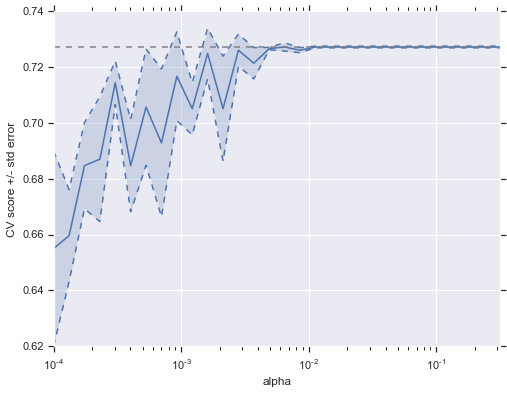

In [388]:
sgd = linear_model.SGDClassifier(epsilon=0.1,
       l1_ratio=0.15, learning_rate='optimal', loss='log', penalty='l1', max_iter=50, tol=1e-5)

alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(sgd, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

plt.show()

C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

     Failure       0.89      0.74      0.81       274
     Success       0.38      0.64      0.48        70

   micro avg       0.72      0.72      0.72       344
   macro avg       0.64      0.69      0.64       344
weighted avg       0.79      0.72      0.74       344



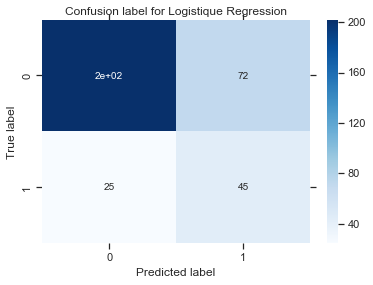

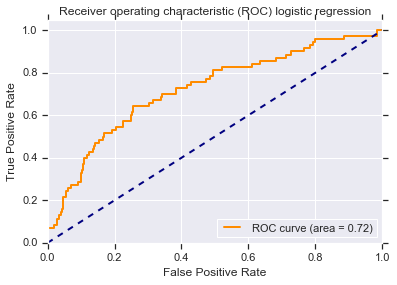

In [361]:
# Best classification model
sgd = linear_model.SGDClassifier(epsilon=0.1, alpha=2.30180731e-04, class_weight='balanced',
       l1_ratio=0.15, learning_rate='optimal', loss='log', penalty='l1', max_iter=50)
sgd.fit(X_train, y_train)

# Evaluate model
pred_ = sgd.predict(X_test)
y_score = sgd.predict_proba(X_test)
print(classification_report(y_test, pred_, target_names=target_names))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, pred_), annot=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion label for Logistique Regression')
plt.savefig('image/conf_matrix_logit_best.png')
plt.show()

# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) logistic regression')
plt.legend(loc="lower right")
plt.savefig('image/roc_logit_best.png')
plt.show()

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.01)
train time: 0.297s
test time:  0.001s
accuracy:   0.665
dimensionality: 120
density: 0.983333
classification report:
              precision    recall  f1-score   support

     Failure       0.67      0.65      0.66       174
     Success       0.65      0.68      0.66       170

   micro avg       0.66      0.66      0.66       344
   macro avg       0.66      0.66      0.66       344
weighted avg       0.66      0.66      0.66       344

confusion matrix:


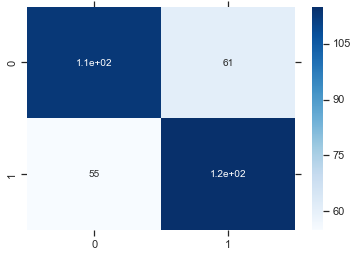


Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=50, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
      validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.016s
test time:  0.001s
accuracy:   0.358
dimensionality: 120
density: 0.900000
classification report:
              precision    recall  f1-score   support

     Failure       0.54      0.84      0.66       174
     Success       0.61      0.25      0.36       170

   micro avg       0.55      0.55      0.55       344
   macro avg       0.58      0.55      0.51       344
weighted avg       0.57      0.55      0.51       344

confusion matrix:


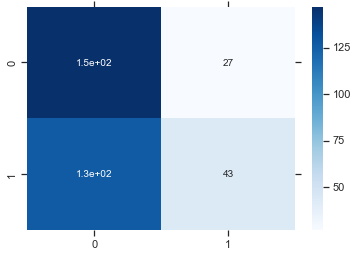


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=50, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.033s
test time:  0.000s
accuracy:   0.500
dimensionality: 120
density: 0.983333
classification report:
              precision    recall  f1-score   support

     Failure       0.58      0.79      0.67       174
     Success       0.65      0.41      0.50       170

   micro avg       0.60      0.60      0.60       344
   macro avg       0.61      0.60      0.58       344
weighted avg       0.61      0.60      0.58       344

confusion matrix:


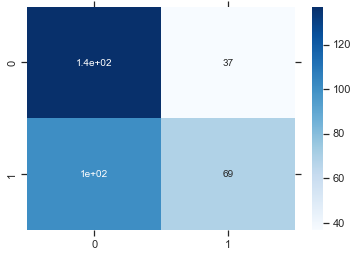


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')
train time: 0.022s
test time:  0.402s
accuracy:   0.637
classification report:
              precision    recall  f1-score   support

     Failure       0.65      0.66      0.65       174
     Success       0.64      0.63      0.64       170

   micro avg       0.65      0.65      0.65       344
   macro avg       0.65      0.65      0.65       344
weighted avg       0.65      0.65      0.65       344

confusion matrix:


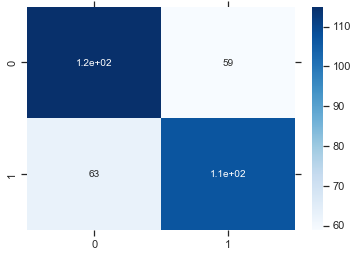


Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
train time: 0.931s
test time:  0.067s
accuracy:   0.714
classification report:
              precision    recall  f1-score   support

     Failure       0.73      0.67      0.70       174
     Success       0.69      0.74      0.71       170

   micro avg       0.71      0.71      0.71       344
   macro avg       0.71      0.71      0.71       344
weighted avg       0.71      0.71      0.71       344

confusion matrix:


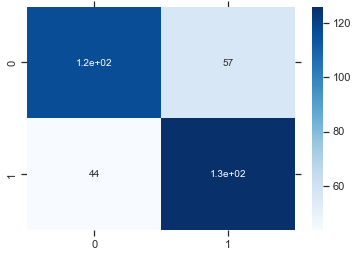


L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.064s
test time:  0.000s
accuracy:   0.665
dimensionality: 120
density: 0.983333
classification report:
              precision    recall  f1-score   support

     Failure       0.67      0.64      0.65       174
     Success       0.65      0.68      0.66       170

   micro avg       0.66      0.66      0.66       344
   macro avg       0.66      0.66      0.66       344
weighted avg       0.66      0.66      0.66       344

confusion matrix:


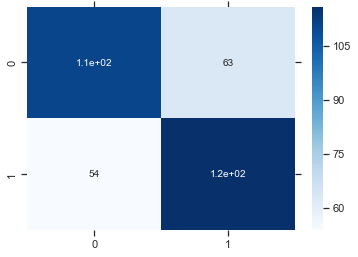


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.062s
test time:  0.001s
accuracy:   0.377
dimensionality: 120
density: 0.983333
classification report:
              precision    recall  f1-score   support

     Failure       0.54      0.84      0.66       174
     Success       0.62      0.27      0.38       170

   micro avg       0.56      0.56      0.56       344
   macro avg       0.58      0.55      0.52       344
weighted avg       0.58      0.56      0.52       344

confusion matrix:


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


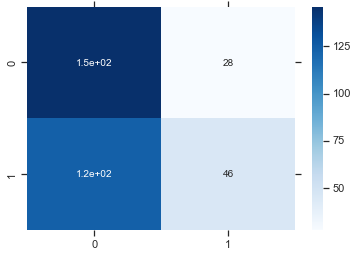


L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.480s
test time:  0.001s
accuracy:   0.665
dimensionality: 120
density: 0.858333
classification report:
              precision    recall  f1-score   support

     Failure       0.67      0.63      0.65       174
     Success       0.64      0.69      0.66       170

   micro avg       0.66      0.66      0.66       344
   macro avg       0.66      0.66      0.66       344
weighted avg       0.66      0.66      0.66       344

confusion matrix:


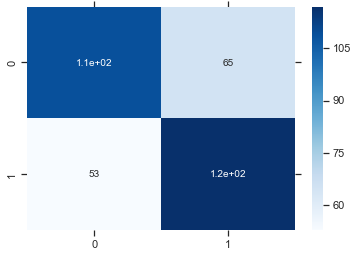


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


train time: 0.232s
test time:  0.001s
accuracy:   0.549
dimensionality: 120
density: 0.791667
classification report:
              precision    recall  f1-score   support

     Failure       0.57      0.61      0.59       174
     Success       0.57      0.53      0.55       170

   micro avg       0.57      0.57      0.57       344
   macro avg       0.57      0.57      0.57       344
weighted avg       0.57      0.57      0.57       344

confusion matrix:


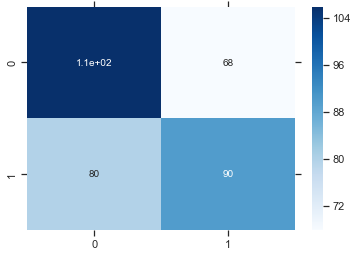


Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


train time: 0.299s
test time:  0.001s
accuracy:   0.601
dimensionality: 120
density: 0.850000
classification report:
              precision    recall  f1-score   support

     Failure       0.61      0.60      0.60       174
     Success       0.60      0.61      0.60       170

   micro avg       0.60      0.60      0.60       344
   macro avg       0.60      0.60      0.60       344
weighted avg       0.60      0.60      0.60       344

confusion matrix:


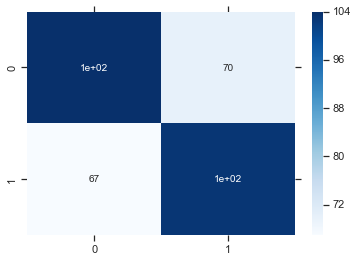


NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.005s
test time:  0.002s
accuracy:   0.610
classification report:
              precision    recall  f1-score   support

     Failure       0.62      0.61      0.62       174
     Success       0.61      0.61      0.61       170

   micro avg       0.61      0.61      0.61       344
   macro avg       0.61      0.61      0.61       344
weighted avg       0.61      0.61      0.61       344

confusion matrix:


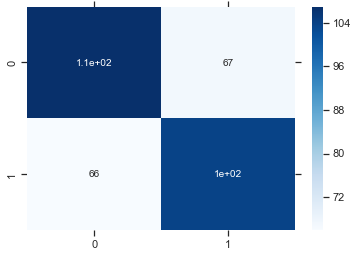


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0),
        max_features=None, no...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.867s
test time:  0.002s
accuracy:   0.661
classification report:
              precision    recall  f1-score   support

     Failure       0.67      0.64      0.65       174
     Success       0.65      0.68      0.66       170

   micro avg       0.66      0.66      0.66       344
   macro avg       0.66      0.66      0.66       344
weighted avg       0.66      0.66      0.66       344

confusion matrix:


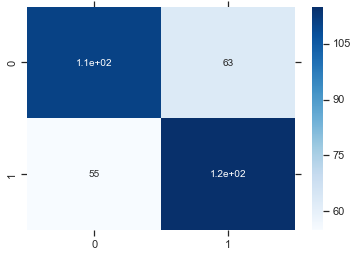

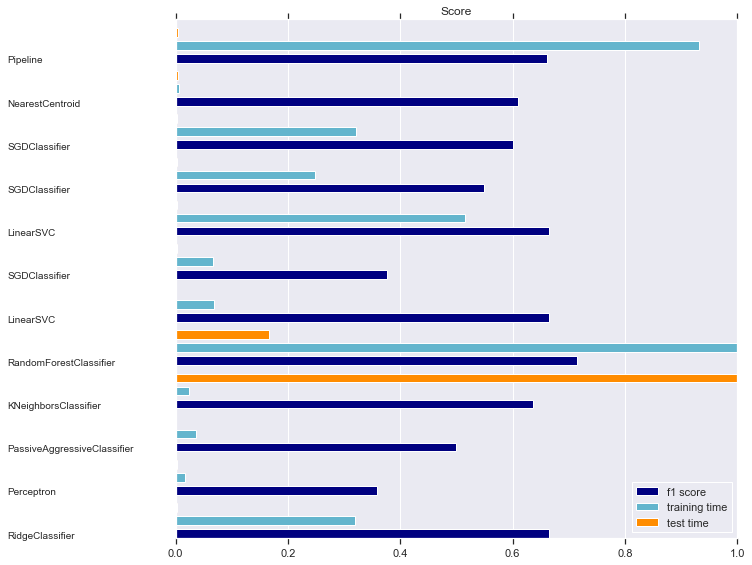

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.01)
train time: 0.256s
test time:  0.002s
accuracy:   0.357
dimensionality: 120
density: 0.983333
classification report:
              precision    recall  f1-score   support

     Failure       0.77      0.91      0.84       252
     Success       0.52      0.27      0.36        92

   micro avg       0.74      0.74      0.74       344
   macro avg       0.65      0.59      0.60       344
weighted avg       0.71      0.74      0.71       344

confusion matrix:


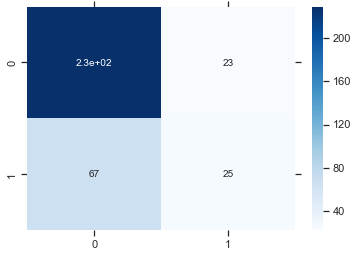


Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=50, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
      validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.015s
test time:  0.000s
accuracy:   0.454
dimensionality: 120
density: 0.925000
classification report:
              precision    recall  f1-score   support

     Failure       0.85      0.33      0.47       252
     Success       0.31      0.84      0.45        92

   micro avg       0.46      0.46      0.46       344
   macro avg       0.58      0.58      0.46       344
weighted avg       0.70      0.46      0.47       344

confusion matrix:


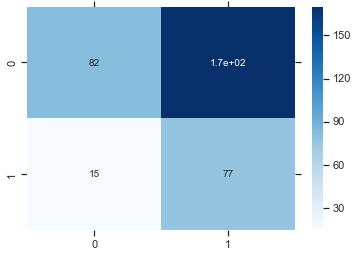


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=50, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.028s
test time:  0.001s
accuracy:   0.407
dimensionality: 120
density: 0.983333
classification report:
              precision    recall  f1-score   support

     Failure       0.78      0.59      0.67       252
     Success       0.32      0.54      0.41        92

   micro avg       0.58      0.58      0.58       344
   macro avg       0.55      0.57      0.54       344
weighted avg       0.66      0.58      0.60       344

confusion matrix:


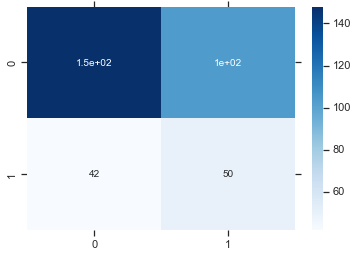


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')
train time: 0.030s
test time:  0.470s
accuracy:   0.372
classification report:
              precision    recall  f1-score   support

     Failure       0.78      0.95      0.86       252
     Success       0.65      0.26      0.37        92

   micro avg       0.76      0.76      0.76       344
   macro avg       0.71      0.60      0.61       344
weighted avg       0.74      0.76      0.73       344

confusion matrix:


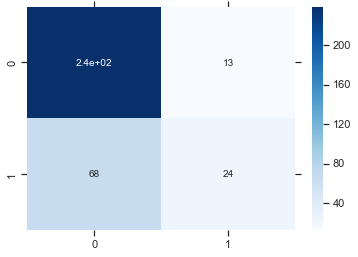


Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
train time: 0.972s
test time:  0.051s
accuracy:   0.436
classification report:
              precision    recall  f1-score   support

     Failure       0.79      0.95      0.86       252
     Success       0.71      0.32      0.44        92

   micro avg       0.78      0.78      0.78       344
   macro avg       0.75      0.63      0.65       344
weighted avg       0.77      0.78      0.75       344

confusion matrix:


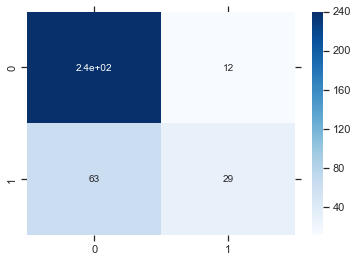


L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.054s
test time:  0.000s
accuracy:   0.431
dimensionality: 120
density: 0.983333
classification report:
              precision    recall  f1-score   support

     Failure       0.79      0.89      0.84       252
     Success       0.54      0.36      0.43        92

   micro avg       0.75      0.75      0.75       344
   macro avg       0.67      0.62      0.63       344
weighted avg       0.72      0.75      0.73       344

confusion matrix:


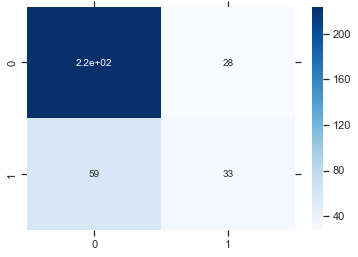


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.064s
test time:  0.001s
accuracy:   0.042
dimensionality: 120
density: 0.983333
classification report:
              precision    recall  f1-score   support

     Failure       0.74      0.99      0.84       252
     Success       0.50      0.02      0.04        92

   micro avg       0.73      0.73      0.73       344
   macro avg       0.62      0.51      0.44       344
weighted avg       0.67      0.73      0.63       344

confusion matrix:


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


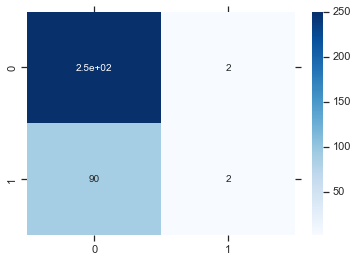


L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.626s
test time:  0.001s
accuracy:   0.397
dimensionality: 120
density: 0.883333
classification report:
              precision    recall  f1-score   support

     Failure       0.78      0.90      0.84       252
     Success       0.54      0.32      0.40        92

   micro avg       0.74      0.74      0.74       344
   macro avg       0.66      0.61      0.62       344
weighted avg       0.72      0.74      0.72       344

confusion matrix:


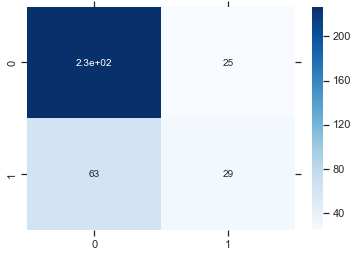


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


train time: 0.260s
test time:  0.000s
accuracy:   0.353
dimensionality: 120
density: 0.775000
classification report:
              precision    recall  f1-score   support

     Failure       0.77      0.92      0.84       252
     Success       0.55      0.26      0.35        92

   micro avg       0.74      0.74      0.74       344
   macro avg       0.66      0.59      0.60       344
weighted avg       0.71      0.74      0.71       344

confusion matrix:


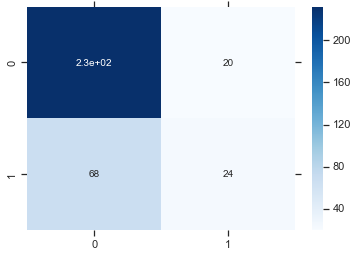


Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


train time: 0.325s
test time:  0.001s
accuracy:   0.261
dimensionality: 120
density: 0.833333
classification report:
              precision    recall  f1-score   support

     Failure       0.76      0.97      0.85       252
     Success       0.65      0.16      0.26        92

   micro avg       0.75      0.75      0.75       344
   macro avg       0.71      0.57      0.56       344
weighted avg       0.73      0.75      0.69       344

confusion matrix:


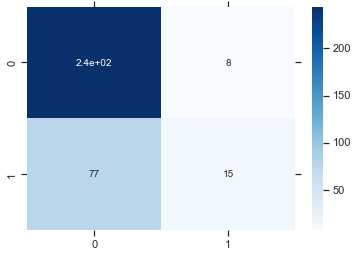


NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.004s
test time:  0.002s
accuracy:   0.412
classification report:
              precision    recall  f1-score   support

     Failure       0.78      0.63      0.70       252
     Success       0.34      0.52      0.41        92

   micro avg       0.60      0.60      0.60       344
   macro avg       0.56      0.58      0.56       344
weighted avg       0.66      0.60      0.62       344

confusion matrix:


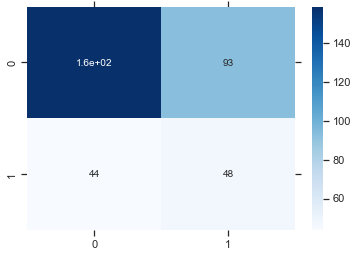


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0),
        max_features=None, no...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.925s
test time:  0.003s
accuracy:   0.392
classification report:
              precision    recall  f1-score   support

     Failure       0.78      0.89      0.83       252
     Success       0.52      0.32      0.39        92

   micro avg       0.74      0.74      0.74       344
   macro avg       0.65      0.60      0.61       344
weighted avg       0.71      0.74      0.72       344

confusion matrix:


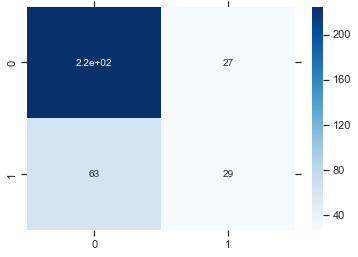

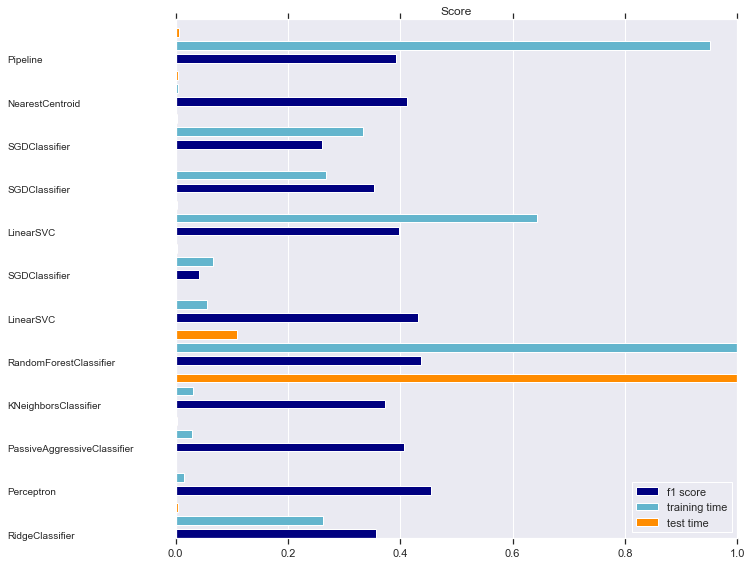

In [611]:
# Try other thresholds to balance output
thresholds = [df_scaled['Market_Share'].median(), df_scaled['Market_Share'].mean()]

for thresh in thresholds:
    # Construct binary label
    y = np.where(df_scaled['Market_Share'] > thresh, 1, 0)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=41)
    
    benchClf(X_train, y_train, X_test, y_test, thresh)

### Regression

#### OLS

We first randomly split training and test set (80%/20%).

In [51]:
# Labels are continuous values
X = df_scaled.drop('Market_Share', axis = 1).as_matrix()
y = np.array(df_var['Market_Share'])

C:\Users\Louis\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [60]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

preds = reg.predict(X_test)

def dispPreds(preds):
    mae = mean_absolute_error(y_true=y_test, y_pred=preds)
    r2 = r2_score(y_true=y_test, y_pred=preds)
    mse = mean_squared_error(y_true=y_test, y_pred=preds)

    print('mae :', mae)
    print('R2 :', r2)
    print('mse :', mse)

dispPreds(preds)

mae : 0.004177787294246223
R2 : 0.1017539812971493
mse : 5.218390894543912e-05


In [61]:
# Baseline mean
from sklearn.model_selection import KFold
kf = KFold(n_splits=5) 

mae = []
mse = []
r2 = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mean =[np.median(y)]*len(y_test)
    mae.append(mean_absolute_error(y_true=y_test, y_pred=mean))
    r2.append(r2_score(y_true=y_test, y_pred=mean))
    mse.append(mean_squared_error(y_true=y_test, y_pred=mean))
print('%s %0.3f +- %0.3f' % ('mae', np.array(mae).mean()*100, np.array(mae).std()*100))
print('%s %0.3f +- %0.3f' % ('mse', np.array(mse).mean()*100, np.array(mse).std()*100))
print('%s %0.3f +- %0.3f' % ('r2', np.array(r2).mean()*100, np.array(r2).std()*100))


mae 0.370 +- 0.049
mse 0.007 +- 0.004
r2 -9.859 +- 4.146


In [254]:
# Check for anomalies in coefficients
for i, c in enumerate(reg.coef_):
    if c > 10 or -10 > c:
        print(df_scaled.columns[i])

LOCALCLASS2
LOCALCLASS3
PCKT28
TCLASS2
TCLASS3


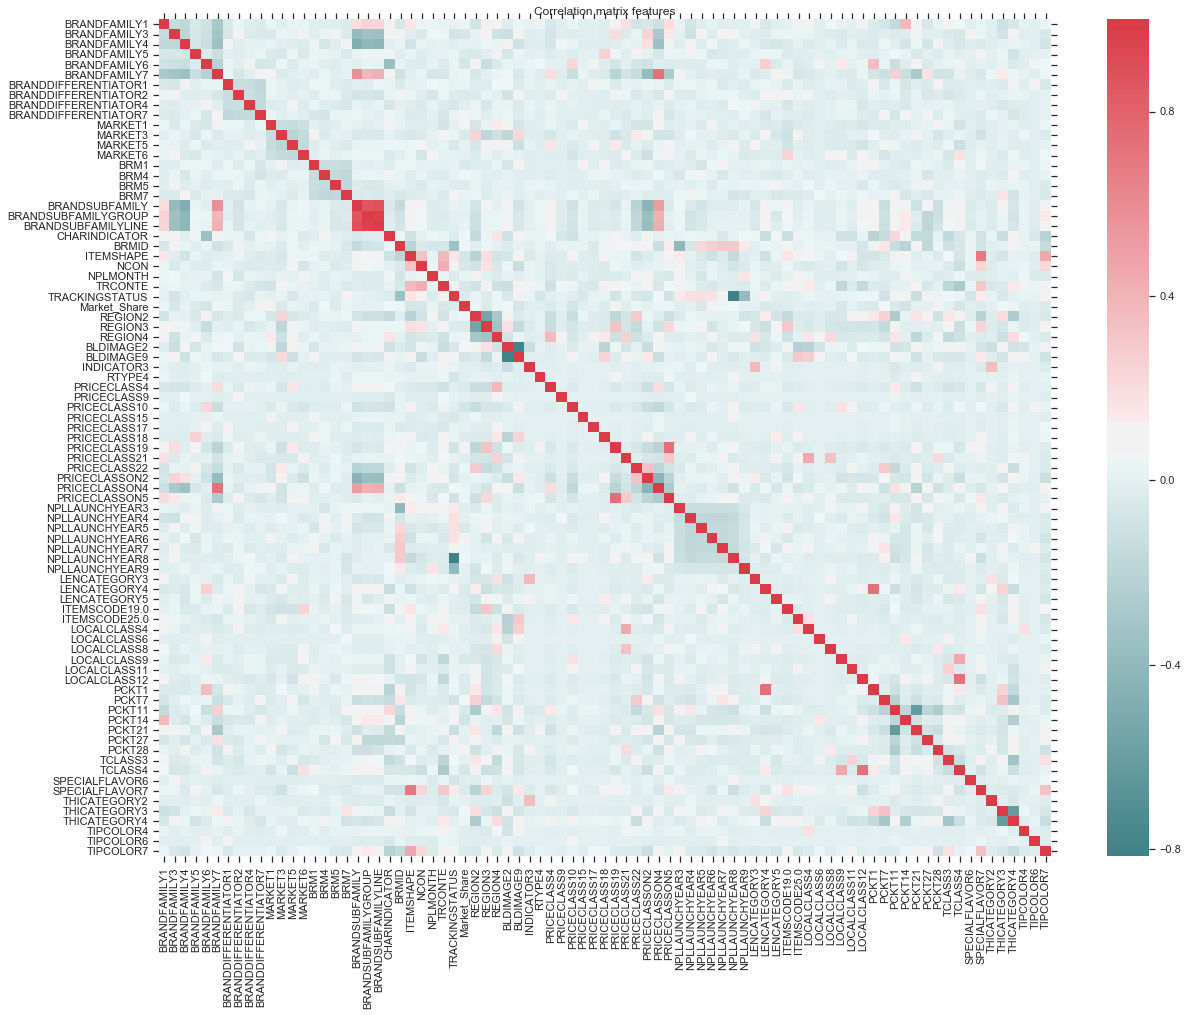

x                   y      corr
0  BRANDSUBFAMILYGROUP  BRANDSUBFAMILYLINE  0.965622

In [191]:
corr = pd.DataFrame(df_short).corr()
dispCorr(corr)

We test the robustness by doing a 5-Fold cross validation (again randomly shuffled).

In [63]:
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree

# score with MSE and R2
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

# CV with OLS
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
clf = tree.DecisionTreeRegressor()

cv_results = cross_validate(clf, X_skb, y,
                            scoring=scoring, cv=cv, return_train_score=False)

In [64]:
def dispRes(cv_results):
    for score in cv_results:
        print('%s %0.3f +- %0.3f' % (score, cv_results[score].mean()*100, cv_results[score].std()*100))
dispRes(cv_results)

test_r2 1.446 +- 24.923
test_neg_mean_squared_error -0.008 +- 0.002
score_time 0.440 +- 0.049
fit_time 2.199 +- 0.303
test_neg_mean_absolute_error -0.447 +- 0.050


In [65]:
# Tweak feature numbers
k = [5, 10, 20, 30, 40, X.shape[1]]

for n in k:
    print('Taking %d best features' % (n))
    svr_rbf = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_lin = svm.SVR(kernel='linear', C=1e3)
    svr_poly = svm.SVR(kernel='poly', C=1e3, degree=2)
    X_transformed = SelectKBest(mutual_info_regression, k=n).fit_transform(X, y_norm)
    cv_results = cross_validate(svr_rbf, X_transformed, y,
                            scoring=scoring, cv=5, return_train_score=False)
    for score in cv_results:
        print('%s %0.3f +- %0.3f' % (score, cv_results[score].mean()*100, cv_results[score].std()*100))
    print()
    cv_results = cross_validate(svr_lin, X_transformed, y,
                            scoring=scoring, cv=cv, return_train_score=False)
    for score in cv_results:
        print('%s %0.3f +- %0.3f' % (score, cv_results[score].mean()*100, cv_results[score].std()*100))
    print()
    cv_results = cross_validate(svr_poly, X_transformed, y,
                            scoring=scoring, cv=cv, return_train_score=False)
    for score in cv_results:
        print('%s %0.3f +- %0.3f' % (score, cv_results[score].mean()*100, cv_results[score].std()*100))
    print()

Taking 5 best features
test_r2 -9572.938 +- 6326.616
test_neg_mean_squared_error -0.436 +- 0.081
score_time 0.404 +- 0.422
fit_time 0.202 +- 0.313
test_neg_mean_absolute_error -6.538 +- 0.663

test_r2 -5957.225 +- 4443.705
test_neg_mean_squared_error -0.388 +- 0.112
score_time 0.284 +- 0.471
fit_time 0.162 +- 0.323
test_neg_mean_absolute_error -6.117 +- 0.949

test_r2 -5957.225 +- 4443.705
test_neg_mean_squared_error -0.388 +- 0.112
score_time 0.313 +- 0.625
fit_time 2.176 +- 3.621
test_neg_mean_absolute_error -6.117 +- 0.949

Taking 10 best features


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Ro

test_r2 -9572.938 +- 6326.616
test_neg_mean_squared_error -0.436 +- 0.081
score_time 0.404 +- 0.424
fit_time 0.041 +- 0.082
test_neg_mean_absolute_error -6.538 +- 0.663

test_r2 -5957.225 +- 4443.705
test_neg_mean_squared_error -0.388 +- 0.112
score_time 0.364 +- 0.369
fit_time 0.243 +- 0.391
test_neg_mean_absolute_error -6.117 +- 0.949

test_r2 -5957.225 +- 4443.705
test_neg_mean_squared_error -0.388 +- 0.112
score_time 0.403 +- 0.494
fit_time 0.243 +- 0.392
test_neg_mean_absolute_error -6.117 +- 0.949

Taking 20 best features


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Ro

test_r2 -9572.938 +- 6326.616
test_neg_mean_squared_error -0.436 +- 0.081
score_time 0.600 +- 0.126
fit_time 0.340 +- 0.049
test_neg_mean_absolute_error -6.538 +- 0.663

test_r2 -5957.225 +- 4443.705
test_neg_mean_squared_error -0.388 +- 0.112
score_time 0.660 +- 0.102
fit_time 0.400 +- 0.063
test_neg_mean_absolute_error -6.117 +- 0.949

test_r2 -5957.225 +- 4443.705
test_neg_mean_squared_error -0.388 +- 0.112
score_time 0.680 +- 0.133
fit_time 0.460 +- 0.080
test_neg_mean_absolute_error -6.117 +- 0.949

Taking 30 best features


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Ro

test_r2 -9572.938 +- 6326.616
test_neg_mean_squared_error -0.436 +- 0.081
score_time 0.700 +- 0.089
fit_time 0.400 +- 0.063
test_neg_mean_absolute_error -6.538 +- 0.663

test_r2 -5957.225 +- 4443.705
test_neg_mean_squared_error -0.388 +- 0.112
score_time 0.700 +- 0.063
fit_time 0.500 +- 0.063
test_neg_mean_absolute_error -6.117 +- 0.949

test_r2 -5957.225 +- 4443.705
test_neg_mean_squared_error -0.388 +- 0.112
score_time 0.680 +- 0.040
fit_time 0.580 +- 0.075
test_neg_mean_absolute_error -6.117 +- 0.949

Taking 40 best features


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Ro

test_r2 -9572.938 +- 6326.616
test_neg_mean_squared_error -0.436 +- 0.081
score_time 0.625 +- 0.766
fit_time 0.000 +- 0.000
test_neg_mean_absolute_error -6.538 +- 0.663

test_r2 -5957.225 +- 4443.705
test_neg_mean_squared_error -0.388 +- 0.112
score_time 0.443 +- 0.614
fit_time 0.625 +- 0.765
test_neg_mean_absolute_error -6.117 +- 0.949

test_r2 -5957.225 +- 4443.705
test_neg_mean_squared_error -0.388 +- 0.112
score_time 0.625 +- 0.765
fit_time 0.312 +- 0.625
test_neg_mean_absolute_error -6.117 +- 0.949

Taking 130 best features


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Ro

test_r2 -9572.938 +- 6326.616
test_neg_mean_squared_error -0.436 +- 0.081
score_time 0.405 +- 0.337
fit_time 1.173 +- 0.321
test_neg_mean_absolute_error -6.538 +- 0.663

test_r2 -5957.225 +- 4443.705
test_neg_mean_squared_error -0.388 +- 0.112
score_time 0.929 +- 0.101
fit_time 1.053 +- 0.080
test_neg_mean_absolute_error -6.117 +- 0.949

test_r2 -5957.225 +- 4443.705
test_neg_mean_squared_error -0.388 +- 0.112
score_time 0.767 +- 0.391
fit_time 1.213 +- 0.407
test_neg_mean_absolute_error -6.117 +- 0.949



C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Louis\AppData\Ro

Given poor results and the following plots, Linear regression is a bad estimator.

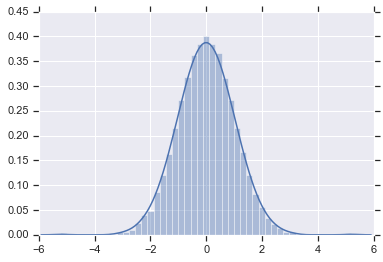

In [56]:
# Transform output to Normal distribution
qt = preprocessing.QuantileTransformer(output_distribution='normal')
y_norm = qt.fit_transform((np.array(y)+1).reshape(-1,1)).reshape(len(X),)
sns.distplot(y_norm)

In [59]:
# Select top perdictors with anova
skb = SelectKBest(score_func=f_regression, k=40)
X_skb = skb.fit_transform(X, y_norm)

In [95]:
from sklearn import kernel_ridge
reg = linear_model.RidgeCV()

reg.fit(X_skb, y)

cv_results = cross_validate(reg, X_skb, y,
                            scoring=scoring, cv=5, return_train_score=False)

dispRes(cv_results)

test_r2 0.731 +- 4.848
test_neg_mean_squared_error -0.006 +- 0.003
score_time 0.460 +- 0.049
fit_time 2.658 +- 0.174
test_neg_mean_absolute_error -0.410 +- 0.041


mae : 0.004484829076081522
R2 : -0.019026444680795507
mse : 0.00012049989675383945


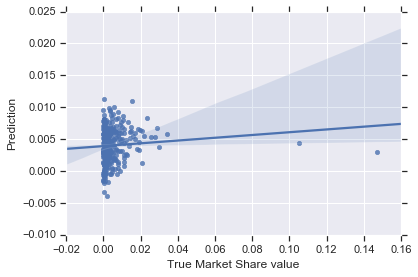

In [72]:
preds = reg.predict(X_test)
dispPreds(preds)
sns.regplot(y_test, preds)
plt.xlabel('True Market Share value')
plt.ylabel('Prediction')
plt.savefig('image/true_vs_pred.jpg')

mae : 0.0040438087157128565
R2 : -0.04926573041536719
mse : 0.0001240756928756635


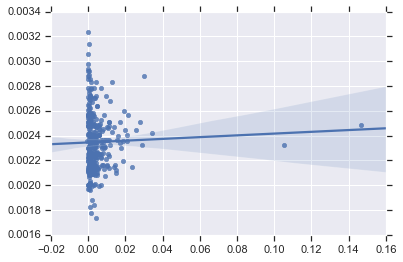

In [74]:
# Attempt on neural networks
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor()
preds = mlp.fit(X_train, y_train).predict(X_test)
preds = qt.inverse_transform(preds.reshape(-1,1))-1
dispPreds(preds)
sns.regplot(y_test, preds.reshape(-1,))

## Scoring <a class="anchor" id="scoring"></a>

In [97]:
# load data to score
df_score = pd.read_excel('./score_data.xlsx')

def preProcess(df_case):
    # Remove text in dataframe for categories
    df_nums = df_case.select_dtypes(include=['object']).applymap(rmvText)
    categories = df_nums.columns
    df_no_text = df_case.copy()
    df_no_text.update(df_nums)
    for col in categories:
        df_no_text[col] = df_no_text[col].astype('float')
    
    # Apply cyclic value with sin(pi*X/6)
    df_cyclic = df_no_text.copy()
    df_cyclic['NPLLAUNCHDATE'] = np.sin(np.pi * (df_cyclic['NPLLAUNCHDATE'] % 100) / 6)
    df_cyclic = df_cyclic.rename(columns={'NPLLAUNCHDATE': 'NPLMONTH'})
    
    # Replace with a new encoded category
    df_image = df_cyclic.copy()
    df_image['BLDIMAGE'] = df_image['BLDIMAGE'].replace({2:1, 9:2, 7:0, 5:0, 1:0, 4:0, 6:0, 3:0})
    # Replace with a new encoded category
    df_image['PCKT'] = df_image['PCKT'].replace([2, 13, 31, 19, 12, 15, 6, 26, 16, 20, 4, 17, 18, 3, 29, 9, 23, 5], 0)
    
    # dict encoder
    d = {1:0, 2:1}
    cols = ['CHARINDICATOR', 'ISSTRATEGIC', 'MINDICATOR', 'TRACKINGSTATUS']
    df_bins = df_image.copy()
    df_bins[cols] = df_bins[cols].replace(d)
    
    df_ids = df_bins.copy()
    # Modulo trick to encode
    df_ids['BRMID'] = (df_ids['BRMID'] / 10000000).astype(int) % 5
    
    # Remove local price since it cannot be standardized for the time being
    df_noprice = df_ids.drop('RETAILPACKPRICE', axis=1)
    # Order categories
    lencats_enc = {1: 5, 2:3, 3:2, 4:4, 5:1}
    df_enc = df_noprice.copy()
    df_enc['LENCATEGORY'] = df_enc['LENCATEGORY'].map(lencats_enc)
    
    # Fill categories with a class arbitrarily set to 0
    df_filled = df_enc.fillna(0)
    for cat in categories:
        df_filled[cat] = df_filled[cat].astype(int).astype('category')
        
    # Remove irrelevant (or close to be) variables
    df_rm = df_filled.drop(['ISSTRATEGIC', 'MARKETEDBRAND', 'BRANDONMARKET', 'BRANDSUBFAMILYGROUPING', 'LEN',
                            'ISREPLACEMENT', 'LATESTPERIODINDEX'], axis=1)
    return df_rm.copy()
df_sc = preProcess(df_score)

In [ ]:
# save preprocessed scoring matrix
#df_score_processed.to_csv('score_processed.csv')

In [81]:
# Load preprocessed data
df_score_processed = pd.read_csv('score_processed.csv').drop('Unnamed: 0', axis=1)
X_to_score = df_score_processed.as_matrix()

C:\Users\Louis\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [96]:
# Score data
X_to_score_skb = skb.transform(X_to_score)
scores = reg.predict(X_to_score_skb)
scores

array([3.97607181e-03, 3.97607181e-03, 3.97607181e-03, 4.20188240e-03,
       3.96617361e-03, 3.24418795e-03, 2.26308289e-03, 3.90790410e-05,
       3.05063875e-03, 1.20091294e-03, 3.90464340e-03, 5.27906431e-03,
       8.51670260e-03, 3.22617134e-03, 3.06383799e-03, 2.07115739e-03,
       1.43753214e-03, 3.00444879e-03, 9.45686184e-03, 9.67858440e-03,
       3.42083950e-03, 6.30993769e-03, 2.08032200e-03, 5.29977349e-03,
       4.35197723e-03, 1.64814652e-03, 6.93771591e-03, 4.25094881e-03,
       4.97293447e-03])

In [100]:
# Save results
df_score['Market_Share'] = scores
df_score.to_csv('score_data.xlsx')